In this notebook, we analyse global effects such as lineage scores across conditions.

# Load Packages and Set Global Variables

<a id="imports"></a>

## Imports and Settings

In [1]:
import anndata
import cellrank as cr
import diffxpy.api as de
import gc
import numpy as np
import scanpy as sc
import scipy.stats
import scvelo as scv
import sys
import pandas as pd
import pickle
import seaborn as sb
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors

np.random.seed(seed=1)

In [2]:
import fatevision

In [3]:
sc.settings.verbosity = 3 # amount of output

root_dir = '.'

dir_in = root_dir + 'data/'
base_dir = root_dir + 'results/'
dir_gene_sets = root_dir + 'data/gene_sets/MSigDBlists/'
dir_cc_gene_set = root_dir + 'data/gene_sets/regev_lab_cell_cycle_genes_10X.txt'

# Make sure that these folders exist:
dir_out = base_dir + 'figures/afmos/'
dir_tables = base_dir + 'tables/afmos/'
dir_anndata = base_dir + 'anndata/afmos/'
dir_de = base_dir + 'de/afmos/'

tf_ref_file = dir_gene_sets + 'c3.tft.v5.2.symbols.gmt'
bp_ref_file = dir_gene_sets + 'c5.bp.v5.2.symbols.gmt'
mf_ref_file = dir_gene_sets  + "c5.mf.v5.2.symbols.gmt"
hal_ref_file = dir_gene_sets + 'h.all.v5.2.symbols.gmt'

sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, scanpy=True)
sc.settings.figdir = dir_out
scv.settings.figdir = dir_out
print(sys.version)

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.6
scanpy      1.8.1
sinfo       0.3.4
-----
2f7ece400a652629565c523b34ee61b04afa385c    NA
PIL                                         8.3.2
absl                                        NA
anyio                                       NA
appnope                                     0.1.2
astunparse                                  1.6.3
attr                                        21.2.0
babel                                       2.9.1
backcall                                    0.2.0
batchgl

In [4]:
constructs_dict = {
    "Ascl1": ["synAscl1_dsred-minus-gn", "synAscl1_dsred-plus-gn"],
    "Foxa2": ["synFoxA2_dsred-minus-gn", "synFoxA2_dsred-plus-gn"],
    "Myod1": ["synMyoD1_dsred-minus-gn", "synMyoD1_dsred-plus-gn"],
    "Oct4": ["synOct4-minus-gn", "synOct4-plus-gn"],
    "Sox2": ["synSox2-minus-gn", "synSox2-plus-gn"],
}
constructs = list(constructs_dict.keys())
constructs_color_dict = {
    "DsRed": ["DsRed-minus-gn", "DsRed-plus-gn"],
    "AcGFP1": ["AcGFP1-minus-gn", "AcGFP1-plus-gn"],
    "EBFP2": ["EBFP2-minus-gn", "EBFP2-plus-gn"],
}
constructs_color = list(constructs_color_dict.keys())
endogenous_genes = [
    "Ascl1",
    "Foxa2",
    "Myod1",
    "Pou5f1",
    "Sox2",
]

<a id="Global"></a>

## Global Variables

Set whether anndata objects are recomputed or loaded from cache.

In [5]:
bool_recomp = True

Set whether to produce plots, set to False for test runs.

In [6]:
bool_plot = True

Set colors for UMAP:

In [7]:
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

# Load data

In [8]:
adata_proc = sc.read(dir_anndata+'adata_proc.h5ad')

## Transcription factor annotation

In [9]:
tf_rs = {
    "tf": de.enrich.RefSets(fn = tf_ref_file, type ='gmt'),
    "mf": de.enrich.RefSets(fn = mf_ref_file, type ='gmt'),
    "bp": de.enrich.RefSets(fn = bp_ref_file, type ='gmt'),
    "hallmark": de.enrich.RefSets(fn = hal_ref_file, type ='gmt')
}

In [10]:
tf_sets = [x for x in tf_rs["mf"].sets if "transcription_factor" in x.id.lower()]
print("selected sets:")
print([x.id for x in tf_rs["mf"].sets if "transcription_factor" in x.id.lower()])

tf_annotated_genes = []
for x in tf_rs["mf"].sets:
    if "transcription_factor" in x.id.lower():
        tf_annotated_genes.extend(list(x.genes))
tf_annotated_genes = np.sort(np.asarray(list(set([x.lower() for x in tf_annotated_genes]))))
print("number of genes in selected sets %i" % len(tf_annotated_genes))

selected sets:
['GO_BHLH_TRANSCRIPTION_FACTOR_BINDING', 'GO_TRANSCRIPTION_FACTOR_ACTIVITY_DIRECT_LIGAND_REGULATED_SEQUENCE_SPECIFIC_DNA_BINDING', 'GO_TRANSCRIPTION_FACTOR_ACTIVITY_RNA_POLYMERASE_II_DISTAL_ENHANCER_SEQUENCE_SPECIFIC_BINDING', 'GO_RNA_POLYMERASE_II_TRANSCRIPTION_FACTOR_ACTIVITY_SEQUENCE_SPECIFIC_DNA_BINDING', 'GO_RNA_POLYMERASE_II_REPRESSING_TRANSCRIPTION_FACTOR_BINDING', 'GO_TRANSCRIPTION_FACTOR_ACTIVITY_RNA_POLYMERASE_II_TRANSCRIPTION_FACTOR_BINDING', 'GO_NUCLEIC_ACID_BINDING_TRANSCRIPTION_FACTOR_ACTIVITY', 'GO_TRANSCRIPTIONAL_REPRESSOR_ACTIVITY_RNA_POLYMERASE_II_ACTIVATING_TRANSCRIPTION_FACTOR_BINDING', 'GO_TRANSCRIPTION_FACTOR_ACTIVITY_RNA_POLYMERASE_II_CORE_PROMOTER_PROXIMAL_REGION_SEQUENCE_SPECIFIC_BINDING', 'GO_TRANSCRIPTIONAL_REPRESSOR_ACTIVITY_RNA_POLYMERASE_II_TRANSCRIPTION_FACTOR_BINDING', 'GO_TRANSCRIPTION_FACTOR_ACTIVITY_PROTEIN_BINDING', 'GO_ACTIVATING_TRANSCRIPTION_FACTOR_BINDING', 'GO_TRANSCRIPTION_FACTOR_BINDING', 'GO_RNA_POLYMERASE_II_ACTIVATING_TRANSCR

# Explained variance

In [11]:
processing_continuous = "_log" # "_norm_log"

In [12]:
adata_proc_prediction = adata_proc[
    ["fibroblast" not in x
     for x in adata_proc.obs["louvain_named"].values], :
].copy()
for x in constructs:
    adata_proc_prediction.obs[x+"_positive_condition"] = \
        [x.lower() in xx.lower() for xx in adata_proc_prediction.obs['inferred_category_real'].values]

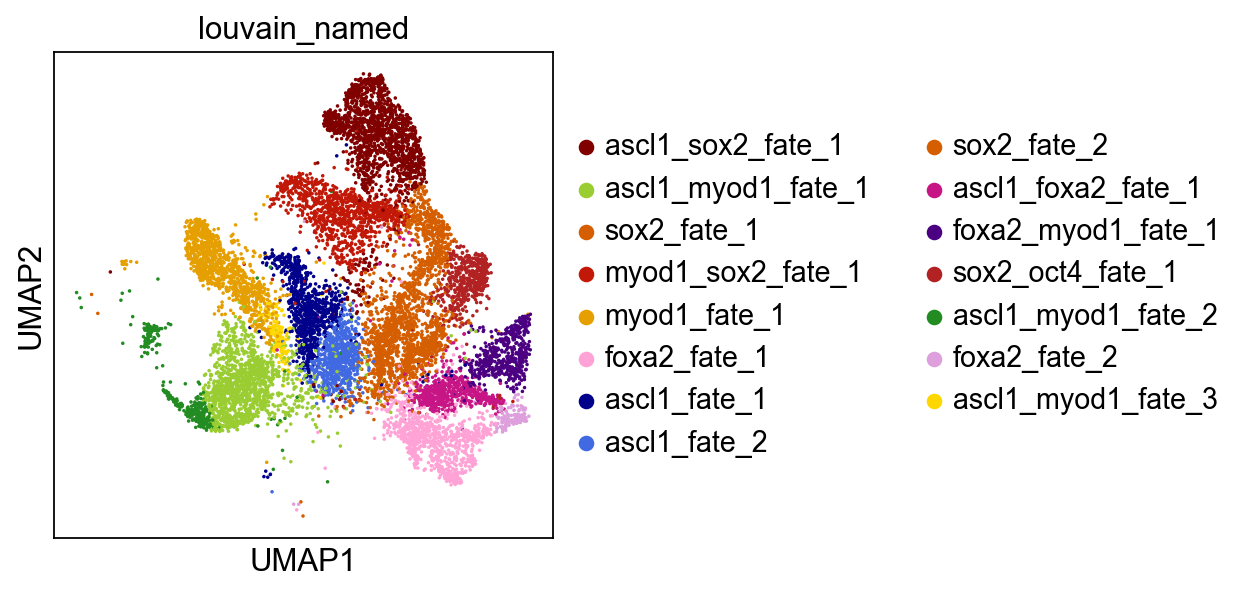

In [13]:
sc.pl.umap(adata_proc_prediction, color="louvain_named")

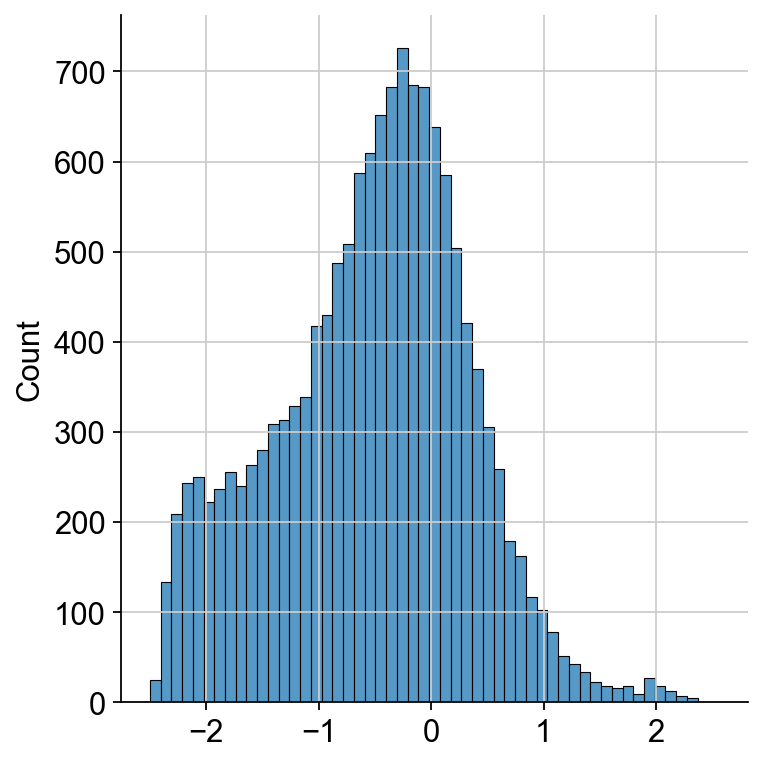

In [14]:
sb.displot(np.log(np.exp(adata_proc_prediction.var["means"].values)-1.)/np.log(10))

<AxesSubplot:>

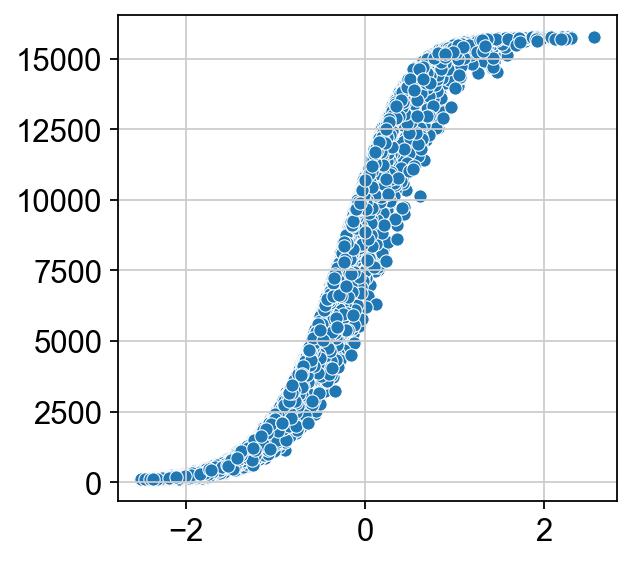

In [15]:
sb.scatterplot(
    x=np.log(np.exp(adata_proc_prediction.var["means"].values)-1.)/np.log(10),
    y=adata_proc_prediction.var["n_cells"].values
)

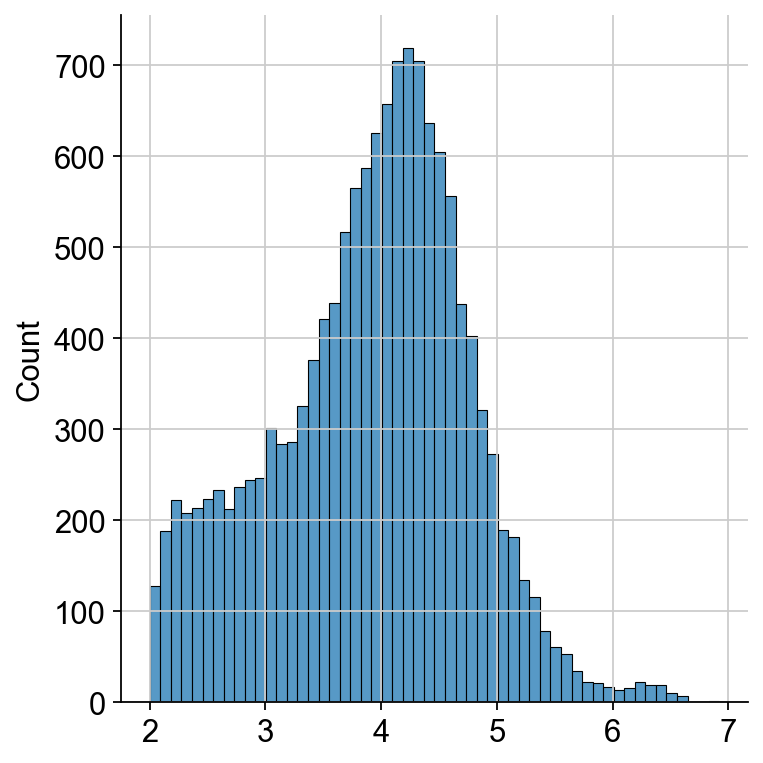

In [16]:
sb.displot(np.log(adata_proc_prediction.var["n_counts"].values)/np.log(10))

<AxesSubplot:>

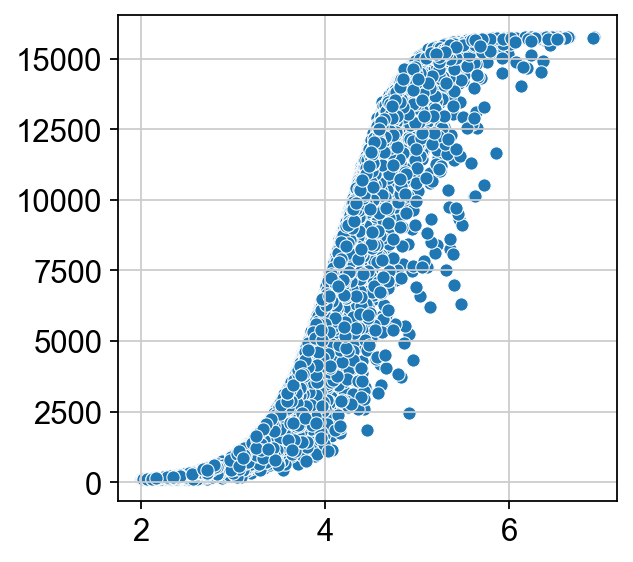

In [17]:
sb.scatterplot(
    x=np.log(adata_proc_prediction.var["n_counts"].values)/np.log(10),
    y=adata_proc_prediction.var["n_cells"].values
)

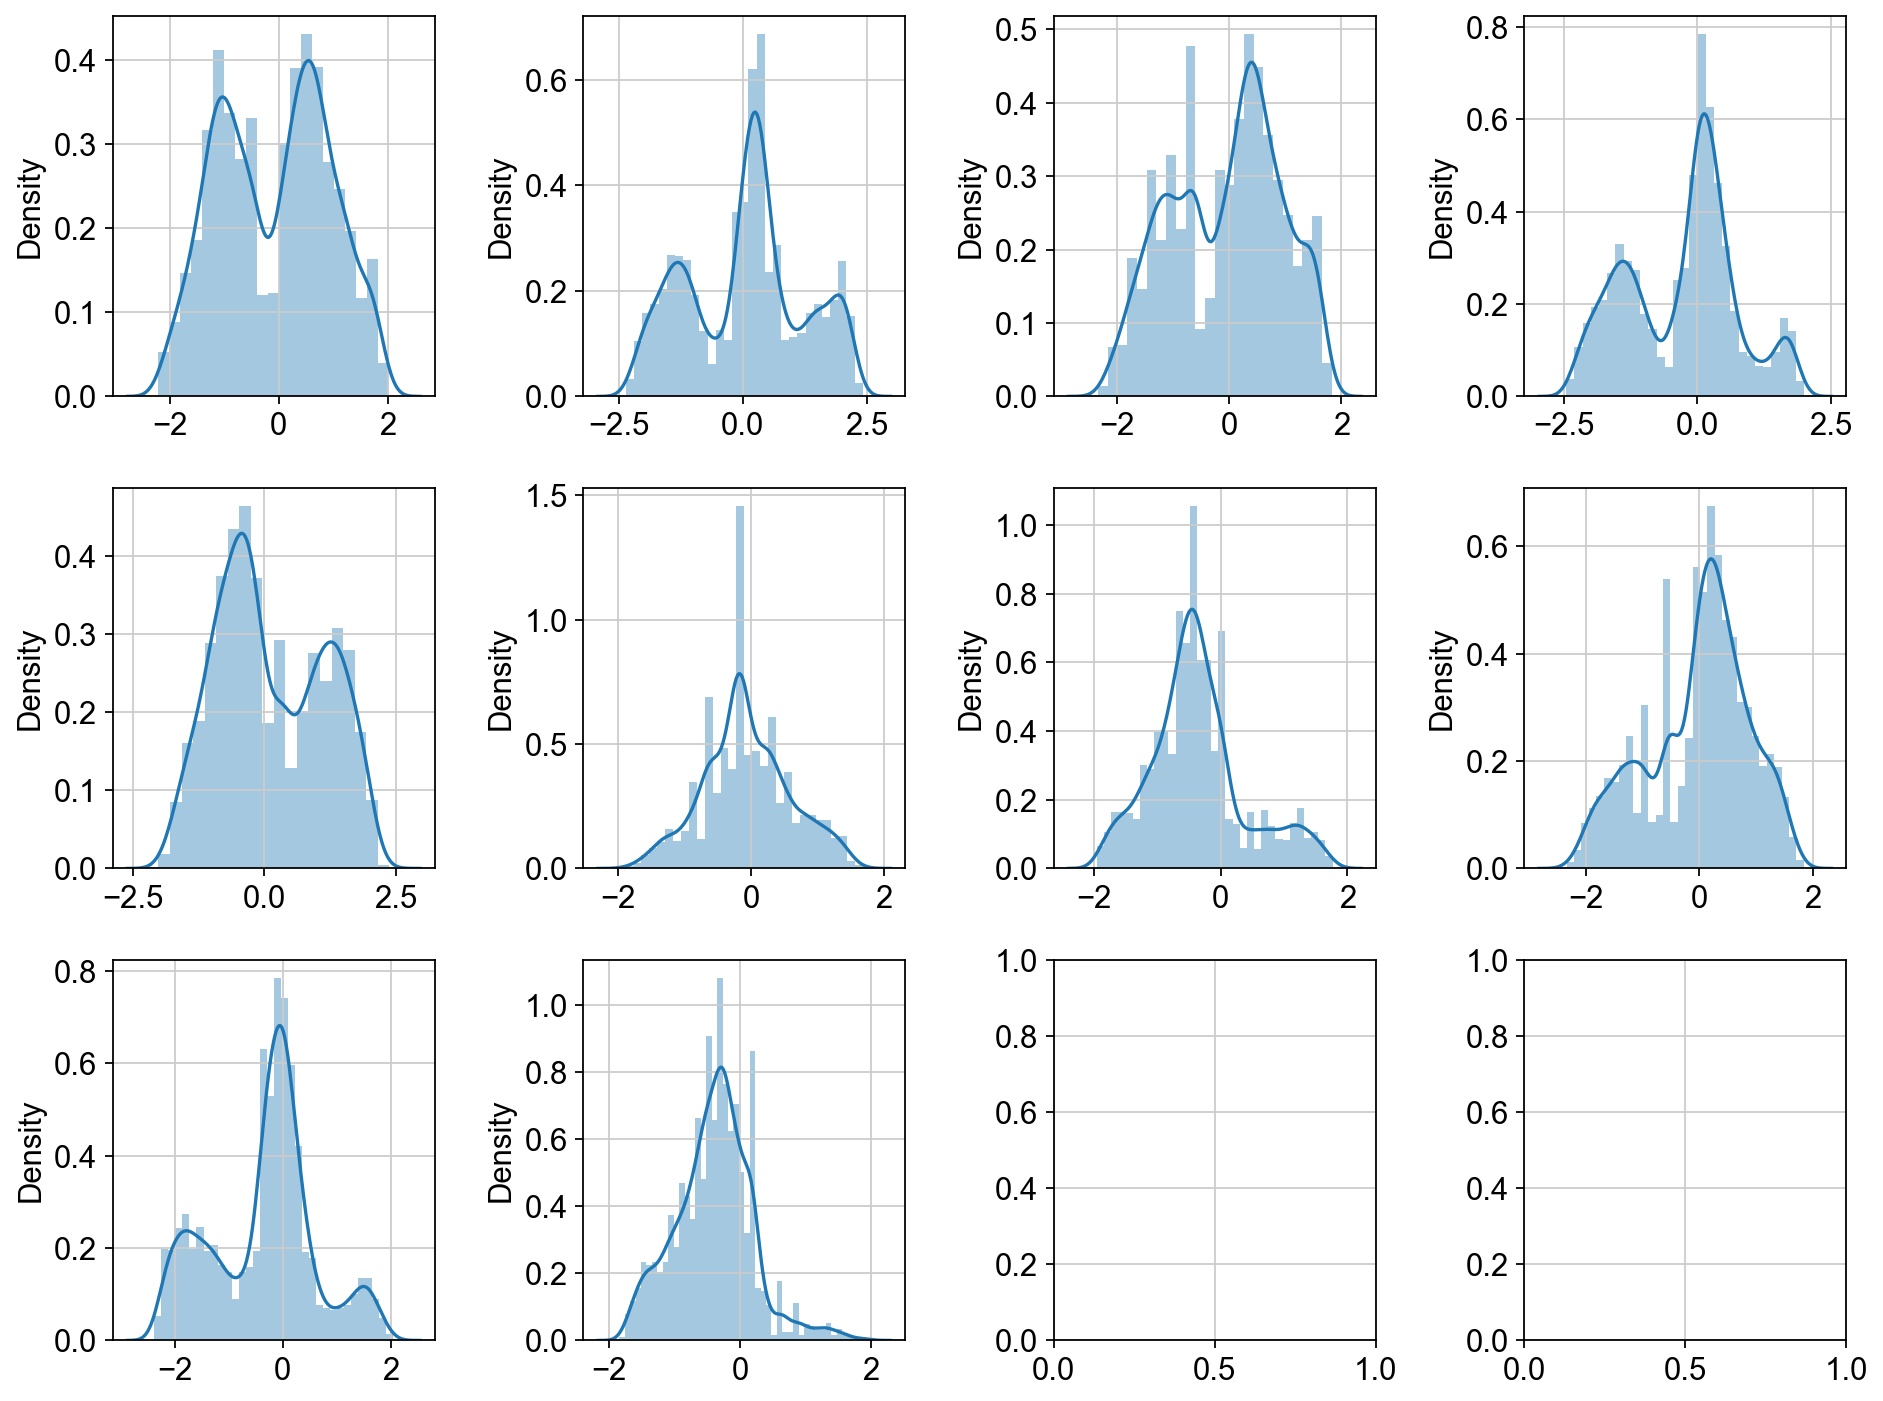

In [18]:
q = 1.
ratios = {}
for i, x in enumerate(constructs):
    for y in constructs[(i+1):]:
        ratios[f"ratio_{x}_{y}"] = [x + "_log", y + "_log"]
ncols = 4
nrows = len(ratios) // ncols + int(len(ratios) % ncols > 0)
for k, v in ratios.items():
    # Set ratio to zero (so that ignored by linear model) if either one is zero:
    x = adata_proc_prediction.obs[v[0]].values
    y = adata_proc_prediction.obs[v[1]].values
    x = np.minimum(x / np.quantile(x, q=q), np.quantile(x, q=q))
    y = np.minimum(y / np.quantile(y, q=q), np.quantile(y, q=q))
    ratio = np.log(x / y)
    ratio[x == 0] = 0
    ratio[y == 0] = 0
    adata_proc_prediction.obs[k] = ratio
    
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*3, nrows*3))
for i, (k, v) in enumerate(ratios.items()):
    j = i % ncols
    i = i // ncols
    sb.distplot(adata_proc_prediction.obs[k].values[
        adata_proc_prediction.obs[k].values != 0], 
                ax=axs[i, j])
plt.tight_layout()
plt.show()

## Coefficient name definitions

In [19]:
coef_conditions = [
    "Ascl1_positive_condition",
    "Foxa2_positive_condition",
    "Myod1_positive_condition",
    "Oct4_positive_condition",
    "Sox2_positive_condition",
]
coef_conditions_interactions = [
    "Ascl1_positive_condition:Foxa2_positive_condition",
    "Ascl1_positive_condition:Myod1_positive_condition",
    "Ascl1_positive_condition:Oct4_positive_condition",
    "Ascl1_positive_condition:Sox2_positive_condition",
    "Foxa2_positive_condition:Myod1_positive_condition",
    "Foxa2_positive_condition:Oct4_positive_condition",
    "Foxa2_positive_condition:Sox2_positive_condition",
    "Myod1_positive_condition:Oct4_positive_condition",
    "Myod1_positive_condition:Sox2_positive_condition",
    "Oct4_positive_condition:Sox2_positive_condition", 
]

In [20]:
coef_factors = [
    x + processing_continuous for x in [
        "Ascl1",
        "Foxa2",
        "Myod1",
        "Oct4",
        "Sox2",
    ]
]

In [21]:
coef_factors_ratios = []
for i, x in enumerate(constructs):
    for y in constructs[(i+1):]:
        coef_factors_ratios.append(f"ratio_{x}_{y}")

## Classification random hold-outs

### Cluster fine grained

In [22]:
evals_categ = {}
estim = fatevision.estimators.Estimator(adata=adata_proc_prediction)
estim.set_y(category="louvain_named")
for k, v in {
    "linear_condition": ["inferred_category_real"],
    #"linear_categorical": coef_conditions,
    "linear_categorical_ratios": coef_conditions+coef_conditions_interactions,
    "linear_cont": coef_factors, 
    "linear_cont_ratios": coef_factors+coef_factors_ratios,
    #"saturating_cont": coef_factors, 
    #"saturating_cont_ratios": coef_factors+coef_factors_ratios, 
    #"nonlinear_cont": coef_factors,
    "nonlinear_cont_ratios": coef_factors+coef_factors_ratios,
}.items():
    formula_batch = "~1+batch"
    formula = "~0+" + "+".join(v)
    as_numeric = []
    if "cont" in k:
        as_numeric += v
    estim.set_x(formula=formula, formula_batch=formula_batch, as_numeric=as_numeric)
    for cv in range(3):
        cv = str(cv)
        if cv not in evals_categ.keys():
            evals_categ[cv] = {}
        estim.split_random(test_split=0.1, seed=int(cv))
        estim.init_model(k)
        epochs = 100 if "nonlinear" in k else 100
        evals_categ[cv][k] = estim.train(epochs=epochs, lr=1., fit_on_full_batches=False, batch_size=64)

2021-11-10 17:00:16.816140: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-10 17:00:16.880646: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


167/167 - 1s - loss: 2.5912 - categorical_accuracy: 0.4139
Epoch 2/100
167/167 - 0s - loss: 2.3884 - categorical_accuracy: 0.4409
Epoch 3/100
167/167 - 0s - loss: 2.2245 - categorical_accuracy: 0.4721
Epoch 4/100
167/167 - 0s - loss: 2.0889 - categorical_accuracy: 0.4826
Epoch 5/100
167/167 - 0s - loss: 1.9756 - categorical_accuracy: 0.5034
Epoch 6/100
167/167 - 0s - loss: 1.8800 - categorical_accuracy: 0.5228
Epoch 7/100
167/167 - 0s - loss: 1.7994 - categorical_accuracy: 0.5308
Epoch 8/100
167/167 - 0s - loss: 1.7315 - categorical_accuracy: 0.5390
Epoch 9/100
167/167 - 0s - loss: 1.6744 - categorical_accuracy: 0.5458
Epoch 10/100
167/167 - 0s - loss: 1.6264 - categorical_accuracy: 0.5468
Epoch 11/100
167/167 - 0s - loss: 1.5861 - categorical_accuracy: 0.5476
Epoch 12/100
167/167 - 0s - loss: 1.5522 - categorical_accuracy: 0.5496
Epoch 13/100
167/167 - 0s - loss: 1.5239 - categorical_accuracy: 0.5496
Epoch 14/100
167/167 - 0s - loss: 1.5001 - categorical_accuracy: 0.5496
Epoch 15/100


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


167/167 - 0s - loss: 2.5911 - categorical_accuracy: 0.4233
Epoch 2/100
167/167 - 0s - loss: 2.3884 - categorical_accuracy: 0.4344
Epoch 3/100
167/167 - 0s - loss: 2.2242 - categorical_accuracy: 0.4612
Epoch 4/100
167/167 - 0s - loss: 2.0884 - categorical_accuracy: 0.4837
Epoch 5/100
167/167 - 0s - loss: 1.9748 - categorical_accuracy: 0.5022
Epoch 6/100
167/167 - 0s - loss: 1.8791 - categorical_accuracy: 0.5209
Epoch 7/100
167/167 - 0s - loss: 1.7982 - categorical_accuracy: 0.5315
Epoch 8/100
167/167 - 0s - loss: 1.7301 - categorical_accuracy: 0.5384
Epoch 9/100
167/167 - 0s - loss: 1.6727 - categorical_accuracy: 0.5502
Epoch 10/100
167/167 - 0s - loss: 1.6245 - categorical_accuracy: 0.5502
Epoch 11/100
167/167 - 0s - loss: 1.5840 - categorical_accuracy: 0.5502
Epoch 12/100
167/167 - 0s - loss: 1.5500 - categorical_accuracy: 0.5502
Epoch 13/100
167/167 - 0s - loss: 1.5215 - categorical_accuracy: 0.5502
Epoch 14/100
167/167 - 0s - loss: 1.4977 - categorical_accuracy: 0.5502
Epoch 15/100


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


167/167 - 0s - loss: 2.5904 - categorical_accuracy: 0.4242
Epoch 2/100
167/167 - 0s - loss: 2.3882 - categorical_accuracy: 0.4457
Epoch 3/100
167/167 - 0s - loss: 2.2253 - categorical_accuracy: 0.4602
Epoch 4/100
167/167 - 0s - loss: 2.0904 - categorical_accuracy: 0.4880
Epoch 5/100
167/167 - 0s - loss: 1.9773 - categorical_accuracy: 0.5006
Epoch 6/100
167/167 - 0s - loss: 1.8819 - categorical_accuracy: 0.5273
Epoch 7/100
167/167 - 0s - loss: 1.8013 - categorical_accuracy: 0.5406
Epoch 8/100
167/167 - 0s - loss: 1.7334 - categorical_accuracy: 0.5457
Epoch 9/100
167/167 - 0s - loss: 1.6762 - categorical_accuracy: 0.5484
Epoch 10/100
167/167 - 0s - loss: 1.6281 - categorical_accuracy: 0.5495
Epoch 11/100
167/167 - 0s - loss: 1.5878 - categorical_accuracy: 0.5495
Epoch 12/100
167/167 - 0s - loss: 1.5540 - categorical_accuracy: 0.5495
Epoch 13/100
167/167 - 0s - loss: 1.5257 - categorical_accuracy: 0.5495
Epoch 14/100
167/167 - 0s - loss: 1.5019 - categorical_accuracy: 0.5495
Epoch 15/100


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


167/167 - 1s - loss: 2.4354 - categorical_accuracy: 0.3880
Epoch 2/100
167/167 - 0s - loss: 2.0881 - categorical_accuracy: 0.4484
Epoch 3/100
167/167 - 0s - loss: 1.9062 - categorical_accuracy: 0.4885
Epoch 4/100
167/167 - 0s - loss: 1.7938 - categorical_accuracy: 0.5062
Epoch 5/100
167/167 - 0s - loss: 1.7161 - categorical_accuracy: 0.5110
Epoch 6/100
167/167 - 0s - loss: 1.6593 - categorical_accuracy: 0.5128
Epoch 7/100
167/167 - 0s - loss: 1.6160 - categorical_accuracy: 0.5204
Epoch 8/100
167/167 - 0s - loss: 1.5820 - categorical_accuracy: 0.5222
Epoch 9/100
167/167 - 0s - loss: 1.5545 - categorical_accuracy: 0.5344
Epoch 10/100
167/167 - 0s - loss: 1.5320 - categorical_accuracy: 0.5319
Epoch 11/100
167/167 - 0s - loss: 1.5135 - categorical_accuracy: 0.5320
Epoch 12/100
167/167 - 0s - loss: 1.4979 - categorical_accuracy: 0.5388
Epoch 13/100
167/167 - 0s - loss: 1.4846 - categorical_accuracy: 0.5444
Epoch 14/100
167/167 - 0s - loss: 1.4733 - categorical_accuracy: 0.5413
Epoch 15/100


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


167/167 - 0s - loss: 2.4314 - categorical_accuracy: 0.4020
Epoch 2/100
167/167 - 0s - loss: 2.0832 - categorical_accuracy: 0.4540
Epoch 3/100
167/167 - 0s - loss: 1.8994 - categorical_accuracy: 0.4893
Epoch 4/100
167/167 - 0s - loss: 1.7866 - categorical_accuracy: 0.5141
Epoch 5/100
167/167 - 0s - loss: 1.7094 - categorical_accuracy: 0.5133
Epoch 6/100
167/167 - 0s - loss: 1.6529 - categorical_accuracy: 0.5147
Epoch 7/100
167/167 - 0s - loss: 1.6099 - categorical_accuracy: 0.5197
Epoch 8/100
167/167 - 0s - loss: 1.5757 - categorical_accuracy: 0.5185
Epoch 9/100
167/167 - 0s - loss: 1.5487 - categorical_accuracy: 0.5282
Epoch 10/100
167/167 - 0s - loss: 1.5263 - categorical_accuracy: 0.5353
Epoch 11/100
167/167 - 0s - loss: 1.5078 - categorical_accuracy: 0.5338
Epoch 12/100
167/167 - 0s - loss: 1.4925 - categorical_accuracy: 0.5404
Epoch 13/100
167/167 - 0s - loss: 1.4794 - categorical_accuracy: 0.5426
Epoch 14/100
167/167 - 0s - loss: 1.4682 - categorical_accuracy: 0.5441
Epoch 15/100


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


167/167 - 0s - loss: 2.4286 - categorical_accuracy: 0.4007
Epoch 2/100
167/167 - 0s - loss: 2.0822 - categorical_accuracy: 0.4496
Epoch 3/100
167/167 - 0s - loss: 1.9009 - categorical_accuracy: 0.4895
Epoch 4/100
167/167 - 0s - loss: 1.7887 - categorical_accuracy: 0.5111
Epoch 5/100
167/167 - 0s - loss: 1.7119 - categorical_accuracy: 0.5102
Epoch 6/100
167/167 - 0s - loss: 1.6556 - categorical_accuracy: 0.5113
Epoch 7/100
167/167 - 0s - loss: 1.6127 - categorical_accuracy: 0.5159
Epoch 8/100
167/167 - 0s - loss: 1.5790 - categorical_accuracy: 0.5261
Epoch 9/100
167/167 - 0s - loss: 1.5518 - categorical_accuracy: 0.5330
Epoch 10/100
167/167 - 0s - loss: 1.5296 - categorical_accuracy: 0.5420
Epoch 11/100
167/167 - 0s - loss: 1.5113 - categorical_accuracy: 0.5387
Epoch 12/100
167/167 - 0s - loss: 1.4959 - categorical_accuracy: 0.5411
Epoch 13/100
167/167 - 0s - loss: 1.4829 - categorical_accuracy: 0.5456
Epoch 14/100
167/167 - 0s - loss: 1.4718 - categorical_accuracy: 0.5471
Epoch 15/100


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


167/167 - 0s - loss: 2.3367 - categorical_accuracy: 0.2861
Epoch 2/100
167/167 - 0s - loss: 1.9177 - categorical_accuracy: 0.4957
Epoch 3/100
167/167 - 0s - loss: 1.6910 - categorical_accuracy: 0.5811
Epoch 4/100
167/167 - 0s - loss: 1.5468 - categorical_accuracy: 0.6081
Epoch 5/100
167/167 - 0s - loss: 1.4473 - categorical_accuracy: 0.6231
Epoch 6/100
167/167 - 0s - loss: 1.3744 - categorical_accuracy: 0.6335
Epoch 7/100
167/167 - 0s - loss: 1.3195 - categorical_accuracy: 0.6383
Epoch 8/100
167/167 - 0s - loss: 1.2763 - categorical_accuracy: 0.6426
Epoch 9/100
167/167 - 0s - loss: 1.2420 - categorical_accuracy: 0.6476
Epoch 10/100
167/167 - 0s - loss: 1.2137 - categorical_accuracy: 0.6508
Epoch 11/100
167/167 - 0s - loss: 1.1902 - categorical_accuracy: 0.6545
Epoch 12/100
167/167 - 0s - loss: 1.1703 - categorical_accuracy: 0.6581
Epoch 13/100
167/167 - 0s - loss: 1.1533 - categorical_accuracy: 0.6590
Epoch 14/100
167/167 - 0s - loss: 1.1387 - categorical_accuracy: 0.6587
Epoch 15/100


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


167/167 - 0s - loss: 2.3314 - categorical_accuracy: 0.2758
Epoch 2/100
167/167 - 0s - loss: 1.9109 - categorical_accuracy: 0.4831
Epoch 3/100
167/167 - 0s - loss: 1.6834 - categorical_accuracy: 0.5788
Epoch 4/100
167/167 - 0s - loss: 1.5385 - categorical_accuracy: 0.6053
Epoch 5/100
167/167 - 0s - loss: 1.4382 - categorical_accuracy: 0.6237
Epoch 6/100
167/167 - 0s - loss: 1.3658 - categorical_accuracy: 0.6333
Epoch 7/100
167/167 - 0s - loss: 1.3108 - categorical_accuracy: 0.6405
Epoch 8/100
167/167 - 0s - loss: 1.2678 - categorical_accuracy: 0.6428
Epoch 9/100
167/167 - 0s - loss: 1.2335 - categorical_accuracy: 0.6471
Epoch 10/100
167/167 - 0s - loss: 1.2055 - categorical_accuracy: 0.6526
Epoch 11/100
167/167 - 0s - loss: 1.1821 - categorical_accuracy: 0.6558
Epoch 12/100
167/167 - 0s - loss: 1.1623 - categorical_accuracy: 0.6567
Epoch 13/100
167/167 - 0s - loss: 1.1452 - categorical_accuracy: 0.6595
Epoch 14/100
167/167 - 0s - loss: 1.1307 - categorical_accuracy: 0.6609
Epoch 15/100


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


167/167 - 0s - loss: 2.3359 - categorical_accuracy: 0.2991
Epoch 2/100
167/167 - 0s - loss: 1.9156 - categorical_accuracy: 0.4916
Epoch 3/100
167/167 - 0s - loss: 1.6881 - categorical_accuracy: 0.5786
Epoch 4/100
167/167 - 0s - loss: 1.5433 - categorical_accuracy: 0.6097
Epoch 5/100
167/167 - 0s - loss: 1.4436 - categorical_accuracy: 0.6238
Epoch 6/100
167/167 - 0s - loss: 1.3710 - categorical_accuracy: 0.6325
Epoch 7/100
167/167 - 0s - loss: 1.3161 - categorical_accuracy: 0.6396
Epoch 8/100
167/167 - 0s - loss: 1.2730 - categorical_accuracy: 0.6448
Epoch 9/100
167/167 - 0s - loss: 1.2384 - categorical_accuracy: 0.6492
Epoch 10/100
167/167 - 0s - loss: 1.2104 - categorical_accuracy: 0.6514
Epoch 11/100
167/167 - 0s - loss: 1.1868 - categorical_accuracy: 0.6558
Epoch 12/100
167/167 - 0s - loss: 1.1670 - categorical_accuracy: 0.6563
Epoch 13/100
167/167 - 0s - loss: 1.1501 - categorical_accuracy: 0.6582
Epoch 14/100
167/167 - 0s - loss: 1.1357 - categorical_accuracy: 0.6607
Epoch 15/100


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


167/167 - 0s - loss: 2.2109 - categorical_accuracy: 0.4277
Epoch 2/100
167/167 - 0s - loss: 1.7093 - categorical_accuracy: 0.5768
Epoch 3/100
167/167 - 0s - loss: 1.4862 - categorical_accuracy: 0.6130
Epoch 4/100
167/167 - 0s - loss: 1.3608 - categorical_accuracy: 0.6220
Epoch 5/100
167/167 - 0s - loss: 1.2817 - categorical_accuracy: 0.6307
Epoch 6/100
167/167 - 0s - loss: 1.2282 - categorical_accuracy: 0.6362
Epoch 7/100
167/167 - 0s - loss: 1.1890 - categorical_accuracy: 0.6400
Epoch 8/100
167/167 - 0s - loss: 1.1597 - categorical_accuracy: 0.6442
Epoch 9/100
167/167 - 0s - loss: 1.1369 - categorical_accuracy: 0.6483
Epoch 10/100
167/167 - 0s - loss: 1.1184 - categorical_accuracy: 0.6496
Epoch 11/100
167/167 - 0s - loss: 1.1032 - categorical_accuracy: 0.6534
Epoch 12/100
167/167 - 0s - loss: 1.0907 - categorical_accuracy: 0.6553
Epoch 13/100
167/167 - 0s - loss: 1.0797 - categorical_accuracy: 0.6590
Epoch 14/100
167/167 - 0s - loss: 1.0702 - categorical_accuracy: 0.6616
Epoch 15/100


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


167/167 - 0s - loss: 2.2085 - categorical_accuracy: 0.4315
Epoch 2/100
167/167 - 0s - loss: 1.7045 - categorical_accuracy: 0.5666
Epoch 3/100
167/167 - 0s - loss: 1.4820 - categorical_accuracy: 0.6141
Epoch 4/100
167/167 - 0s - loss: 1.3564 - categorical_accuracy: 0.6239
Epoch 5/100
167/167 - 0s - loss: 1.2771 - categorical_accuracy: 0.6315
Epoch 6/100
167/167 - 0s - loss: 1.2229 - categorical_accuracy: 0.6351
Epoch 7/100
167/167 - 0s - loss: 1.1841 - categorical_accuracy: 0.6406
Epoch 8/100
167/167 - 0s - loss: 1.1544 - categorical_accuracy: 0.6445
Epoch 9/100
167/167 - 0s - loss: 1.1313 - categorical_accuracy: 0.6493
Epoch 10/100
167/167 - 0s - loss: 1.1131 - categorical_accuracy: 0.6506
Epoch 11/100
167/167 - 0s - loss: 1.0976 - categorical_accuracy: 0.6533
Epoch 12/100
167/167 - 0s - loss: 1.0847 - categorical_accuracy: 0.6557
Epoch 13/100
167/167 - 0s - loss: 1.0741 - categorical_accuracy: 0.6572
Epoch 14/100
167/167 - 0s - loss: 1.0647 - categorical_accuracy: 0.6601
Epoch 15/100


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


167/167 - 1s - loss: 2.2088 - categorical_accuracy: 0.4409
Epoch 2/100
167/167 - 0s - loss: 1.7041 - categorical_accuracy: 0.5714
Epoch 3/100
167/167 - 0s - loss: 1.4822 - categorical_accuracy: 0.6107
Epoch 4/100
167/167 - 0s - loss: 1.3577 - categorical_accuracy: 0.6256
Epoch 5/100
167/167 - 0s - loss: 1.2784 - categorical_accuracy: 0.6306
Epoch 6/100
167/167 - 0s - loss: 1.2252 - categorical_accuracy: 0.6366
Epoch 7/100
167/167 - 0s - loss: 1.1863 - categorical_accuracy: 0.6413
Epoch 8/100
167/167 - 0s - loss: 1.1570 - categorical_accuracy: 0.6457
Epoch 9/100
167/167 - 0s - loss: 1.1342 - categorical_accuracy: 0.6487
Epoch 10/100
167/167 - 0s - loss: 1.1159 - categorical_accuracy: 0.6511
Epoch 11/100
167/167 - 0s - loss: 1.1006 - categorical_accuracy: 0.6546
Epoch 12/100
167/167 - 0s - loss: 1.0879 - categorical_accuracy: 0.6577
Epoch 13/100
167/167 - 0s - loss: 1.0773 - categorical_accuracy: 0.6589
Epoch 14/100
167/167 - 0s - loss: 1.0680 - categorical_accuracy: 0.6608
Epoch 15/100


Epoch 11/100
167/167 - 0s - loss: 0.8508 - categorical_accuracy: 0.7172
Epoch 12/100
167/167 - 0s - loss: 0.8471 - categorical_accuracy: 0.7159
Epoch 13/100
167/167 - 0s - loss: 0.8417 - categorical_accuracy: 0.7167
Epoch 14/100
167/167 - 0s - loss: 0.8377 - categorical_accuracy: 0.7179
Epoch 15/100
167/167 - 0s - loss: 0.8333 - categorical_accuracy: 0.7167
Epoch 16/100
167/167 - 0s - loss: 0.8308 - categorical_accuracy: 0.7196
Epoch 17/100
167/167 - 0s - loss: 0.8253 - categorical_accuracy: 0.7216
Epoch 18/100
167/167 - 0s - loss: 0.8235 - categorical_accuracy: 0.7206
Epoch 19/100
167/167 - 0s - loss: 0.8195 - categorical_accuracy: 0.7248
Epoch 20/100
167/167 - 0s - loss: 0.8178 - categorical_accuracy: 0.7216
Epoch 21/100
167/167 - 0s - loss: 0.8148 - categorical_accuracy: 0.7239
Epoch 22/100
167/167 - 0s - loss: 0.8114 - categorical_accuracy: 0.7261
Epoch 23/100
167/167 - 0s - loss: 0.8099 - categorical_accuracy: 0.7259
Epoch 24/100
167/167 - 0s - loss: 0.8071 - categorical_accuracy:

Epoch 21/100
167/167 - 0s - loss: 0.8116 - categorical_accuracy: 0.7213
Epoch 22/100
167/167 - 0s - loss: 0.8096 - categorical_accuracy: 0.7245
Epoch 23/100
167/167 - 0s - loss: 0.8054 - categorical_accuracy: 0.7207
Epoch 24/100
167/167 - 0s - loss: 0.8070 - categorical_accuracy: 0.7243
Epoch 25/100
167/167 - 0s - loss: 0.8034 - categorical_accuracy: 0.7255
Epoch 26/100
167/167 - 0s - loss: 0.8033 - categorical_accuracy: 0.7234
Epoch 27/100
167/167 - 0s - loss: 0.7998 - categorical_accuracy: 0.7247
Epoch 28/100
167/167 - 0s - loss: 0.7984 - categorical_accuracy: 0.7255
Epoch 29/100
167/167 - 0s - loss: 0.7960 - categorical_accuracy: 0.7282
Epoch 30/100
167/167 - 0s - loss: 0.7932 - categorical_accuracy: 0.7278
Epoch 31/100
167/167 - 0s - loss: 0.7927 - categorical_accuracy: 0.7301
Epoch 32/100
167/167 - 0s - loss: 0.7925 - categorical_accuracy: 0.7270
Epoch 33/100
167/167 - 0s - loss: 0.7903 - categorical_accuracy: 0.7291
Epoch 34/100
167/167 - 0s - loss: 0.7902 - categorical_accuracy:

Epoch 31/100
167/167 - 0s - loss: 0.7991 - categorical_accuracy: 0.7278
Epoch 32/100
167/167 - 0s - loss: 0.7967 - categorical_accuracy: 0.7237
Epoch 33/100
167/167 - 0s - loss: 0.7971 - categorical_accuracy: 0.7276
Epoch 34/100
167/167 - 0s - loss: 0.7945 - categorical_accuracy: 0.7279
Epoch 35/100
167/167 - 0s - loss: 0.7930 - categorical_accuracy: 0.7299
Epoch 36/100
167/167 - 0s - loss: 0.7928 - categorical_accuracy: 0.7287
Epoch 37/100
167/167 - 0s - loss: 0.7904 - categorical_accuracy: 0.7311
Epoch 38/100
167/167 - 0s - loss: 0.7901 - categorical_accuracy: 0.7285
Epoch 39/100
167/167 - 0s - loss: 0.7889 - categorical_accuracy: 0.7304
Epoch 40/100
167/167 - 0s - loss: 0.7858 - categorical_accuracy: 0.7317
Epoch 41/100
167/167 - 0s - loss: 0.7859 - categorical_accuracy: 0.7327
Epoch 42/100
167/167 - 0s - loss: 0.7838 - categorical_accuracy: 0.7288
Epoch 43/100
167/167 - 0s - loss: 0.7819 - categorical_accuracy: 0.7312
Epoch 44/100
167/167 - 0s - loss: 0.7796 - categorical_accuracy:

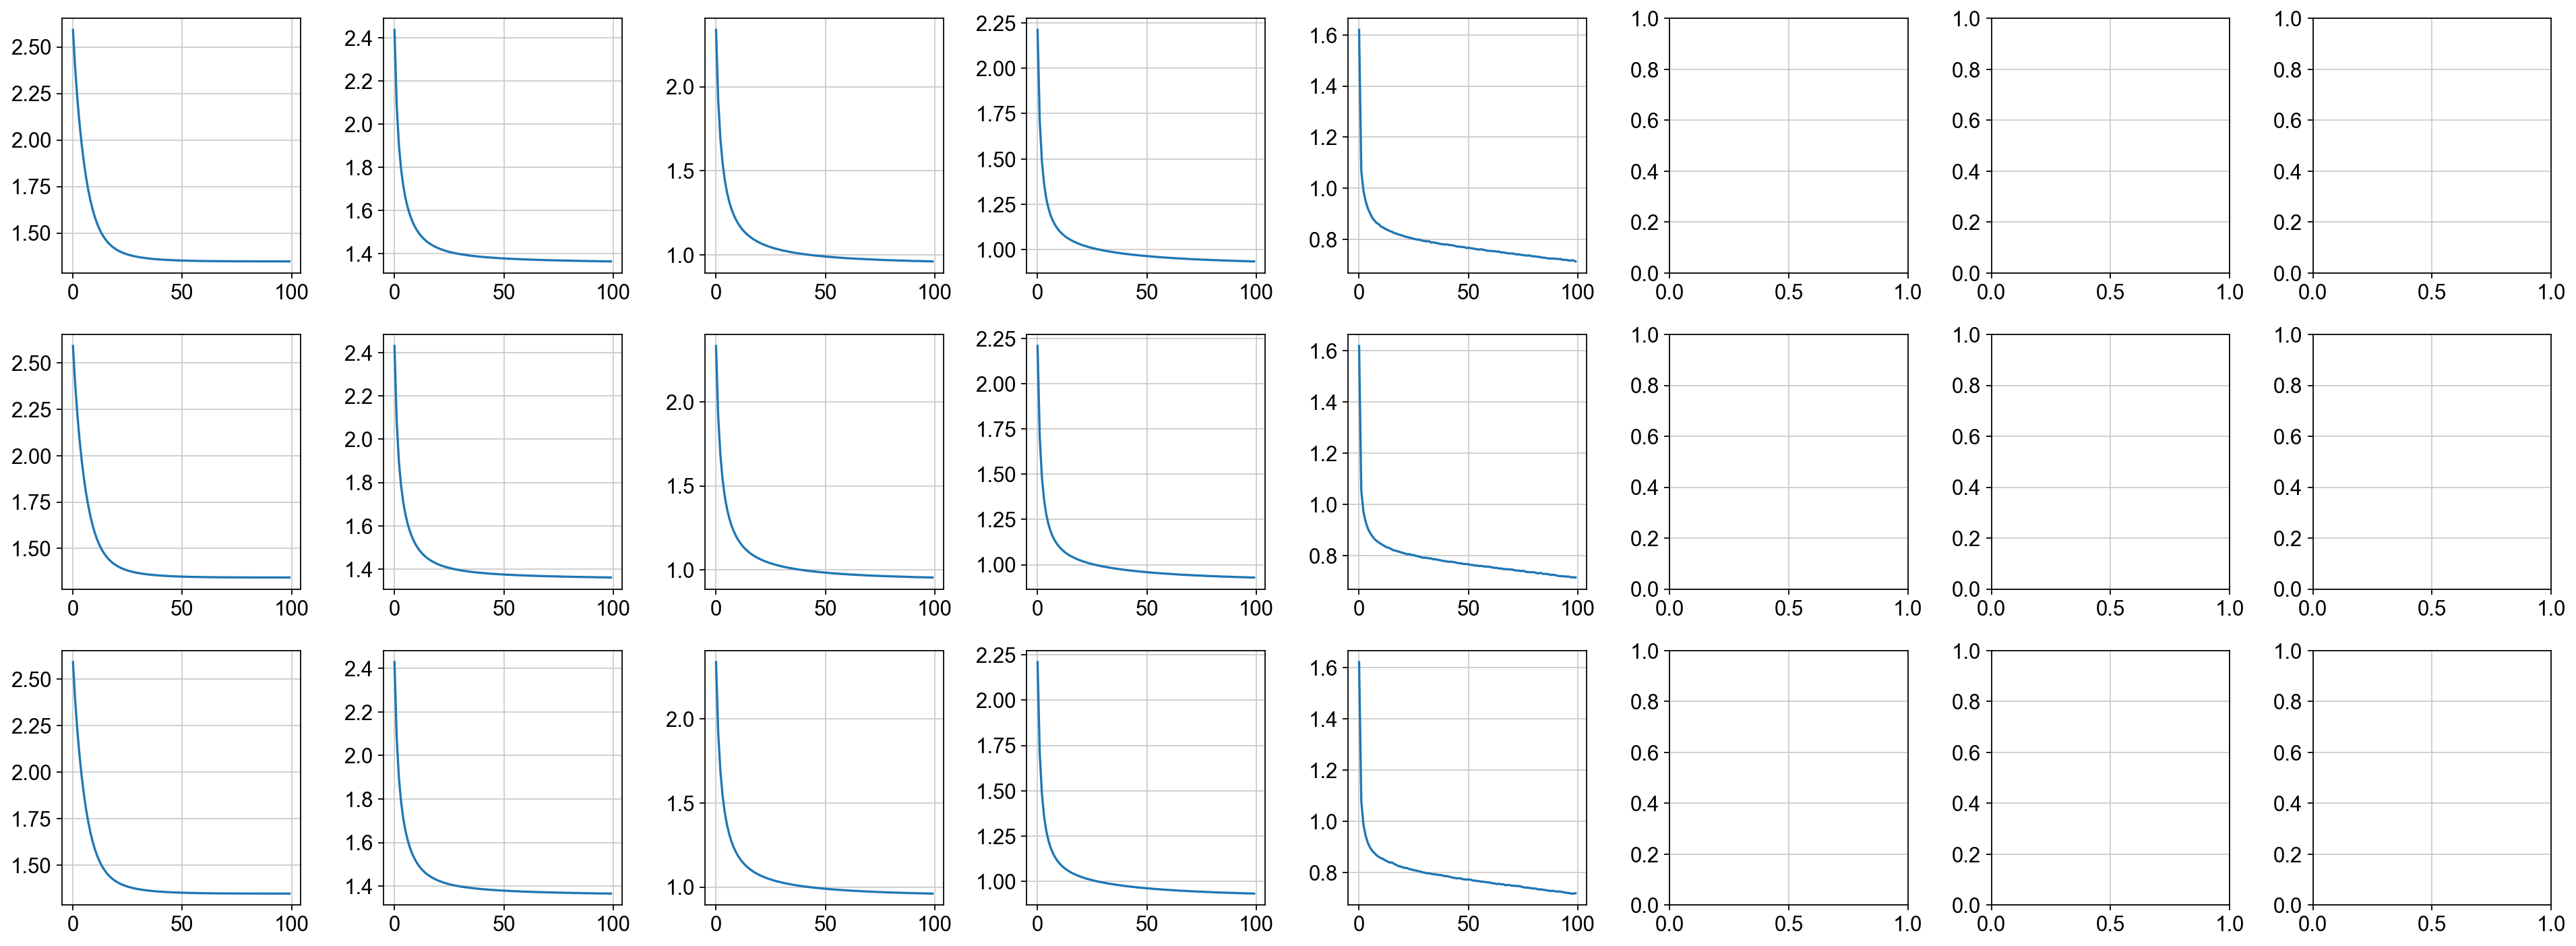

In [23]:
cvs=3
fig, axs = plt.subplots(nrows=cvs, ncols=8, figsize=(8*3, 3*cvs))
for i, (k, v) in  enumerate(evals_categ.items()):
    for j, (kk, vv) in enumerate(v.items()):
        sb.lineplot(data=vv["history"]["loss"], ax=axs[i, j])
plt.tight_layout()
plt.show()

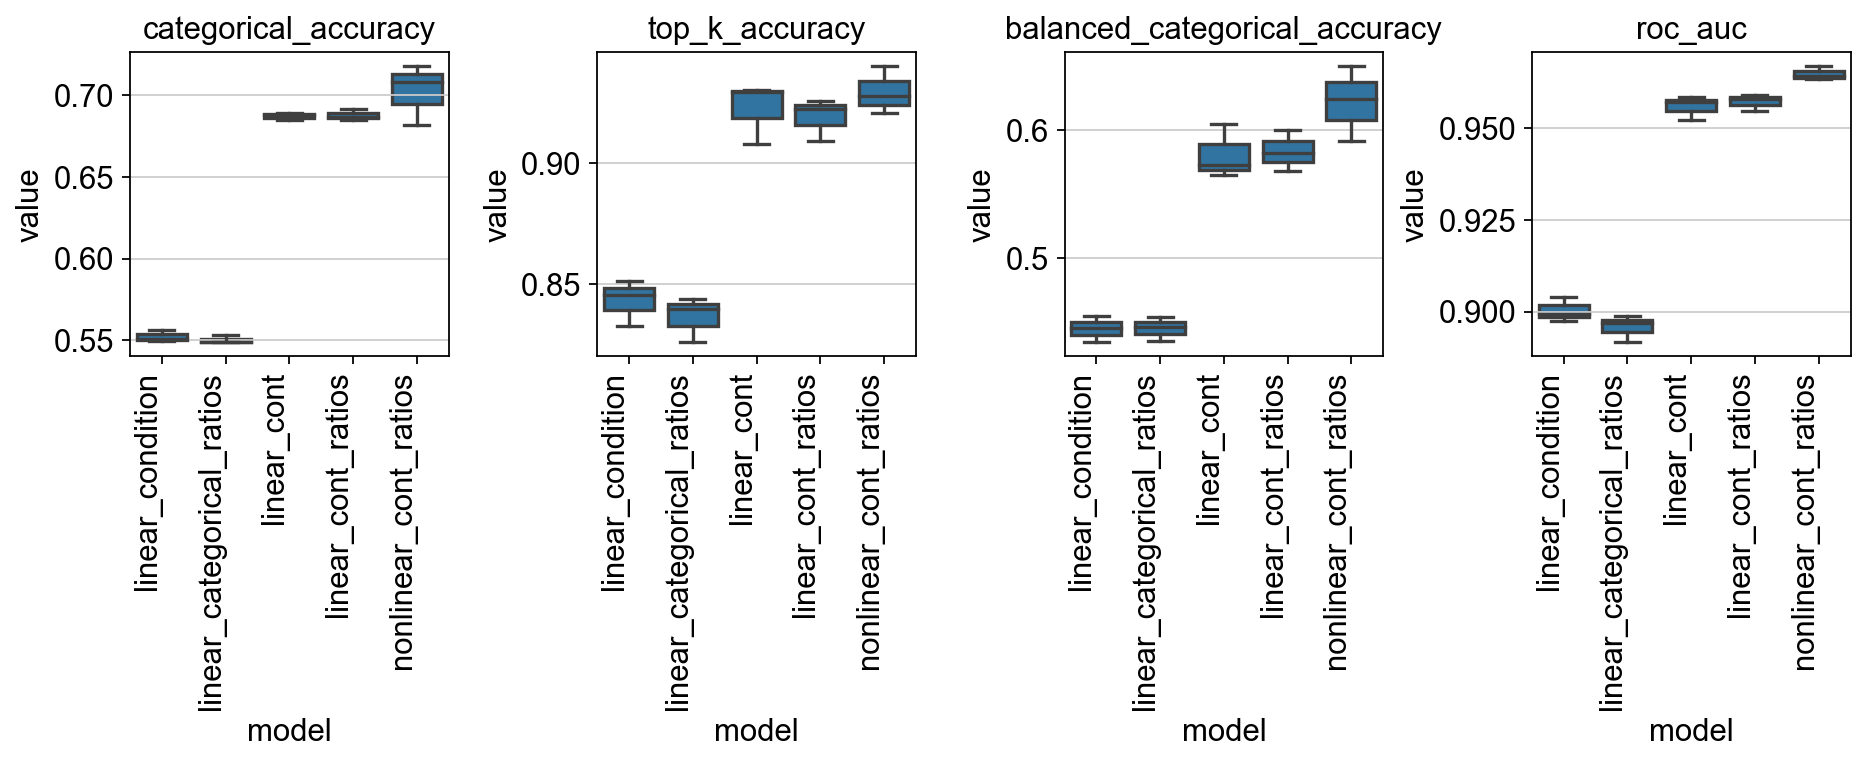

In [57]:
results = \
pd.concat([
    pd.concat([
        pd.concat([
            pd.concat([
                pd.DataFrame(
                    {"cv": k, "value": vvv, "metric": kkk, "partition": p, "model": kk},
                    index=[k+kk+kkk+p]
                )
                for kkk, vvv in vv["evals"][p].items()], axis=0)
            for p in ["test"]], axis=0)
        for kk, vv in v.items()], axis=0)
    for k, v in evals_categ.items()], axis=0)

ncols = 4
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(ncols*3, 5))
for i, x in enumerate(["categorical_accuracy", "top_k_accuracy", "balanced_categorical_accuracy", "roc_auc"]):
    sb.boxplot(data=results.loc[results["metric"].values == x, :], x="model", y="value", 
               hue="partition", ax=ax[i])
    ax[i].set_title(x)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90, ha='right')
    #ax[i].set_ylim([0, 1])
    ax[i].legend_.remove()
plt.tight_layout()
plt.show()

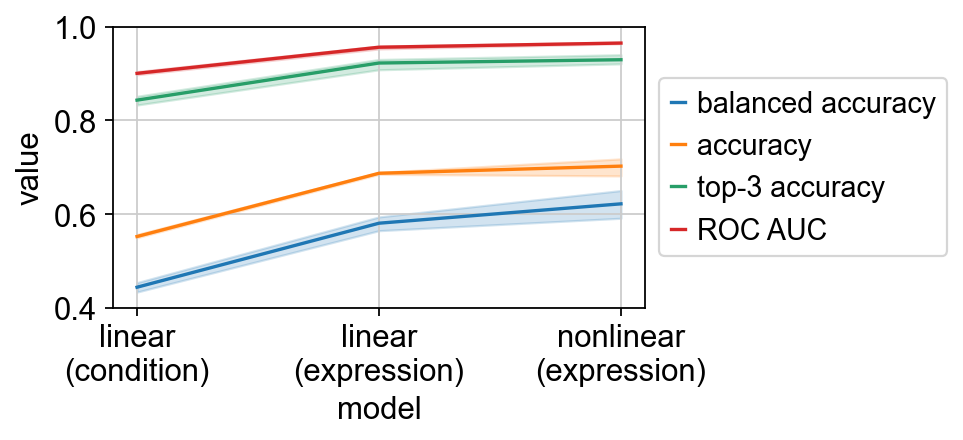

In [58]:
data = results.loc[[x in ["categorical_accuracy", "top_k_accuracy", "balanced_categorical_accuracy", "roc_auc"]
                      for x in results["metric"].values], :]
data = data.loc[[x in ["linear_condition", "linear_cont", "nonlinear_cont_ratios"]
                       for x in data["model"].values], :]
data["model"] = pd.Categorical(
    [{"linear_condition": "linear\n(condition)",
      "linear_cont": "linear\n(expression)", 
      "nonlinear_cont_ratios": "nonlinear\n(expression)", }[x] 
     for x in data["model"].values.tolist()], 
    categories=["linear\n(condition)", "linear\n(expression)", "nonlinear\n(expression)"])
data["metric"] = pd.Categorical(
    [{"categorical_accuracy": "accuracy", 
      "top_k_accuracy": "top-3 accuracy", 
      "balanced_categorical_accuracy": "balanced accuracy", 
      "roc_auc": "ROC AUC"}[x] 
     for x in data["metric"].values.tolist()], 
    categories=["balanced accuracy", "accuracy", "top-3 accuracy", "ROC AUC"])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
sb.lineplot(
    data=data, 
    x="model", y="value", hue="metric", ax=ax)
ax.set_title("")
ax.xaxis.set_tick_params(rotation=0)
ax.set_ylim([0.4, 1])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.95, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(dir_out + "4f.pdf")
plt.show()

In [59]:
data.groupby(["model", "metric"])["value"].mean()

model                    metric           
linear\n(condition)      balanced accuracy    0.444209
                         accuracy             0.552365
                         top-3 accuracy       0.843187
                         ROC AUC              0.900286
linear\n(expression)     balanced accuracy    0.580714
                         accuracy             0.687218
                         top-3 accuracy       0.922297
                         ROC AUC              0.956006
nonlinear\n(expression)  balanced accuracy    0.622031
                         accuracy             0.702421
                         top-3 accuracy       0.929336
                         ROC AUC              0.964860
Name: value, dtype: float64

### Cluster coarse grained (lineage)

In [26]:
evals = {}
estim = fatevision.estimators.Estimator(adata=adata_proc_prediction)
estim.set_y(category="louvain_lineage")
for k, v in {
    "linear_categorical": coef_conditions,
    "linear_categorical_ratios": coef_conditions+coef_conditions_interactions,
    "linear_cont": coef_factors, 
    "linear_cont_ratios": coef_factors+coef_factors_ratios, 
    "saturating_cont": coef_factors, 
    "saturating_cont_ratios": coef_factors+coef_factors_ratios, 
    "nonlinear_cont": coef_factors,
    "nonlinear_cont_ratios": coef_factors+coef_factors_ratios,
}.items():
    formula_batch = "~1+batch"
    formula = "~0+" + "+".join(v)    
    as_numeric = []
    if "cont" in k:
        as_numeric += v
    estim.set_x(formula=formula, formula_batch=formula_batch, as_numeric=as_numeric)
    for cv in range(3):
        cv = str(cv)
        if cv not in evals.keys():
            evals[cv] = {}
        estim.split_random(test_split=0.1, seed=int(cv))
        estim.init_model(k)
        epochs = 500 if "nonlinear" in k else 100
        evals[cv][k] = estim.train(epochs=epochs, lr=1., fit_on_full_batches=False, batch_size=64)

Epoch 1/100


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


167/167 - 1s - loss: 2.5303 - categorical_accuracy: 0.3233
Epoch 2/100
167/167 - 0s - loss: 2.2717 - categorical_accuracy: 0.3700
Epoch 3/100
167/167 - 0s - loss: 2.1026 - categorical_accuracy: 0.4380
Epoch 4/100
167/167 - 0s - loss: 1.9799 - categorical_accuracy: 0.4552
Epoch 5/100
167/167 - 0s - loss: 1.8865 - categorical_accuracy: 0.4863
Epoch 6/100
167/167 - 0s - loss: 1.8133 - categorical_accuracy: 0.5091
Epoch 7/100
167/167 - 0s - loss: 1.7546 - categorical_accuracy: 0.5113
Epoch 8/100
167/167 - 0s - loss: 1.7071 - categorical_accuracy: 0.5098
Epoch 9/100
167/167 - 0s - loss: 1.6679 - categorical_accuracy: 0.5195
Epoch 10/100
167/167 - 0s - loss: 1.6353 - categorical_accuracy: 0.5253
Epoch 11/100
167/167 - 0s - loss: 1.6081 - categorical_accuracy: 0.5261
Epoch 12/100
167/167 - 0s - loss: 1.5846 - categorical_accuracy: 0.5295
Epoch 13/100
167/167 - 0s - loss: 1.5648 - categorical_accuracy: 0.5259
Epoch 14/100
167/167 - 0s - loss: 1.5476 - categorical_accuracy: 0.5336
Epoch 15/100


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


167/167 - 0s - loss: 2.5289 - categorical_accuracy: 0.3178
Epoch 2/100
167/167 - 0s - loss: 2.2708 - categorical_accuracy: 0.3913
Epoch 3/100
167/167 - 0s - loss: 2.1014 - categorical_accuracy: 0.4448
Epoch 4/100
167/167 - 0s - loss: 1.9787 - categorical_accuracy: 0.4554
Epoch 5/100
167/167 - 0s - loss: 1.8848 - categorical_accuracy: 0.4833
Epoch 6/100
167/167 - 0s - loss: 1.8114 - categorical_accuracy: 0.5024
Epoch 7/100
167/167 - 0s - loss: 1.7526 - categorical_accuracy: 0.5110
Epoch 8/100
167/167 - 0s - loss: 1.7048 - categorical_accuracy: 0.5105
Epoch 9/100
167/167 - 0s - loss: 1.6656 - categorical_accuracy: 0.5121
Epoch 10/100
167/167 - 0s - loss: 1.6330 - categorical_accuracy: 0.5193
Epoch 11/100
167/167 - 0s - loss: 1.6056 - categorical_accuracy: 0.5238
Epoch 12/100
167/167 - 0s - loss: 1.5821 - categorical_accuracy: 0.5350
Epoch 13/100
167/167 - 0s - loss: 1.5622 - categorical_accuracy: 0.5244
Epoch 14/100
167/167 - 0s - loss: 1.5450 - categorical_accuracy: 0.5349
Epoch 15/100


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


167/167 - 0s - loss: 2.5309 - categorical_accuracy: 0.3267
Epoch 2/100
167/167 - 0s - loss: 2.2716 - categorical_accuracy: 0.3986
Epoch 3/100
167/167 - 0s - loss: 2.1020 - categorical_accuracy: 0.4382
Epoch 4/100
167/167 - 0s - loss: 1.9791 - categorical_accuracy: 0.4490
Epoch 5/100
167/167 - 0s - loss: 1.8855 - categorical_accuracy: 0.4878
Epoch 6/100
167/167 - 0s - loss: 1.8120 - categorical_accuracy: 0.5037
Epoch 7/100
167/167 - 0s - loss: 1.7533 - categorical_accuracy: 0.5134
Epoch 8/100
167/167 - 0s - loss: 1.7058 - categorical_accuracy: 0.5252
Epoch 9/100
167/167 - 0s - loss: 1.6667 - categorical_accuracy: 0.5282
Epoch 10/100
167/167 - 0s - loss: 1.6343 - categorical_accuracy: 0.5322
Epoch 11/100
167/167 - 0s - loss: 1.6070 - categorical_accuracy: 0.5261
Epoch 12/100
167/167 - 0s - loss: 1.5836 - categorical_accuracy: 0.5351
Epoch 13/100
167/167 - 0s - loss: 1.5638 - categorical_accuracy: 0.5370
Epoch 14/100
167/167 - 0s - loss: 1.5467 - categorical_accuracy: 0.5349
Epoch 15/100


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


167/167 - 0s - loss: 2.4299 - categorical_accuracy: 0.4018
Epoch 2/100
167/167 - 0s - loss: 2.0838 - categorical_accuracy: 0.4542
Epoch 3/100
167/167 - 0s - loss: 1.9025 - categorical_accuracy: 0.4875
Epoch 4/100
167/167 - 0s - loss: 1.7906 - categorical_accuracy: 0.5104
Epoch 5/100
167/167 - 0s - loss: 1.7136 - categorical_accuracy: 0.5086
Epoch 6/100
167/167 - 0s - loss: 1.6573 - categorical_accuracy: 0.5144
Epoch 7/100
167/167 - 0s - loss: 1.6144 - categorical_accuracy: 0.5249
Epoch 8/100
167/167 - 0s - loss: 1.5805 - categorical_accuracy: 0.5251
Epoch 9/100
167/167 - 0s - loss: 1.5533 - categorical_accuracy: 0.5258
Epoch 10/100
167/167 - 0s - loss: 1.5309 - categorical_accuracy: 0.5336
Epoch 11/100
167/167 - 0s - loss: 1.5124 - categorical_accuracy: 0.5408
Epoch 12/100
167/167 - 0s - loss: 1.4968 - categorical_accuracy: 0.5421
Epoch 13/100
167/167 - 0s - loss: 1.4839 - categorical_accuracy: 0.5438
Epoch 14/100
167/167 - 0s - loss: 1.4726 - categorical_accuracy: 0.5453
Epoch 15/100


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


167/167 - 0s - loss: 2.4302 - categorical_accuracy: 0.4061
Epoch 2/100
167/167 - 0s - loss: 2.0816 - categorical_accuracy: 0.4456
Epoch 3/100
167/167 - 0s - loss: 1.8986 - categorical_accuracy: 0.4811
Epoch 4/100
167/167 - 0s - loss: 1.7857 - categorical_accuracy: 0.5123
Epoch 5/100
167/167 - 0s - loss: 1.7083 - categorical_accuracy: 0.5109
Epoch 6/100
167/167 - 0s - loss: 1.6520 - categorical_accuracy: 0.5137
Epoch 7/100
167/167 - 0s - loss: 1.6092 - categorical_accuracy: 0.5171
Epoch 8/100
167/167 - 0s - loss: 1.5754 - categorical_accuracy: 0.5194
Epoch 9/100
167/167 - 0s - loss: 1.5482 - categorical_accuracy: 0.5287
Epoch 10/100
167/167 - 0s - loss: 1.5259 - categorical_accuracy: 0.5305
Epoch 11/100
167/167 - 0s - loss: 1.5076 - categorical_accuracy: 0.5392
Epoch 12/100
167/167 - 0s - loss: 1.4921 - categorical_accuracy: 0.5389
Epoch 13/100
167/167 - 0s - loss: 1.4792 - categorical_accuracy: 0.5428
Epoch 14/100
167/167 - 0s - loss: 1.4680 - categorical_accuracy: 0.5431
Epoch 15/100


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


167/167 - 1s - loss: 2.4337 - categorical_accuracy: 0.3785
Epoch 2/100
167/167 - 0s - loss: 2.0850 - categorical_accuracy: 0.4530
Epoch 3/100
167/167 - 0s - loss: 1.9016 - categorical_accuracy: 0.4870
Epoch 4/100
167/167 - 0s - loss: 1.7889 - categorical_accuracy: 0.5118
Epoch 5/100
167/167 - 0s - loss: 1.7117 - categorical_accuracy: 0.5134
Epoch 6/100
167/167 - 0s - loss: 1.6555 - categorical_accuracy: 0.5118
Epoch 7/100
167/167 - 0s - loss: 1.6126 - categorical_accuracy: 0.5153
Epoch 8/100
167/167 - 0s - loss: 1.5789 - categorical_accuracy: 0.5260
Epoch 9/100
167/167 - 0s - loss: 1.5519 - categorical_accuracy: 0.5322
Epoch 10/100
167/167 - 0s - loss: 1.5297 - categorical_accuracy: 0.5386
Epoch 11/100
167/167 - 0s - loss: 1.5114 - categorical_accuracy: 0.5420
Epoch 12/100
167/167 - 0s - loss: 1.4963 - categorical_accuracy: 0.5453
Epoch 13/100
167/167 - 0s - loss: 1.4832 - categorical_accuracy: 0.5455
Epoch 14/100
167/167 - 0s - loss: 1.4722 - categorical_accuracy: 0.5471
Epoch 15/100


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


167/167 - 0s - loss: 2.3347 - categorical_accuracy: 0.2936
Epoch 2/100
167/167 - 0s - loss: 1.9141 - categorical_accuracy: 0.4950
Epoch 3/100
167/167 - 0s - loss: 1.6879 - categorical_accuracy: 0.5773
Epoch 4/100
167/167 - 0s - loss: 1.5442 - categorical_accuracy: 0.6053
Epoch 5/100
167/167 - 0s - loss: 1.4450 - categorical_accuracy: 0.6257
Epoch 6/100
167/167 - 0s - loss: 1.3729 - categorical_accuracy: 0.6334
Epoch 7/100
167/167 - 0s - loss: 1.3181 - categorical_accuracy: 0.6422
Epoch 8/100
167/167 - 0s - loss: 1.2754 - categorical_accuracy: 0.6433
Epoch 9/100
167/167 - 0s - loss: 1.2409 - categorical_accuracy: 0.6464
Epoch 10/100
167/167 - 0s - loss: 1.2129 - categorical_accuracy: 0.6521
Epoch 11/100
167/167 - 0s - loss: 1.1895 - categorical_accuracy: 0.6531
Epoch 12/100
167/167 - 0s - loss: 1.1696 - categorical_accuracy: 0.6558
Epoch 13/100
167/167 - 0s - loss: 1.1525 - categorical_accuracy: 0.6572
Epoch 14/100
167/167 - 0s - loss: 1.1383 - categorical_accuracy: 0.6608
Epoch 15/100


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


167/167 - 0s - loss: 2.3317 - categorical_accuracy: 0.2963
Epoch 2/100
167/167 - 0s - loss: 1.9088 - categorical_accuracy: 0.4875
Epoch 3/100
167/167 - 0s - loss: 1.6817 - categorical_accuracy: 0.5749
Epoch 4/100
167/167 - 0s - loss: 1.5372 - categorical_accuracy: 0.6101
Epoch 5/100
167/167 - 0s - loss: 1.4380 - categorical_accuracy: 0.6237
Epoch 6/100
167/167 - 0s - loss: 1.3655 - categorical_accuracy: 0.6344
Epoch 7/100
167/167 - 0s - loss: 1.3104 - categorical_accuracy: 0.6393
Epoch 8/100
167/167 - 0s - loss: 1.2676 - categorical_accuracy: 0.6466
Epoch 9/100
167/167 - 0s - loss: 1.2332 - categorical_accuracy: 0.6479
Epoch 10/100
167/167 - 0s - loss: 1.2051 - categorical_accuracy: 0.6515
Epoch 11/100
167/167 - 0s - loss: 1.1819 - categorical_accuracy: 0.6551
Epoch 12/100
167/167 - 0s - loss: 1.1619 - categorical_accuracy: 0.6569
Epoch 13/100
167/167 - 0s - loss: 1.1454 - categorical_accuracy: 0.6588
Epoch 14/100
167/167 - 0s - loss: 1.1309 - categorical_accuracy: 0.6583
Epoch 15/100


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


167/167 - 0s - loss: 2.3383 - categorical_accuracy: 0.2936
Epoch 2/100
167/167 - 0s - loss: 1.9175 - categorical_accuracy: 0.4936
Epoch 3/100
167/167 - 0s - loss: 1.6898 - categorical_accuracy: 0.5801
Epoch 4/100
167/167 - 0s - loss: 1.5446 - categorical_accuracy: 0.6086
Epoch 5/100
167/167 - 0s - loss: 1.4448 - categorical_accuracy: 0.6234
Epoch 6/100
167/167 - 0s - loss: 1.3720 - categorical_accuracy: 0.6323
Epoch 7/100
167/167 - 0s - loss: 1.3167 - categorical_accuracy: 0.6406
Epoch 8/100
167/167 - 0s - loss: 1.2735 - categorical_accuracy: 0.6459
Epoch 9/100
167/167 - 0s - loss: 1.2394 - categorical_accuracy: 0.6488
Epoch 10/100
167/167 - 0s - loss: 1.2109 - categorical_accuracy: 0.6530
Epoch 11/100
167/167 - 0s - loss: 1.1873 - categorical_accuracy: 0.6537
Epoch 12/100
167/167 - 0s - loss: 1.1678 - categorical_accuracy: 0.6553
Epoch 13/100
167/167 - 0s - loss: 1.1507 - categorical_accuracy: 0.6593
Epoch 14/100
167/167 - 0s - loss: 1.1359 - categorical_accuracy: 0.6597
Epoch 15/100


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


167/167 - 0s - loss: 2.2079 - categorical_accuracy: 0.4314
Epoch 2/100
167/167 - 0s - loss: 1.7089 - categorical_accuracy: 0.5686
Epoch 3/100
167/167 - 0s - loss: 1.4869 - categorical_accuracy: 0.6097
Epoch 4/100
167/167 - 0s - loss: 1.3611 - categorical_accuracy: 0.6259
Epoch 5/100
167/167 - 0s - loss: 1.2820 - categorical_accuracy: 0.6308
Epoch 6/100
167/167 - 0s - loss: 1.2278 - categorical_accuracy: 0.6379
Epoch 7/100
167/167 - 0s - loss: 1.1890 - categorical_accuracy: 0.6397
Epoch 8/100
167/167 - 0s - loss: 1.1596 - categorical_accuracy: 0.6443
Epoch 9/100
167/167 - 0s - loss: 1.1368 - categorical_accuracy: 0.6481
Epoch 10/100
167/167 - 0s - loss: 1.1186 - categorical_accuracy: 0.6500
Epoch 11/100
167/167 - 0s - loss: 1.1032 - categorical_accuracy: 0.6548
Epoch 12/100
167/167 - 0s - loss: 1.0908 - categorical_accuracy: 0.6560
Epoch 13/100
167/167 - 0s - loss: 1.0796 - categorical_accuracy: 0.6573
Epoch 14/100
167/167 - 0s - loss: 1.0707 - categorical_accuracy: 0.6604
Epoch 15/100


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


167/167 - 0s - loss: 2.2085 - categorical_accuracy: 0.4293
Epoch 2/100
167/167 - 0s - loss: 1.7044 - categorical_accuracy: 0.5734
Epoch 3/100
167/167 - 0s - loss: 1.4807 - categorical_accuracy: 0.6120
Epoch 4/100
167/167 - 0s - loss: 1.3547 - categorical_accuracy: 0.6236
Epoch 5/100
167/167 - 0s - loss: 1.2759 - categorical_accuracy: 0.6314
Epoch 6/100
167/167 - 0s - loss: 1.2219 - categorical_accuracy: 0.6344
Epoch 7/100
167/167 - 0s - loss: 1.1830 - categorical_accuracy: 0.6438
Epoch 8/100
167/167 - 0s - loss: 1.1536 - categorical_accuracy: 0.6454
Epoch 9/100
167/167 - 0s - loss: 1.1307 - categorical_accuracy: 0.6470
Epoch 10/100
167/167 - 0s - loss: 1.1122 - categorical_accuracy: 0.6504
Epoch 11/100
167/167 - 0s - loss: 1.0970 - categorical_accuracy: 0.6532
Epoch 12/100
167/167 - 0s - loss: 1.0839 - categorical_accuracy: 0.6554
Epoch 13/100
167/167 - 0s - loss: 1.0735 - categorical_accuracy: 0.6568
Epoch 14/100
167/167 - 0s - loss: 1.0639 - categorical_accuracy: 0.6593
Epoch 15/100


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


167/167 - 0s - loss: 2.2133 - categorical_accuracy: 0.4409
Epoch 2/100
167/167 - 0s - loss: 1.7078 - categorical_accuracy: 0.5880
Epoch 3/100
167/167 - 0s - loss: 1.4849 - categorical_accuracy: 0.6136
Epoch 4/100
167/167 - 0s - loss: 1.3590 - categorical_accuracy: 0.6252
Epoch 5/100
167/167 - 0s - loss: 1.2799 - categorical_accuracy: 0.6320
Epoch 6/100
167/167 - 0s - loss: 1.2263 - categorical_accuracy: 0.6364
Epoch 7/100
167/167 - 0s - loss: 1.1873 - categorical_accuracy: 0.6417
Epoch 8/100
167/167 - 0s - loss: 1.1579 - categorical_accuracy: 0.6452
Epoch 9/100
167/167 - 0s - loss: 1.1350 - categorical_accuracy: 0.6492
Epoch 10/100
167/167 - 0s - loss: 1.1166 - categorical_accuracy: 0.6516
Epoch 11/100
167/167 - 0s - loss: 1.1014 - categorical_accuracy: 0.6535
Epoch 12/100
167/167 - 0s - loss: 1.0888 - categorical_accuracy: 0.6553
Epoch 13/100
167/167 - 0s - loss: 1.0779 - categorical_accuracy: 0.6577
Epoch 14/100
167/167 - 0s - loss: 1.0687 - categorical_accuracy: 0.6604
Epoch 15/100


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


167/167 - 0s - loss: 2.6152 - categorical_accuracy: 0.1524
Epoch 2/100
167/167 - 0s - loss: 2.5150 - categorical_accuracy: 0.1464
Epoch 3/100
167/167 - 0s - loss: 2.4571 - categorical_accuracy: 0.2008
Epoch 4/100
167/167 - 0s - loss: 2.3966 - categorical_accuracy: 0.2017
Epoch 5/100
167/167 - 0s - loss: 2.3273 - categorical_accuracy: 0.2180
Epoch 6/100
167/167 - 0s - loss: 2.2503 - categorical_accuracy: 0.2574
Epoch 7/100
167/167 - 0s - loss: 2.1696 - categorical_accuracy: 0.3148
Epoch 8/100
167/167 - 0s - loss: 2.0883 - categorical_accuracy: 0.3579
Epoch 9/100
167/167 - 0s - loss: 2.0094 - categorical_accuracy: 0.4027
Epoch 10/100
167/167 - 0s - loss: 1.9345 - categorical_accuracy: 0.4484
Epoch 11/100
167/167 - 0s - loss: 1.8649 - categorical_accuracy: 0.5042
Epoch 12/100
167/167 - 0s - loss: 1.8004 - categorical_accuracy: 0.5295
Epoch 13/100
167/167 - 0s - loss: 1.7415 - categorical_accuracy: 0.5509
Epoch 14/100
167/167 - 0s - loss: 1.6878 - categorical_accuracy: 0.5711
Epoch 15/100


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


167/167 - 0s - loss: 2.6192 - categorical_accuracy: 0.1594
Epoch 2/100
167/167 - 0s - loss: 2.5007 - categorical_accuracy: 0.1629
Epoch 3/100
167/167 - 0s - loss: 2.4183 - categorical_accuracy: 0.2071
Epoch 4/100
167/167 - 0s - loss: 2.3391 - categorical_accuracy: 0.2874
Epoch 5/100
167/167 - 0s - loss: 2.2583 - categorical_accuracy: 0.3324
Epoch 6/100
167/167 - 0s - loss: 2.1771 - categorical_accuracy: 0.3689
Epoch 7/100
167/167 - 0s - loss: 2.0974 - categorical_accuracy: 0.3805
Epoch 8/100
167/167 - 0s - loss: 2.0198 - categorical_accuracy: 0.4122
Epoch 9/100
167/167 - 0s - loss: 1.9448 - categorical_accuracy: 0.4443
Epoch 10/100
167/167 - 0s - loss: 1.8736 - categorical_accuracy: 0.4881
Epoch 11/100
167/167 - 0s - loss: 1.8059 - categorical_accuracy: 0.5242
Epoch 12/100
167/167 - 0s - loss: 1.7427 - categorical_accuracy: 0.5455
Epoch 13/100
167/167 - 0s - loss: 1.6840 - categorical_accuracy: 0.5602
Epoch 14/100
167/167 - 0s - loss: 1.6302 - categorical_accuracy: 0.5845
Epoch 15/100


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


167/167 - 0s - loss: 2.6314 - categorical_accuracy: 0.2525
Epoch 2/100
167/167 - 0s - loss: 2.5206 - categorical_accuracy: 0.2513
Epoch 3/100
167/167 - 0s - loss: 2.4311 - categorical_accuracy: 0.2885
Epoch 4/100
167/167 - 0s - loss: 2.3379 - categorical_accuracy: 0.3381
Epoch 5/100
167/167 - 0s - loss: 2.2408 - categorical_accuracy: 0.4098
Epoch 6/100
167/167 - 0s - loss: 2.1424 - categorical_accuracy: 0.4680
Epoch 7/100
167/167 - 0s - loss: 2.0456 - categorical_accuracy: 0.5013
Epoch 8/100
167/167 - 0s - loss: 1.9527 - categorical_accuracy: 0.5335
Epoch 9/100
167/167 - 0s - loss: 1.8657 - categorical_accuracy: 0.5476
Epoch 10/100
167/167 - 0s - loss: 1.7856 - categorical_accuracy: 0.5629
Epoch 11/100
167/167 - 0s - loss: 1.7128 - categorical_accuracy: 0.5690
Epoch 12/100
167/167 - 0s - loss: 1.6475 - categorical_accuracy: 0.5806
Epoch 13/100
167/167 - 0s - loss: 1.5895 - categorical_accuracy: 0.5935
Epoch 14/100
167/167 - 0s - loss: 1.5381 - categorical_accuracy: 0.6032
Epoch 15/100


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


167/167 - 0s - loss: 2.5755 - categorical_accuracy: 0.1386
Epoch 2/100
167/167 - 0s - loss: 2.4684 - categorical_accuracy: 0.1480
Epoch 3/100
167/167 - 0s - loss: 2.3725 - categorical_accuracy: 0.2350
Epoch 4/100
167/167 - 0s - loss: 2.2547 - categorical_accuracy: 0.3360
Epoch 5/100
167/167 - 0s - loss: 2.1241 - categorical_accuracy: 0.4075
Epoch 6/100
167/167 - 0s - loss: 1.9927 - categorical_accuracy: 0.4497
Epoch 7/100
167/167 - 0s - loss: 1.8693 - categorical_accuracy: 0.4883
Epoch 8/100
167/167 - 0s - loss: 1.7587 - categorical_accuracy: 0.5338
Epoch 9/100
167/167 - 0s - loss: 1.6618 - categorical_accuracy: 0.5656
Epoch 10/100
167/167 - 0s - loss: 1.5788 - categorical_accuracy: 0.5841
Epoch 11/100
167/167 - 0s - loss: 1.5085 - categorical_accuracy: 0.6010
Epoch 12/100
167/167 - 0s - loss: 1.4490 - categorical_accuracy: 0.6151
Epoch 13/100
167/167 - 0s - loss: 1.3988 - categorical_accuracy: 0.6202
Epoch 14/100
167/167 - 0s - loss: 1.3564 - categorical_accuracy: 0.6251
Epoch 15/100


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


167/167 - 0s - loss: 2.5822 - categorical_accuracy: 0.1547
Epoch 2/100
167/167 - 0s - loss: 2.4849 - categorical_accuracy: 0.1769
Epoch 3/100
167/167 - 0s - loss: 2.4028 - categorical_accuracy: 0.2175
Epoch 4/100
167/167 - 0s - loss: 2.2998 - categorical_accuracy: 0.2869
Epoch 5/100
167/167 - 0s - loss: 2.1800 - categorical_accuracy: 0.3801
Epoch 6/100
167/167 - 0s - loss: 2.0537 - categorical_accuracy: 0.4419
Epoch 7/100
167/167 - 0s - loss: 1.9297 - categorical_accuracy: 0.4865
Epoch 8/100
167/167 - 0s - loss: 1.8149 - categorical_accuracy: 0.5278
Epoch 9/100
167/167 - 0s - loss: 1.7128 - categorical_accuracy: 0.5619
Epoch 10/100
167/167 - 0s - loss: 1.6237 - categorical_accuracy: 0.5898
Epoch 11/100
167/167 - 0s - loss: 1.5475 - categorical_accuracy: 0.6028
Epoch 12/100
167/167 - 0s - loss: 1.4827 - categorical_accuracy: 0.6181
Epoch 13/100
167/167 - 0s - loss: 1.4275 - categorical_accuracy: 0.6251
Epoch 14/100
167/167 - 0s - loss: 1.3805 - categorical_accuracy: 0.6318
Epoch 15/100


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


Gradients do not exist for variables ['var_bias:0'] when minimizing the loss.


167/167 - 0s - loss: 2.5776 - categorical_accuracy: 0.1343
Epoch 2/100
167/167 - 0s - loss: 2.4900 - categorical_accuracy: 0.1623
Epoch 3/100
167/167 - 0s - loss: 2.4170 - categorical_accuracy: 0.2017
Epoch 4/100
167/167 - 0s - loss: 2.3217 - categorical_accuracy: 0.2709
Epoch 5/100
167/167 - 0s - loss: 2.2109 - categorical_accuracy: 0.3549
Epoch 6/100
167/167 - 0s - loss: 2.0951 - categorical_accuracy: 0.4023
Epoch 7/100
167/167 - 0s - loss: 1.9818 - categorical_accuracy: 0.4495
Epoch 8/100
167/167 - 0s - loss: 1.8742 - categorical_accuracy: 0.4889
Epoch 9/100
167/167 - 0s - loss: 1.7745 - categorical_accuracy: 0.5212
Epoch 10/100
167/167 - 0s - loss: 1.6834 - categorical_accuracy: 0.5576
Epoch 11/100
167/167 - 0s - loss: 1.6029 - categorical_accuracy: 0.5870
Epoch 12/100
167/167 - 0s - loss: 1.5317 - categorical_accuracy: 0.6065
Epoch 13/100
167/167 - 0s - loss: 1.4706 - categorical_accuracy: 0.6229
Epoch 14/100
167/167 - 0s - loss: 1.4181 - categorical_accuracy: 0.6250
Epoch 15/100


Epoch 11/500
167/167 - 0s - loss: 0.8586 - categorical_accuracy: 0.7115
Epoch 12/500
167/167 - 0s - loss: 0.8540 - categorical_accuracy: 0.7160
Epoch 13/500
167/167 - 0s - loss: 0.8473 - categorical_accuracy: 0.7179
Epoch 14/500
167/167 - 0s - loss: 0.8444 - categorical_accuracy: 0.7175
Epoch 15/500
167/167 - 0s - loss: 0.8411 - categorical_accuracy: 0.7203
Epoch 16/500
167/167 - 0s - loss: 0.8364 - categorical_accuracy: 0.7177
Epoch 17/500
167/167 - 0s - loss: 0.8363 - categorical_accuracy: 0.7176
Epoch 18/500
167/167 - 0s - loss: 0.8301 - categorical_accuracy: 0.7208
Epoch 19/500
167/167 - 0s - loss: 0.8280 - categorical_accuracy: 0.7197
Epoch 20/500
167/167 - 0s - loss: 0.8258 - categorical_accuracy: 0.7207
Epoch 21/500
167/167 - 0s - loss: 0.8236 - categorical_accuracy: 0.7221
Epoch 22/500
167/167 - 0s - loss: 0.8212 - categorical_accuracy: 0.7200
Epoch 23/500
167/167 - 0s - loss: 0.8194 - categorical_accuracy: 0.7215
Epoch 24/500
167/167 - 0s - loss: 0.8175 - categorical_accuracy:

Epoch 125/500
167/167 - 0s - loss: 0.7303 - categorical_accuracy: 0.7428
Epoch 126/500
167/167 - 0s - loss: 0.7302 - categorical_accuracy: 0.7455
Epoch 127/500
167/167 - 0s - loss: 0.7292 - categorical_accuracy: 0.7463
Epoch 128/500
167/167 - 0s - loss: 0.7286 - categorical_accuracy: 0.7451
Epoch 129/500
167/167 - 0s - loss: 0.7272 - categorical_accuracy: 0.7442
Epoch 130/500
167/167 - 0s - loss: 0.7269 - categorical_accuracy: 0.7441
Epoch 131/500
167/167 - 0s - loss: 0.7267 - categorical_accuracy: 0.7442
Epoch 132/500
167/167 - 0s - loss: 0.7288 - categorical_accuracy: 0.7425
Epoch 133/500
167/167 - 0s - loss: 0.7285 - categorical_accuracy: 0.7453
Epoch 134/500
167/167 - 0s - loss: 0.7255 - categorical_accuracy: 0.7461
Epoch 135/500
167/167 - 0s - loss: 0.7250 - categorical_accuracy: 0.7442
Epoch 136/500
167/167 - 0s - loss: 0.7254 - categorical_accuracy: 0.7448
Epoch 137/500
167/167 - 0s - loss: 0.7241 - categorical_accuracy: 0.7461
Epoch 138/500
167/167 - 0s - loss: 0.7241 - categor

Epoch 238/500
167/167 - 0s - loss: 0.6734 - categorical_accuracy: 0.7605
Epoch 239/500
167/167 - 0s - loss: 0.6702 - categorical_accuracy: 0.7612
Epoch 240/500
167/167 - 0s - loss: 0.6701 - categorical_accuracy: 0.7638
Epoch 241/500
167/167 - 0s - loss: 0.6703 - categorical_accuracy: 0.7640
Epoch 242/500
167/167 - 0s - loss: 0.6711 - categorical_accuracy: 0.7615
Epoch 243/500
167/167 - 0s - loss: 0.6695 - categorical_accuracy: 0.7619
Epoch 244/500
167/167 - 0s - loss: 0.6687 - categorical_accuracy: 0.7610
Epoch 245/500
167/167 - 0s - loss: 0.6691 - categorical_accuracy: 0.7616
Epoch 246/500
167/167 - 0s - loss: 0.6676 - categorical_accuracy: 0.7616
Epoch 247/500
167/167 - 0s - loss: 0.6682 - categorical_accuracy: 0.7621
Epoch 248/500
167/167 - 0s - loss: 0.6659 - categorical_accuracy: 0.7630
Epoch 249/500
167/167 - 0s - loss: 0.6662 - categorical_accuracy: 0.7621
Epoch 250/500
167/167 - 0s - loss: 0.6654 - categorical_accuracy: 0.7605
Epoch 251/500
167/167 - 0s - loss: 0.6655 - categor

Epoch 351/500
167/167 - 0s - loss: 0.6228 - categorical_accuracy: 0.7768
Epoch 352/500
167/167 - 0s - loss: 0.6230 - categorical_accuracy: 0.7798
Epoch 353/500
167/167 - 0s - loss: 0.6221 - categorical_accuracy: 0.7792
Epoch 354/500
167/167 - 0s - loss: 0.6220 - categorical_accuracy: 0.7789
Epoch 355/500
167/167 - 0s - loss: 0.6224 - categorical_accuracy: 0.7805
Epoch 356/500
167/167 - 0s - loss: 0.6217 - categorical_accuracy: 0.7795
Epoch 357/500
167/167 - 0s - loss: 0.6209 - categorical_accuracy: 0.7780
Epoch 358/500
167/167 - 0s - loss: 0.6217 - categorical_accuracy: 0.7783
Epoch 359/500
167/167 - 0s - loss: 0.6204 - categorical_accuracy: 0.7781
Epoch 360/500
167/167 - 0s - loss: 0.6184 - categorical_accuracy: 0.7807
Epoch 361/500
167/167 - 0s - loss: 0.6199 - categorical_accuracy: 0.7799
Epoch 362/500
167/167 - 0s - loss: 0.6193 - categorical_accuracy: 0.7792
Epoch 363/500
167/167 - 0s - loss: 0.6187 - categorical_accuracy: 0.7816
Epoch 364/500
167/167 - 0s - loss: 0.6181 - categor

Epoch 464/500
167/167 - 0s - loss: 0.5814 - categorical_accuracy: 0.7890
Epoch 465/500
167/167 - 0s - loss: 0.5815 - categorical_accuracy: 0.7924
Epoch 466/500
167/167 - 0s - loss: 0.5810 - categorical_accuracy: 0.7915
Epoch 467/500
167/167 - 0s - loss: 0.5795 - categorical_accuracy: 0.7924
Epoch 468/500
167/167 - 0s - loss: 0.5799 - categorical_accuracy: 0.7911
Epoch 469/500
167/167 - 0s - loss: 0.5804 - categorical_accuracy: 0.7920
Epoch 470/500
167/167 - 0s - loss: 0.5790 - categorical_accuracy: 0.7945
Epoch 471/500
167/167 - 0s - loss: 0.5783 - categorical_accuracy: 0.7929
Epoch 472/500
167/167 - 0s - loss: 0.5771 - categorical_accuracy: 0.7923
Epoch 473/500
167/167 - 0s - loss: 0.5784 - categorical_accuracy: 0.7915
Epoch 474/500
167/167 - 0s - loss: 0.5774 - categorical_accuracy: 0.7934
Epoch 475/500
167/167 - 0s - loss: 0.5774 - categorical_accuracy: 0.7919
Epoch 476/500
167/167 - 0s - loss: 0.5767 - categorical_accuracy: 0.7927
Epoch 477/500
167/167 - 0s - loss: 0.5761 - categor

167/167 - 0s - loss: 0.7681 - categorical_accuracy: 0.7332
Epoch 74/500
167/167 - 0s - loss: 0.7669 - categorical_accuracy: 0.7314
Epoch 75/500
167/167 - 0s - loss: 0.7660 - categorical_accuracy: 0.7312
Epoch 76/500
167/167 - 0s - loss: 0.7651 - categorical_accuracy: 0.7336
Epoch 77/500
167/167 - 0s - loss: 0.7634 - categorical_accuracy: 0.7321
Epoch 78/500
167/167 - 0s - loss: 0.7649 - categorical_accuracy: 0.7325
Epoch 79/500
167/167 - 0s - loss: 0.7632 - categorical_accuracy: 0.7332
Epoch 80/500
167/167 - 0s - loss: 0.7622 - categorical_accuracy: 0.7327
Epoch 81/500
167/167 - 0s - loss: 0.7624 - categorical_accuracy: 0.7333
Epoch 82/500
167/167 - 0s - loss: 0.7607 - categorical_accuracy: 0.7352
Epoch 83/500
167/167 - 0s - loss: 0.7630 - categorical_accuracy: 0.7317
Epoch 84/500
167/167 - 0s - loss: 0.7602 - categorical_accuracy: 0.7315
Epoch 85/500
167/167 - 0s - loss: 0.7597 - categorical_accuracy: 0.7323
Epoch 86/500
167/167 - 0s - loss: 0.7598 - categorical_accuracy: 0.7350
Epoch

Epoch 186/500
167/167 - 0s - loss: 0.7053 - categorical_accuracy: 0.7488
Epoch 187/500
167/167 - 0s - loss: 0.7043 - categorical_accuracy: 0.7525
Epoch 188/500
167/167 - 0s - loss: 0.7033 - categorical_accuracy: 0.7516
Epoch 189/500
167/167 - 0s - loss: 0.7042 - categorical_accuracy: 0.7497
Epoch 190/500
167/167 - 0s - loss: 0.7042 - categorical_accuracy: 0.7515
Epoch 191/500
167/167 - 0s - loss: 0.7027 - categorical_accuracy: 0.7517
Epoch 192/500
167/167 - 0s - loss: 0.7023 - categorical_accuracy: 0.7532
Epoch 193/500
167/167 - 0s - loss: 0.7014 - categorical_accuracy: 0.7528
Epoch 194/500
167/167 - 0s - loss: 0.7018 - categorical_accuracy: 0.7542
Epoch 195/500
167/167 - 0s - loss: 0.7003 - categorical_accuracy: 0.7519
Epoch 196/500
167/167 - 0s - loss: 0.6997 - categorical_accuracy: 0.7557
Epoch 197/500
167/167 - 0s - loss: 0.6992 - categorical_accuracy: 0.7542
Epoch 198/500
167/167 - 0s - loss: 0.7002 - categorical_accuracy: 0.7518
Epoch 199/500
167/167 - 0s - loss: 0.6984 - categor

Epoch 299/500
167/167 - 0s - loss: 0.6532 - categorical_accuracy: 0.7677
Epoch 300/500
167/167 - 0s - loss: 0.6520 - categorical_accuracy: 0.7664
Epoch 301/500
167/167 - 0s - loss: 0.6488 - categorical_accuracy: 0.7662
Epoch 302/500
167/167 - 0s - loss: 0.6502 - categorical_accuracy: 0.7686
Epoch 303/500
167/167 - 0s - loss: 0.6510 - categorical_accuracy: 0.7677
Epoch 304/500
167/167 - 0s - loss: 0.6504 - categorical_accuracy: 0.7671
Epoch 305/500
167/167 - 0s - loss: 0.6492 - categorical_accuracy: 0.7693
Epoch 306/500
167/167 - 0s - loss: 0.6502 - categorical_accuracy: 0.7654
Epoch 307/500
167/167 - 0s - loss: 0.6486 - categorical_accuracy: 0.7681
Epoch 308/500
167/167 - 0s - loss: 0.6496 - categorical_accuracy: 0.7661
Epoch 309/500
167/167 - 0s - loss: 0.6467 - categorical_accuracy: 0.7702
Epoch 310/500
167/167 - 0s - loss: 0.6471 - categorical_accuracy: 0.7677
Epoch 311/500
167/167 - 0s - loss: 0.6465 - categorical_accuracy: 0.7673
Epoch 312/500
167/167 - 0s - loss: 0.6468 - categor

Epoch 412/500
167/167 - 0s - loss: 0.6039 - categorical_accuracy: 0.7824
Epoch 413/500
167/167 - 0s - loss: 0.6039 - categorical_accuracy: 0.7843
Epoch 414/500
167/167 - 0s - loss: 0.6023 - categorical_accuracy: 0.7843
Epoch 415/500
167/167 - 0s - loss: 0.6049 - categorical_accuracy: 0.7820
Epoch 416/500
167/167 - 0s - loss: 0.6039 - categorical_accuracy: 0.7841
Epoch 417/500
167/167 - 0s - loss: 0.6027 - categorical_accuracy: 0.7809
Epoch 418/500
167/167 - 0s - loss: 0.6012 - categorical_accuracy: 0.7840
Epoch 419/500
167/167 - 0s - loss: 0.6011 - categorical_accuracy: 0.7834
Epoch 420/500
167/167 - 0s - loss: 0.6019 - categorical_accuracy: 0.7799
Epoch 421/500
167/167 - 0s - loss: 0.6005 - categorical_accuracy: 0.7821
Epoch 422/500
167/167 - 0s - loss: 0.5997 - categorical_accuracy: 0.7846
Epoch 423/500
167/167 - 0s - loss: 0.5990 - categorical_accuracy: 0.7860
Epoch 424/500
167/167 - 0s - loss: 0.5990 - categorical_accuracy: 0.7832
Epoch 425/500
167/167 - 0s - loss: 0.5988 - categor

Epoch 21/500
167/167 - 0s - loss: 0.8277 - categorical_accuracy: 0.7185
Epoch 22/500
167/167 - 0s - loss: 0.8233 - categorical_accuracy: 0.7205
Epoch 23/500
167/167 - 0s - loss: 0.8231 - categorical_accuracy: 0.7216
Epoch 24/500
167/167 - 0s - loss: 0.8218 - categorical_accuracy: 0.7214
Epoch 25/500
167/167 - 0s - loss: 0.8197 - categorical_accuracy: 0.7207
Epoch 26/500
167/167 - 0s - loss: 0.8182 - categorical_accuracy: 0.7228
Epoch 27/500
167/167 - 0s - loss: 0.8156 - categorical_accuracy: 0.7237
Epoch 28/500
167/167 - 0s - loss: 0.8155 - categorical_accuracy: 0.7209
Epoch 29/500
167/167 - 0s - loss: 0.8131 - categorical_accuracy: 0.7258
Epoch 30/500
167/167 - 0s - loss: 0.8107 - categorical_accuracy: 0.7219
Epoch 31/500
167/167 - 0s - loss: 0.8108 - categorical_accuracy: 0.7237
Epoch 32/500
167/167 - 0s - loss: 0.8088 - categorical_accuracy: 0.7238
Epoch 33/500
167/167 - 0s - loss: 0.8079 - categorical_accuracy: 0.7223
Epoch 34/500
167/167 - 0s - loss: 0.8067 - categorical_accuracy:

Epoch 135/500
167/167 - 0s - loss: 0.7335 - categorical_accuracy: 0.7431
Epoch 136/500
167/167 - 0s - loss: 0.7340 - categorical_accuracy: 0.7401
Epoch 137/500
167/167 - 0s - loss: 0.7316 - categorical_accuracy: 0.7428
Epoch 138/500
167/167 - 0s - loss: 0.7320 - categorical_accuracy: 0.7383
Epoch 139/500
167/167 - 0s - loss: 0.7309 - categorical_accuracy: 0.7404
Epoch 140/500
167/167 - 0s - loss: 0.7329 - categorical_accuracy: 0.7418
Epoch 141/500
167/167 - 0s - loss: 0.7307 - categorical_accuracy: 0.7409
Epoch 142/500
167/167 - 0s - loss: 0.7309 - categorical_accuracy: 0.7411
Epoch 143/500
167/167 - 0s - loss: 0.7289 - categorical_accuracy: 0.7412
Epoch 144/500
167/167 - 0s - loss: 0.7303 - categorical_accuracy: 0.7406
Epoch 145/500
167/167 - 0s - loss: 0.7277 - categorical_accuracy: 0.7396
Epoch 146/500
167/167 - 0s - loss: 0.7274 - categorical_accuracy: 0.7421
Epoch 147/500
167/167 - 0s - loss: 0.7269 - categorical_accuracy: 0.7436
Epoch 148/500
167/167 - 0s - loss: 0.7281 - categor

Epoch 248/500
167/167 - 0s - loss: 0.6736 - categorical_accuracy: 0.7630
Epoch 249/500
167/167 - 0s - loss: 0.6729 - categorical_accuracy: 0.7601
Epoch 250/500
167/167 - 0s - loss: 0.6734 - categorical_accuracy: 0.7593
Epoch 251/500
167/167 - 0s - loss: 0.6722 - categorical_accuracy: 0.7612
Epoch 252/500
167/167 - 0s - loss: 0.6722 - categorical_accuracy: 0.7594
Epoch 253/500
167/167 - 0s - loss: 0.6713 - categorical_accuracy: 0.7609
Epoch 254/500
167/167 - 0s - loss: 0.6718 - categorical_accuracy: 0.7612
Epoch 255/500
167/167 - 0s - loss: 0.6697 - categorical_accuracy: 0.7636
Epoch 256/500
167/167 - 0s - loss: 0.6702 - categorical_accuracy: 0.7615
Epoch 257/500
167/167 - 0s - loss: 0.6696 - categorical_accuracy: 0.7613
Epoch 258/500
167/167 - 0s - loss: 0.6691 - categorical_accuracy: 0.7663
Epoch 259/500
167/167 - 0s - loss: 0.6683 - categorical_accuracy: 0.7628
Epoch 260/500
167/167 - 0s - loss: 0.6680 - categorical_accuracy: 0.7624
Epoch 261/500
167/167 - 0s - loss: 0.6682 - categor

Epoch 361/500
167/167 - 0s - loss: 0.6196 - categorical_accuracy: 0.7786
Epoch 362/500
167/167 - 0s - loss: 0.6191 - categorical_accuracy: 0.7782
Epoch 363/500
167/167 - 0s - loss: 0.6177 - categorical_accuracy: 0.7800
Epoch 364/500
167/167 - 0s - loss: 0.6191 - categorical_accuracy: 0.7782
Epoch 365/500
167/167 - 0s - loss: 0.6185 - categorical_accuracy: 0.7781
Epoch 366/500
167/167 - 0s - loss: 0.6182 - categorical_accuracy: 0.7784
Epoch 367/500
167/167 - 0s - loss: 0.6157 - categorical_accuracy: 0.7784
Epoch 368/500
167/167 - 0s - loss: 0.6190 - categorical_accuracy: 0.7792
Epoch 369/500
167/167 - 0s - loss: 0.6163 - categorical_accuracy: 0.7792
Epoch 370/500
167/167 - 0s - loss: 0.6164 - categorical_accuracy: 0.7786
Epoch 371/500
167/167 - 0s - loss: 0.6138 - categorical_accuracy: 0.7808
Epoch 372/500
167/167 - 0s - loss: 0.6151 - categorical_accuracy: 0.7817
Epoch 373/500
167/167 - 0s - loss: 0.6144 - categorical_accuracy: 0.7796
Epoch 374/500
167/167 - 0s - loss: 0.6158 - categor

Epoch 474/500
167/167 - 0s - loss: 0.5753 - categorical_accuracy: 0.7944
Epoch 475/500
167/167 - 0s - loss: 0.5749 - categorical_accuracy: 0.7949
Epoch 476/500
167/167 - 0s - loss: 0.5744 - categorical_accuracy: 0.7941
Epoch 477/500
167/167 - 0s - loss: 0.5743 - categorical_accuracy: 0.7959
Epoch 478/500
167/167 - 0s - loss: 0.5723 - categorical_accuracy: 0.7956
Epoch 479/500
167/167 - 0s - loss: 0.5736 - categorical_accuracy: 0.7971
Epoch 480/500
167/167 - 0s - loss: 0.5721 - categorical_accuracy: 0.7979
Epoch 481/500
167/167 - 0s - loss: 0.5727 - categorical_accuracy: 0.7942
Epoch 482/500
167/167 - 0s - loss: 0.5725 - categorical_accuracy: 0.7969
Epoch 483/500
167/167 - 0s - loss: 0.5731 - categorical_accuracy: 0.7959
Epoch 484/500
167/167 - 0s - loss: 0.5706 - categorical_accuracy: 0.7962
Epoch 485/500
167/167 - 0s - loss: 0.5722 - categorical_accuracy: 0.7975
Epoch 486/500
167/167 - 0s - loss: 0.5708 - categorical_accuracy: 0.7972
Epoch 487/500
167/167 - 0s - loss: 0.5698 - categor

Epoch 84/500
167/167 - 0s - loss: 0.7286 - categorical_accuracy: 0.7453
Epoch 85/500
167/167 - 0s - loss: 0.7285 - categorical_accuracy: 0.7474
Epoch 86/500
167/167 - 0s - loss: 0.7266 - categorical_accuracy: 0.7458
Epoch 87/500
167/167 - 0s - loss: 0.7272 - categorical_accuracy: 0.7445
Epoch 88/500
167/167 - 0s - loss: 0.7246 - categorical_accuracy: 0.7492
Epoch 89/500
167/167 - 0s - loss: 0.7251 - categorical_accuracy: 0.7489
Epoch 90/500
167/167 - 0s - loss: 0.7220 - categorical_accuracy: 0.7479
Epoch 91/500
167/167 - 0s - loss: 0.7226 - categorical_accuracy: 0.7492
Epoch 92/500
167/167 - 0s - loss: 0.7216 - categorical_accuracy: 0.7463
Epoch 93/500
167/167 - 0s - loss: 0.7193 - categorical_accuracy: 0.7510
Epoch 94/500
167/167 - 0s - loss: 0.7188 - categorical_accuracy: 0.7478
Epoch 95/500
167/167 - 0s - loss: 0.7180 - categorical_accuracy: 0.7499
Epoch 96/500
167/167 - 0s - loss: 0.7171 - categorical_accuracy: 0.7507
Epoch 97/500
167/167 - 0s - loss: 0.7153 - categorical_accuracy:

Epoch 197/500
167/167 - 0s - loss: 0.6294 - categorical_accuracy: 0.7801
Epoch 198/500
167/167 - 0s - loss: 0.6313 - categorical_accuracy: 0.7770
Epoch 199/500
167/167 - 0s - loss: 0.6287 - categorical_accuracy: 0.7798
Epoch 200/500
167/167 - 0s - loss: 0.6267 - categorical_accuracy: 0.7800
Epoch 201/500
167/167 - 0s - loss: 0.6273 - categorical_accuracy: 0.7792
Epoch 202/500
167/167 - 0s - loss: 0.6259 - categorical_accuracy: 0.7794
Epoch 203/500
167/167 - 0s - loss: 0.6267 - categorical_accuracy: 0.7790
Epoch 204/500
167/167 - 0s - loss: 0.6243 - categorical_accuracy: 0.7793
Epoch 205/500
167/167 - 0s - loss: 0.6256 - categorical_accuracy: 0.7808
Epoch 206/500
167/167 - 0s - loss: 0.6234 - categorical_accuracy: 0.7821
Epoch 207/500
167/167 - 0s - loss: 0.6242 - categorical_accuracy: 0.7794
Epoch 208/500
167/167 - 0s - loss: 0.6233 - categorical_accuracy: 0.7794
Epoch 209/500
167/167 - 0s - loss: 0.6211 - categorical_accuracy: 0.7821
Epoch 210/500
167/167 - 0s - loss: 0.6202 - categor

Epoch 310/500
167/167 - 0s - loss: 0.5574 - categorical_accuracy: 0.8050
Epoch 311/500
167/167 - 0s - loss: 0.5568 - categorical_accuracy: 0.8044
Epoch 312/500
167/167 - 0s - loss: 0.5554 - categorical_accuracy: 0.8033
Epoch 313/500
167/167 - 0s - loss: 0.5538 - categorical_accuracy: 0.8064
Epoch 314/500
167/167 - 0s - loss: 0.5542 - categorical_accuracy: 0.8043
Epoch 315/500
167/167 - 0s - loss: 0.5532 - categorical_accuracy: 0.8045
Epoch 316/500
167/167 - 0s - loss: 0.5544 - categorical_accuracy: 0.8048
Epoch 317/500
167/167 - 0s - loss: 0.5519 - categorical_accuracy: 0.8057
Epoch 318/500
167/167 - 0s - loss: 0.5515 - categorical_accuracy: 0.8045
Epoch 319/500
167/167 - 0s - loss: 0.5508 - categorical_accuracy: 0.8054
Epoch 320/500
167/167 - 0s - loss: 0.5502 - categorical_accuracy: 0.8057
Epoch 321/500
167/167 - 0s - loss: 0.5511 - categorical_accuracy: 0.8047
Epoch 322/500
167/167 - 0s - loss: 0.5498 - categorical_accuracy: 0.8059
Epoch 323/500
167/167 - 0s - loss: 0.5498 - categor

Epoch 423/500
167/167 - 0s - loss: 0.4982 - categorical_accuracy: 0.8217
Epoch 424/500
167/167 - 0s - loss: 0.4994 - categorical_accuracy: 0.8222
Epoch 425/500
167/167 - 0s - loss: 0.4991 - categorical_accuracy: 0.8224
Epoch 426/500
167/167 - 0s - loss: 0.4989 - categorical_accuracy: 0.8230
Epoch 427/500
167/167 - 0s - loss: 0.4981 - categorical_accuracy: 0.8230
Epoch 428/500
167/167 - 0s - loss: 0.4963 - categorical_accuracy: 0.8213
Epoch 429/500
167/167 - 0s - loss: 0.4961 - categorical_accuracy: 0.8213
Epoch 430/500
167/167 - 0s - loss: 0.4959 - categorical_accuracy: 0.8221
Epoch 431/500
167/167 - 0s - loss: 0.4958 - categorical_accuracy: 0.8233
Epoch 432/500
167/167 - 0s - loss: 0.4948 - categorical_accuracy: 0.8220
Epoch 433/500
167/167 - 0s - loss: 0.4952 - categorical_accuracy: 0.8218
Epoch 434/500
167/167 - 0s - loss: 0.4952 - categorical_accuracy: 0.8217
Epoch 435/500
167/167 - 0s - loss: 0.4936 - categorical_accuracy: 0.8239
Epoch 436/500
167/167 - 0s - loss: 0.4938 - categor

Epoch 32/500
167/167 - 0s - loss: 0.7885 - categorical_accuracy: 0.7274
Epoch 33/500
167/167 - 0s - loss: 0.7869 - categorical_accuracy: 0.7294
Epoch 34/500
167/167 - 0s - loss: 0.7869 - categorical_accuracy: 0.7301
Epoch 35/500
167/167 - 0s - loss: 0.7833 - categorical_accuracy: 0.7276
Epoch 36/500
167/167 - 0s - loss: 0.7843 - categorical_accuracy: 0.7288
Epoch 37/500
167/167 - 0s - loss: 0.7819 - categorical_accuracy: 0.7285
Epoch 38/500
167/167 - 0s - loss: 0.7784 - categorical_accuracy: 0.7321
Epoch 39/500
167/167 - 0s - loss: 0.7785 - categorical_accuracy: 0.7336
Epoch 40/500
167/167 - 0s - loss: 0.7771 - categorical_accuracy: 0.7324
Epoch 41/500
167/167 - 0s - loss: 0.7763 - categorical_accuracy: 0.7332
Epoch 42/500
167/167 - 0s - loss: 0.7745 - categorical_accuracy: 0.7309
Epoch 43/500
167/167 - 0s - loss: 0.7731 - categorical_accuracy: 0.7333
Epoch 44/500
167/167 - 0s - loss: 0.7715 - categorical_accuracy: 0.7311
Epoch 45/500
167/167 - 0s - loss: 0.7716 - categorical_accuracy:

167/167 - 0s - loss: 0.6715 - categorical_accuracy: 0.7576
Epoch 146/500
167/167 - 0s - loss: 0.6706 - categorical_accuracy: 0.7613
Epoch 147/500
167/167 - 0s - loss: 0.6664 - categorical_accuracy: 0.7613
Epoch 148/500
167/167 - 0s - loss: 0.6683 - categorical_accuracy: 0.7588
Epoch 149/500
167/167 - 0s - loss: 0.6656 - categorical_accuracy: 0.7636
Epoch 150/500
167/167 - 0s - loss: 0.6663 - categorical_accuracy: 0.7631
Epoch 151/500
167/167 - 0s - loss: 0.6650 - categorical_accuracy: 0.7597
Epoch 152/500
167/167 - 0s - loss: 0.6630 - categorical_accuracy: 0.7619
Epoch 153/500
167/167 - 0s - loss: 0.6626 - categorical_accuracy: 0.7625
Epoch 154/500
167/167 - 0s - loss: 0.6627 - categorical_accuracy: 0.7628
Epoch 155/500
167/167 - 0s - loss: 0.6611 - categorical_accuracy: 0.7622
Epoch 156/500
167/167 - 0s - loss: 0.6595 - categorical_accuracy: 0.7647
Epoch 157/500
167/167 - 0s - loss: 0.6581 - categorical_accuracy: 0.7619
Epoch 158/500
167/167 - 0s - loss: 0.6573 - categorical_accuracy:

Epoch 258/500
167/167 - 0s - loss: 0.5774 - categorical_accuracy: 0.7930
Epoch 259/500
167/167 - 0s - loss: 0.5771 - categorical_accuracy: 0.7869
Epoch 260/500
167/167 - 0s - loss: 0.5762 - categorical_accuracy: 0.7926
Epoch 261/500
167/167 - 0s - loss: 0.5761 - categorical_accuracy: 0.7909
Epoch 262/500
167/167 - 0s - loss: 0.5756 - categorical_accuracy: 0.7891
Epoch 263/500
167/167 - 0s - loss: 0.5736 - categorical_accuracy: 0.7886
Epoch 264/500
167/167 - 0s - loss: 0.5747 - categorical_accuracy: 0.7887
Epoch 265/500
167/167 - 0s - loss: 0.5745 - categorical_accuracy: 0.7893
Epoch 266/500
167/167 - 0s - loss: 0.5727 - categorical_accuracy: 0.7898
Epoch 267/500
167/167 - 0s - loss: 0.5705 - categorical_accuracy: 0.7907
Epoch 268/500
167/167 - 0s - loss: 0.5702 - categorical_accuracy: 0.7899
Epoch 269/500
167/167 - 0s - loss: 0.5718 - categorical_accuracy: 0.7910
Epoch 270/500
167/167 - 0s - loss: 0.5684 - categorical_accuracy: 0.7926
Epoch 271/500
167/167 - 0s - loss: 0.5683 - categor

Epoch 371/500
167/167 - 0s - loss: 0.5093 - categorical_accuracy: 0.8147
Epoch 372/500
167/167 - 0s - loss: 0.5086 - categorical_accuracy: 0.8134
Epoch 373/500
167/167 - 0s - loss: 0.5071 - categorical_accuracy: 0.8171
Epoch 374/500
167/167 - 0s - loss: 0.5064 - categorical_accuracy: 0.8156
Epoch 375/500
167/167 - 0s - loss: 0.5044 - categorical_accuracy: 0.8160
Epoch 376/500
167/167 - 0s - loss: 0.5054 - categorical_accuracy: 0.8160
Epoch 377/500
167/167 - 0s - loss: 0.5049 - categorical_accuracy: 0.8146
Epoch 378/500
167/167 - 0s - loss: 0.5050 - categorical_accuracy: 0.8163
Epoch 379/500
167/167 - 0s - loss: 0.5027 - categorical_accuracy: 0.8186
Epoch 380/500
167/167 - 0s - loss: 0.5034 - categorical_accuracy: 0.8163
Epoch 381/500
167/167 - 0s - loss: 0.5012 - categorical_accuracy: 0.8177
Epoch 382/500
167/167 - 0s - loss: 0.5022 - categorical_accuracy: 0.8172
Epoch 383/500
167/167 - 0s - loss: 0.5008 - categorical_accuracy: 0.8152
Epoch 384/500
167/167 - 0s - loss: 0.5014 - categor

Epoch 484/500
167/167 - 0s - loss: 0.4527 - categorical_accuracy: 0.8358
Epoch 485/500
167/167 - 0s - loss: 0.4531 - categorical_accuracy: 0.8354
Epoch 486/500
167/167 - 0s - loss: 0.4515 - categorical_accuracy: 0.8363
Epoch 487/500
167/167 - 0s - loss: 0.4523 - categorical_accuracy: 0.8352
Epoch 488/500
167/167 - 0s - loss: 0.4521 - categorical_accuracy: 0.8353
Epoch 489/500
167/167 - 0s - loss: 0.4522 - categorical_accuracy: 0.8340
Epoch 490/500
167/167 - 0s - loss: 0.4514 - categorical_accuracy: 0.8362
Epoch 491/500
167/167 - 0s - loss: 0.4511 - categorical_accuracy: 0.8372
Epoch 492/500
167/167 - 0s - loss: 0.4498 - categorical_accuracy: 0.8370
Epoch 493/500
167/167 - 0s - loss: 0.4486 - categorical_accuracy: 0.8359
Epoch 494/500
167/167 - 0s - loss: 0.4499 - categorical_accuracy: 0.8360
Epoch 495/500
167/167 - 0s - loss: 0.4491 - categorical_accuracy: 0.8376
Epoch 496/500
167/167 - 0s - loss: 0.4493 - categorical_accuracy: 0.8373
Epoch 497/500
167/167 - 0s - loss: 0.4486 - categor

Epoch 94/500
167/167 - 0s - loss: 0.7283 - categorical_accuracy: 0.7457
Epoch 95/500
167/167 - 0s - loss: 0.7258 - categorical_accuracy: 0.7443
Epoch 96/500
167/167 - 0s - loss: 0.7248 - categorical_accuracy: 0.7455
Epoch 97/500
167/167 - 0s - loss: 0.7252 - categorical_accuracy: 0.7436
Epoch 98/500
167/167 - 0s - loss: 0.7214 - categorical_accuracy: 0.7455
Epoch 99/500
167/167 - 0s - loss: 0.7236 - categorical_accuracy: 0.7461
Epoch 100/500
167/167 - 0s - loss: 0.7217 - categorical_accuracy: 0.7454
Epoch 101/500
167/167 - 0s - loss: 0.7201 - categorical_accuracy: 0.7465
Epoch 102/500
167/167 - 0s - loss: 0.7190 - categorical_accuracy: 0.7458
Epoch 103/500
167/167 - 0s - loss: 0.7192 - categorical_accuracy: 0.7495
Epoch 104/500
167/167 - 0s - loss: 0.7159 - categorical_accuracy: 0.7480
Epoch 105/500
167/167 - 0s - loss: 0.7170 - categorical_accuracy: 0.7473
Epoch 106/500
167/167 - 0s - loss: 0.7148 - categorical_accuracy: 0.7473
Epoch 107/500
167/167 - 0s - loss: 0.7132 - categorical_a

Epoch 207/500
167/167 - 0s - loss: 0.6296 - categorical_accuracy: 0.7745
Epoch 208/500
167/167 - 0s - loss: 0.6300 - categorical_accuracy: 0.7754
Epoch 209/500
167/167 - 0s - loss: 0.6274 - categorical_accuracy: 0.7771
Epoch 210/500
167/167 - 0s - loss: 0.6272 - categorical_accuracy: 0.7718
Epoch 211/500
167/167 - 0s - loss: 0.6271 - categorical_accuracy: 0.7759
Epoch 212/500
167/167 - 0s - loss: 0.6249 - categorical_accuracy: 0.7763
Epoch 213/500
167/167 - 0s - loss: 0.6257 - categorical_accuracy: 0.7743
Epoch 214/500
167/167 - 0s - loss: 0.6244 - categorical_accuracy: 0.7758
Epoch 215/500
167/167 - 0s - loss: 0.6246 - categorical_accuracy: 0.7746
Epoch 216/500
167/167 - 0s - loss: 0.6243 - categorical_accuracy: 0.7762
Epoch 217/500
167/167 - 0s - loss: 0.6202 - categorical_accuracy: 0.7773
Epoch 218/500
167/167 - 0s - loss: 0.6219 - categorical_accuracy: 0.7775
Epoch 219/500
167/167 - 0s - loss: 0.6200 - categorical_accuracy: 0.7762
Epoch 220/500
167/167 - 0s - loss: 0.6191 - categor

Epoch 320/500
167/167 - 0s - loss: 0.5525 - categorical_accuracy: 0.8005
Epoch 321/500
167/167 - 0s - loss: 0.5542 - categorical_accuracy: 0.7996
Epoch 322/500
167/167 - 0s - loss: 0.5515 - categorical_accuracy: 0.8033
Epoch 323/500
167/167 - 0s - loss: 0.5527 - categorical_accuracy: 0.7994
Epoch 324/500
167/167 - 0s - loss: 0.5512 - categorical_accuracy: 0.8016
Epoch 325/500
167/167 - 0s - loss: 0.5512 - categorical_accuracy: 0.7987
Epoch 326/500
167/167 - 0s - loss: 0.5496 - categorical_accuracy: 0.8042
Epoch 327/500
167/167 - 0s - loss: 0.5491 - categorical_accuracy: 0.8005
Epoch 328/500
167/167 - 0s - loss: 0.5471 - categorical_accuracy: 0.8042
Epoch 329/500
167/167 - 0s - loss: 0.5487 - categorical_accuracy: 0.8033
Epoch 330/500
167/167 - 0s - loss: 0.5473 - categorical_accuracy: 0.8033
Epoch 331/500
167/167 - 0s - loss: 0.5472 - categorical_accuracy: 0.8028
Epoch 332/500
167/167 - 0s - loss: 0.5466 - categorical_accuracy: 0.8023
Epoch 333/500
167/167 - 0s - loss: 0.5440 - categor

Epoch 433/500
167/167 - 0s - loss: 0.4936 - categorical_accuracy: 0.8194
Epoch 434/500
167/167 - 0s - loss: 0.4924 - categorical_accuracy: 0.8228
Epoch 435/500
167/167 - 0s - loss: 0.4928 - categorical_accuracy: 0.8219
Epoch 436/500
167/167 - 0s - loss: 0.4917 - categorical_accuracy: 0.8236
Epoch 437/500
167/167 - 0s - loss: 0.4922 - categorical_accuracy: 0.8206
Epoch 438/500
167/167 - 0s - loss: 0.4909 - categorical_accuracy: 0.8224
Epoch 439/500
167/167 - 0s - loss: 0.4904 - categorical_accuracy: 0.8235
Epoch 440/500
167/167 - 0s - loss: 0.4914 - categorical_accuracy: 0.8227
Epoch 441/500
167/167 - 0s - loss: 0.4895 - categorical_accuracy: 0.8232
Epoch 442/500
167/167 - 0s - loss: 0.4888 - categorical_accuracy: 0.8233
Epoch 443/500
167/167 - 0s - loss: 0.4894 - categorical_accuracy: 0.8239
Epoch 444/500
167/167 - 0s - loss: 0.4884 - categorical_accuracy: 0.8235
Epoch 445/500
167/167 - 0s - loss: 0.4884 - categorical_accuracy: 0.8236
Epoch 446/500
167/167 - 0s - loss: 0.4877 - categor

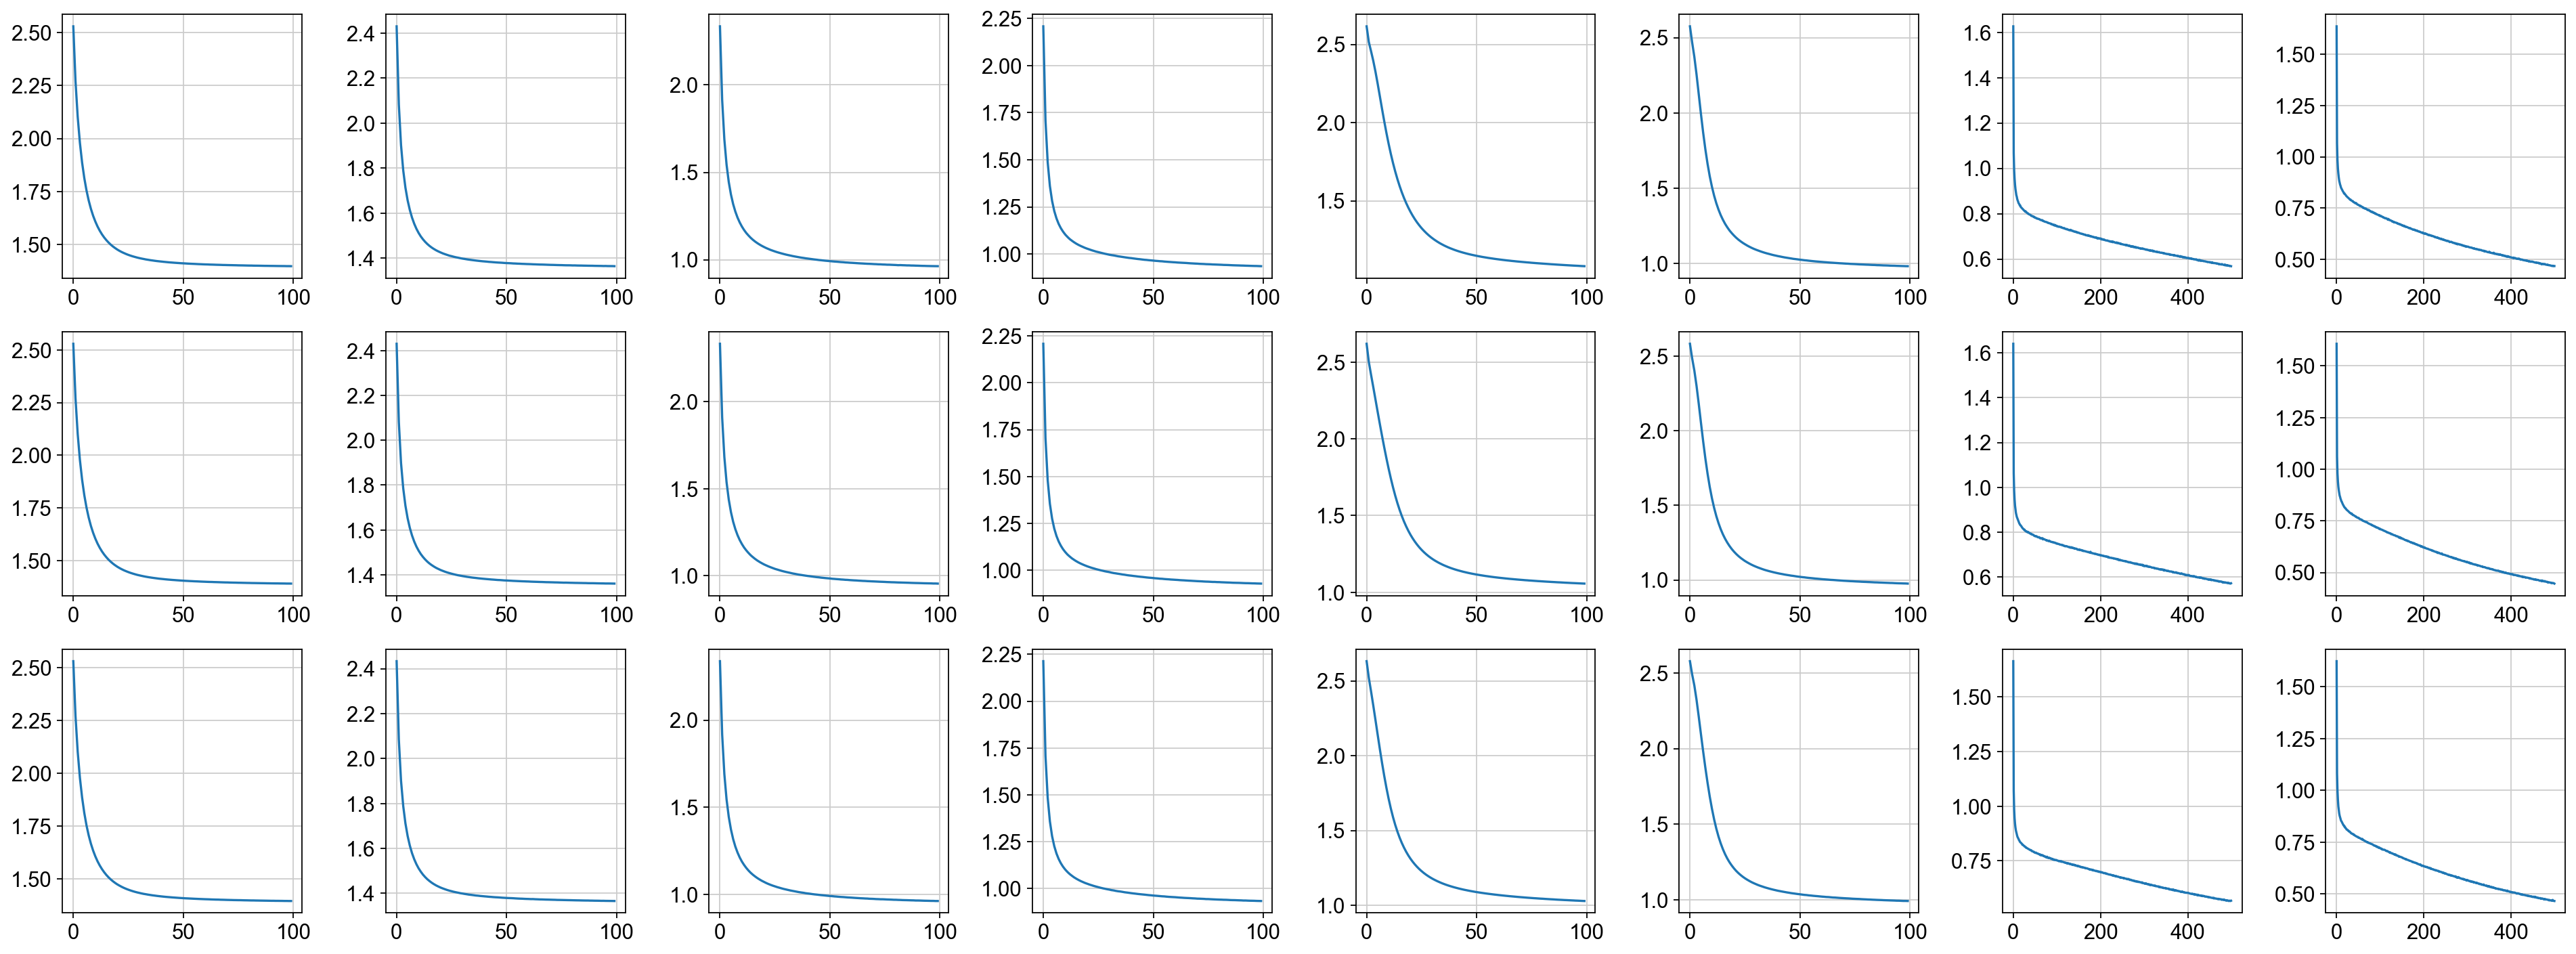

In [27]:
cvs=3
fig, axs = plt.subplots(nrows=cvs, ncols=8, figsize=(8*3, 3*cvs))
for i, (k, v) in  enumerate(evals.items()):
    for j, (kk, vv) in enumerate(v.items()):
        sb.lineplot(data=vv["history"]["loss"], ax=axs[i, j])
plt.tight_layout()
plt.show()

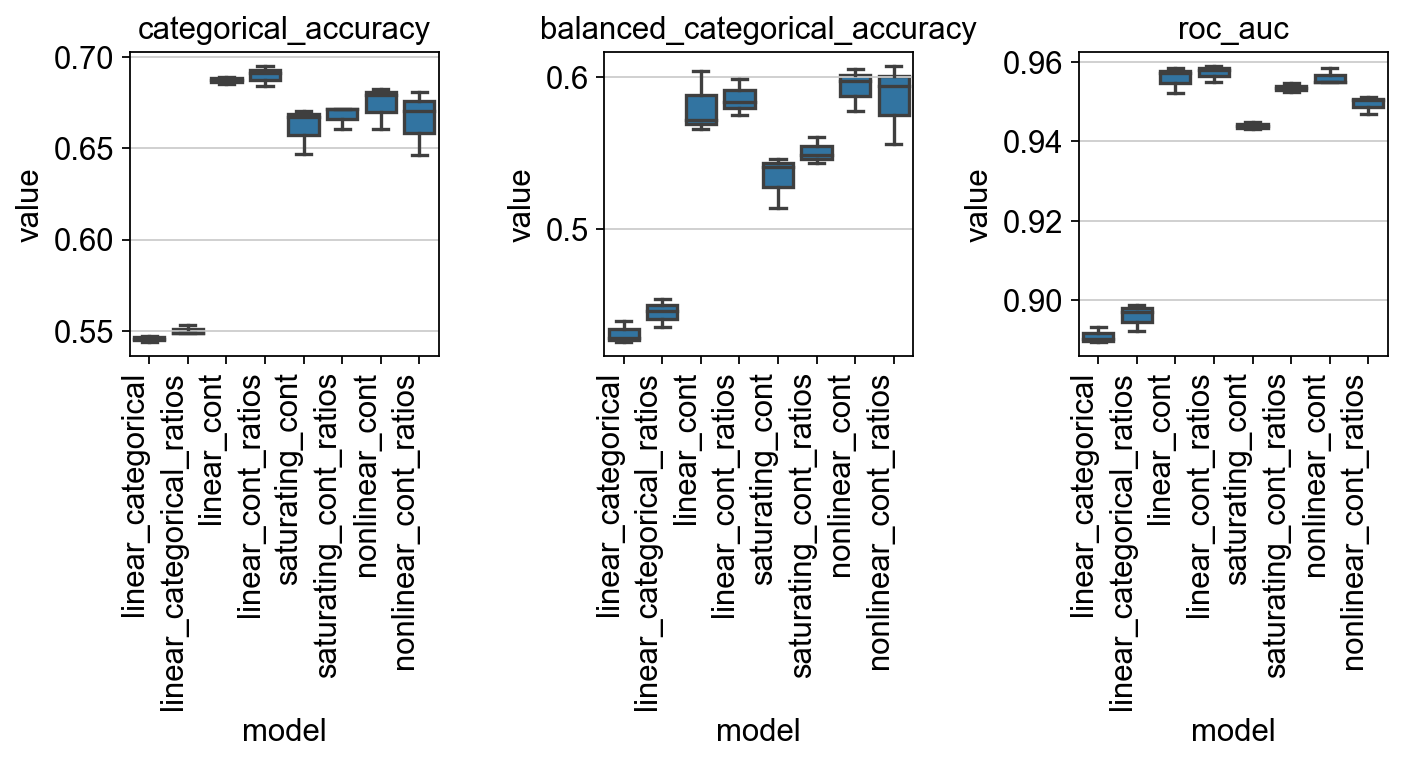

In [28]:
results = \
pd.concat([
    pd.concat([
        pd.concat([
            pd.concat([
                pd.DataFrame(
                    {"cv": k, "value": vvv, "metric": kkk, "partition": p, "model": kk},
                    index=[k+kk+kkk+p]
                )
                for kkk, vvv in vv["evals"][p].items()], axis=0)
            for p in ["test"]], axis=0)
        for kk, vv in v.items()], axis=0)
    for k, v in evals.items()], axis=0)

ncols = 3
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(ncols*3, 5))
for i, x in enumerate(["categorical_accuracy", "balanced_categorical_accuracy", "roc_auc"]):
    sb.boxplot(data=results.loc[results["metric"].values == x, :], x="model", y="value", 
               hue="partition", ax=ax[i])
    ax[i].set_title(x)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90, ha='right')
    if "r2" in x:
        ax[i].set_ylim([0, 1])
    ax[i].legend_.remove()
plt.tight_layout()
plt.show()

## Regression random hold-outs

In [29]:
evals = {}
estim = fatevision.estimators.Estimator(adata=adata_proc_prediction)
estim.set_y(selection="hvg", n_genes=5000, normalize=True, log=True)
for k, v in {
    "linear_cluster": ["louvain_named"],
    "linear_condition": ["inferred_category_real"],
    "linear_categorical": coef_conditions+coef_conditions_interactions,
    #"linear_categorical_ratios": coef_conditions+coef_conditions_interactions,
    "linear_cont": coef_factors, 
    #"linear_cont_ratios": coef_factors+coef_factors_ratios, 
    #"saturating_cont": coef_factors,
    #"saturating_cont_ratios": coef_factors+coef_factors_ratios,
    #"nonlinear_cont": coef_factors,
    "nonlinear_cont_ratios": coef_factors+coef_factors_ratios,
}.items():
    formula_batch = "~1+batch+sf"
    formula = "~0+" + "+".join(v)        
    as_numeric = ["sf"]
    if "cont" in k:
        as_numeric += v
    estim.set_x(formula=formula, formula_batch=formula_batch, as_numeric=as_numeric)
    for cv in range(3):
        cv = str(cv)
        if cv not in evals.keys():
            evals[cv] = {}
        estim.split_random(test_split=0.1, seed=int(cv))
        estim.init_model(k)
        if "linear" in k:
            kwargs_fit = {"optim": "adam", "fit_on_full_batches": False, "batch_size": 64}
        else:
            kwargs_fit = {"optim": "adam", "fit_on_full_batches": False, "batch_size": 64}
        print(k)
        epochs = 20 if k.startswith("linear_") else 40
        evals[cv][k] = estim.train(epochs=epochs, lr=1., **kwargs_fit)

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 12220 genes that are detected in less than 1000 counts
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
linear_cluster
Epoch 1/20
167/167 - 1s - loss: 0.9986 - custom_mse: 0.2927
Epoch 2/20
167/167 - 1s - loss: 0.8139 - custom_mse: 0.1948
Epoch 3/20
167/167 - 1s - loss: 0.6632 - custom_mse: 0.1537
Epoch 4/20
167/167 - 1s - loss: 0.5340 - custom_mse: 0.1324
Epoch 5/20
167/167 - 1s - loss: 0.4248 - custom_mse: 0.1203
Epoch 6/20
1

linear_condition
Epoch 1/20
167/167 - 1s - loss: 0.9999 - custom_mse: 0.2945
Epoch 2/20
167/167 - 1s - loss: 0.8177 - custom_mse: 0.1994
Epoch 3/20
167/167 - 1s - loss: 0.6711 - custom_mse: 0.1609
Epoch 4/20
167/167 - 1s - loss: 0.5473 - custom_mse: 0.1416
Epoch 5/20
167/167 - 1s - loss: 0.4437 - custom_mse: 0.1307
Epoch 6/20
167/167 - 1s - loss: 0.3591 - custom_mse: 0.1240
Epoch 7/20
167/167 - 1s - loss: 0.2920 - custom_mse: 0.1196
Epoch 8/20
167/167 - 1s - loss: 0.2405 - custom_mse: 0.1165
Epoch 9/20
167/167 - 1s - loss: 0.2025 - custom_mse: 0.1144
Epoch 10/20
167/167 - 1s - loss: 0.1758 - custom_mse: 0.1128
Epoch 11/20
167/167 - 1s - loss: 0.1579 - custom_mse: 0.1117
Epoch 12/20
167/167 - 1s - loss: 0.1466 - custom_mse: 0.1108
Epoch 13/20
167/167 - 1s - loss: 0.1398 - custom_mse: 0.1100
Epoch 14/20
167/167 - 1s - loss: 0.1360 - custom_mse: 0.1094
Epoch 15/20
167/167 - 1s - loss: 0.1339 - custom_mse: 0.1090
Epoch 16/20
167/167 - 1s - loss: 0.1327 - custom_mse: 0.1086
Epoch 17/20
167/

Epoch 13/20
167/167 - 1s - loss: 0.1289 - custom_mse: 0.1092
Epoch 14/20
167/167 - 1s - loss: 0.1251 - custom_mse: 0.1087
Epoch 15/20
167/167 - 1s - loss: 0.1230 - custom_mse: 0.1082
Epoch 16/20
167/167 - 1s - loss: 0.1219 - custom_mse: 0.1079
Epoch 17/20
167/167 - 1s - loss: 0.1213 - custom_mse: 0.1075
Epoch 18/20
167/167 - 1s - loss: 0.1208 - custom_mse: 0.1072
Epoch 19/20
167/167 - 1s - loss: 0.1205 - custom_mse: 0.1070
Epoch 20/20
167/167 - 1s - loss: 0.1203 - custom_mse: 0.1068
371/371 [==============================] - 1s 2ms/step - loss: 0.1190 - custom_mse: 0.1065
linear_cont
Epoch 1/20
167/167 - 1s - loss: 0.9489 - custom_mse: 0.1987
Epoch 2/20
167/167 - 1s - loss: 0.7781 - custom_mse: 0.1330
Epoch 3/20
167/167 - 1s - loss: 0.6473 - custom_mse: 0.1249
Epoch 4/20
167/167 - 1s - loss: 0.5323 - custom_mse: 0.1210
Epoch 5/20
167/167 - 1s - loss: 0.4328 - custom_mse: 0.1183
Epoch 6/20
167/167 - 1s - loss: 0.3495 - custom_mse: 0.1162
Epoch 7/20
167/167 - 1s - loss: 0.2825 - custom_m

Epoch 3/40
167/167 - 2s - loss: -1.0212e-02 - custom_mse: 0.1021
Epoch 4/40
167/167 - 3s - loss: -1.9136e-02 - custom_mse: 0.1007
Epoch 5/40
167/167 - 3s - loss: -2.4663e-02 - custom_mse: 0.0998
Epoch 6/40
167/167 - 3s - loss: -2.8967e-02 - custom_mse: 0.0991
Epoch 7/40
167/167 - 2s - loss: -3.2216e-02 - custom_mse: 0.0985
Epoch 8/40
167/167 - 2s - loss: -3.5180e-02 - custom_mse: 0.0981
Epoch 9/40
167/167 - 2s - loss: -3.6840e-02 - custom_mse: 0.0978
Epoch 10/40
167/167 - 2s - loss: -3.9284e-02 - custom_mse: 0.0975
Epoch 11/40
167/167 - 2s - loss: -4.1213e-02 - custom_mse: 0.0972
Epoch 12/40
167/167 - 2s - loss: -4.2673e-02 - custom_mse: 0.0970
Epoch 13/40
167/167 - 2s - loss: -4.4157e-02 - custom_mse: 0.0968
Epoch 14/40
167/167 - 2s - loss: -4.5456e-02 - custom_mse: 0.0966
Epoch 15/40
167/167 - 2s - loss: -4.6855e-02 - custom_mse: 0.0964
Epoch 16/40
167/167 - 2s - loss: -4.7841e-02 - custom_mse: 0.0962
Epoch 17/40
167/167 - 2s - loss: -4.9242e-02 - custom_mse: 0.0961
Epoch 18/40
167/1

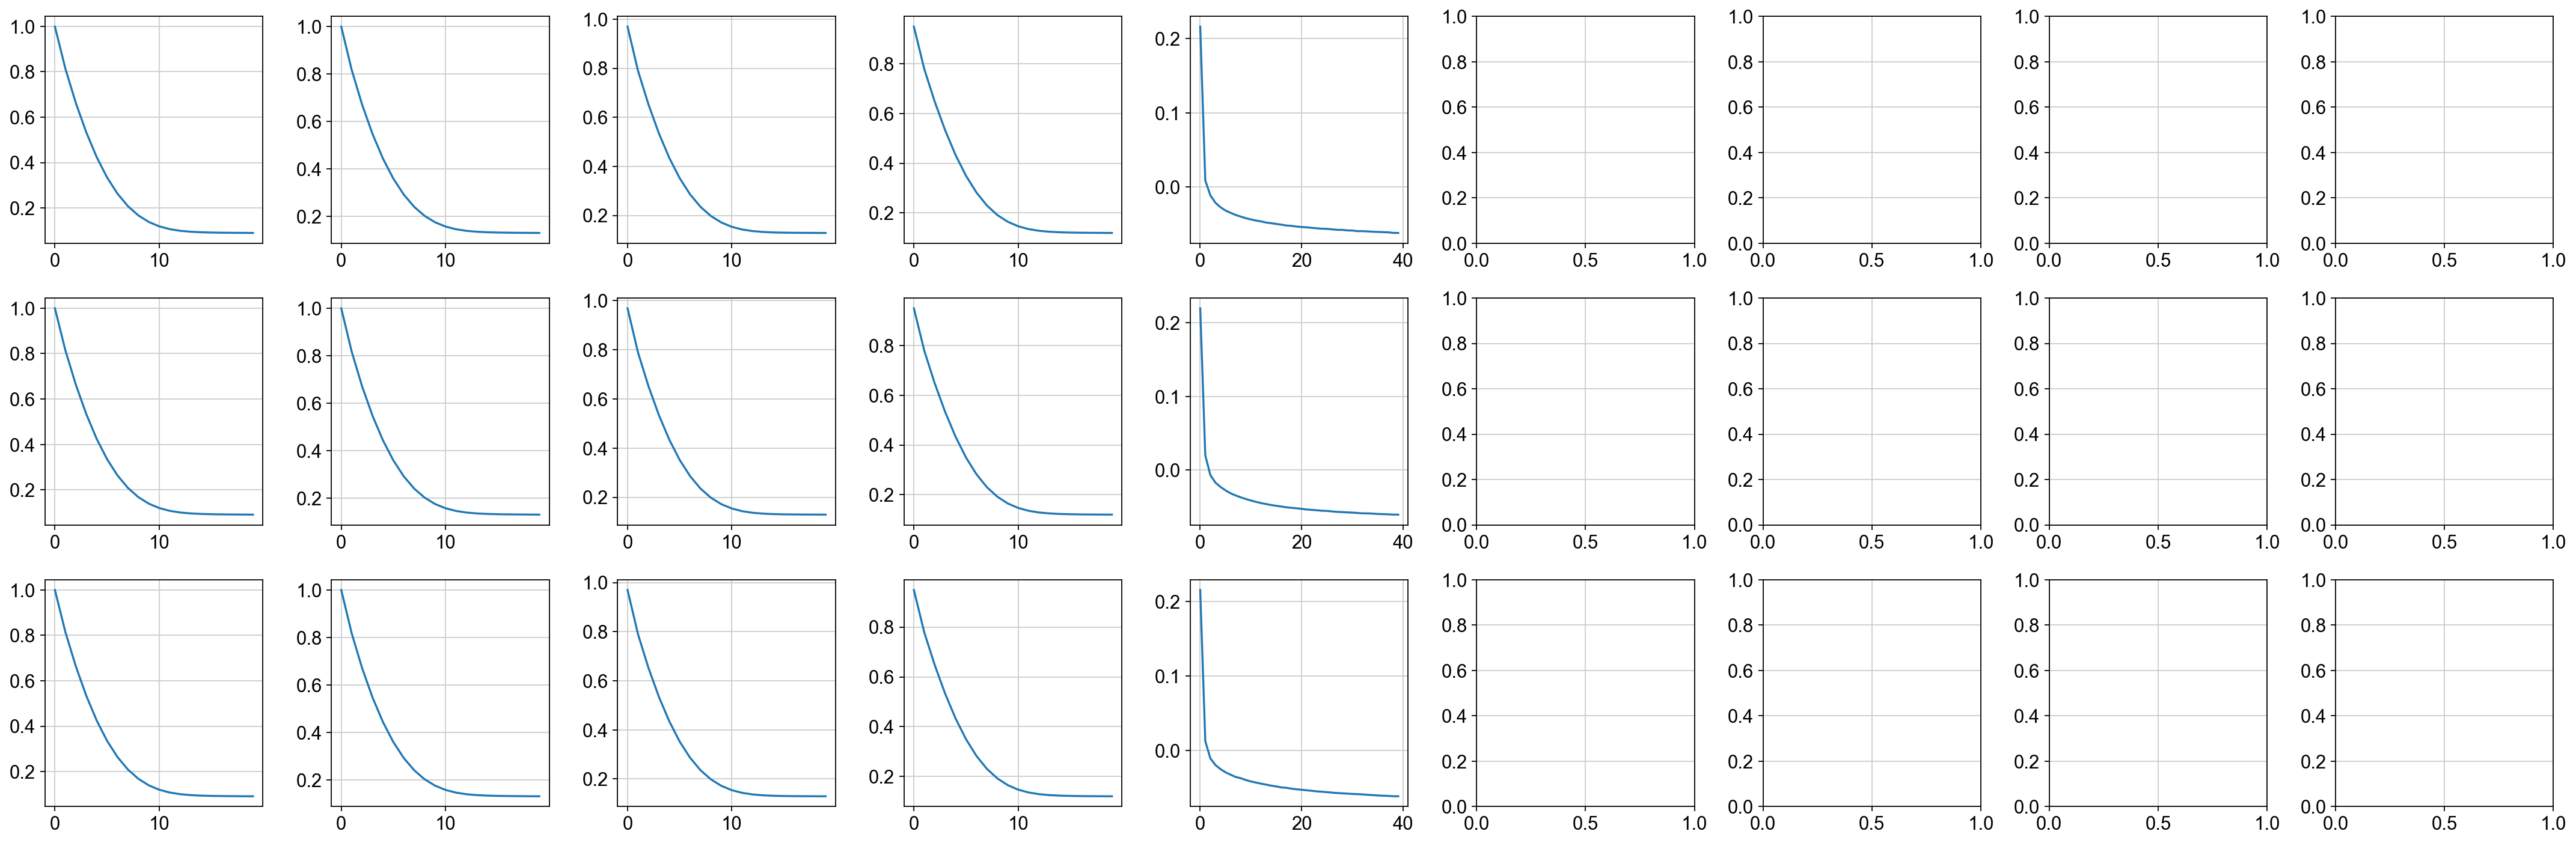

In [30]:
cvs=3
fig, axs = plt.subplots(nrows=cvs, ncols=9, figsize=(9*3, 3*cvs))
for i, (k, v) in  enumerate(evals.items()):
    for j, (kk, vv) in enumerate(v.items()):
        sb.lineplot(data=vv["history"]["loss"], ax=axs[i, j])
plt.tight_layout()
plt.show()

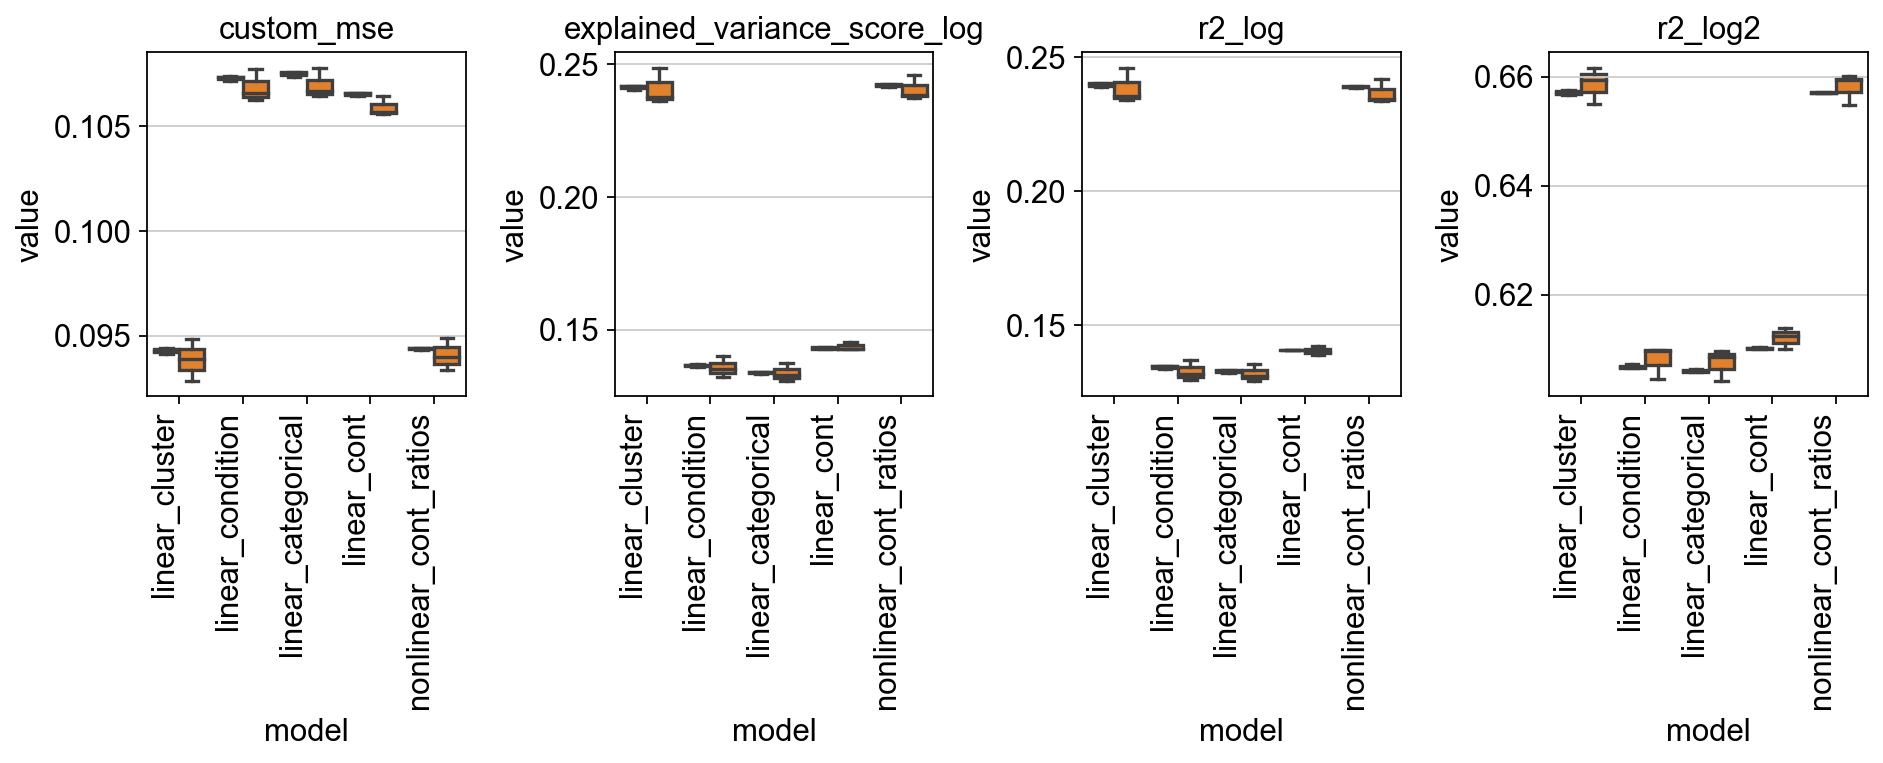

In [54]:
results = \
pd.concat([
    pd.concat([
        pd.concat([
            pd.concat([
                pd.DataFrame(
                    {"cv": k, "value": vvv, "metric": kkk, "partition": p, "model": kk},
                    index=[k+kk+kkk+p]
                )
                for kkk, vvv in vv["evals"][p].items() if ("gene" not in kkk and "cell" not in kkk)], axis=0)
            for p in ["train", "test"]], axis=0)
        for kk, vv in v.items()], axis=0)
    for k, v in evals.items()], axis=0)

ncols = 4
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(ncols*3, 5))
for i, x in enumerate(["custom_mse", "explained_variance_score_log", "r2_log", "r2_log2"]):
    sb.boxplot(data=results.loc[results["metric"].values == x, :], x="model", y="value", 
               hue="partition", ax=ax[i])
    ax[i].set_title(x)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90, ha='right')
    if "_r2" in x:
        ax[i].set_ylim([0, 1])
    ax[i].legend_.remove()
plt.tight_layout()
plt.show()

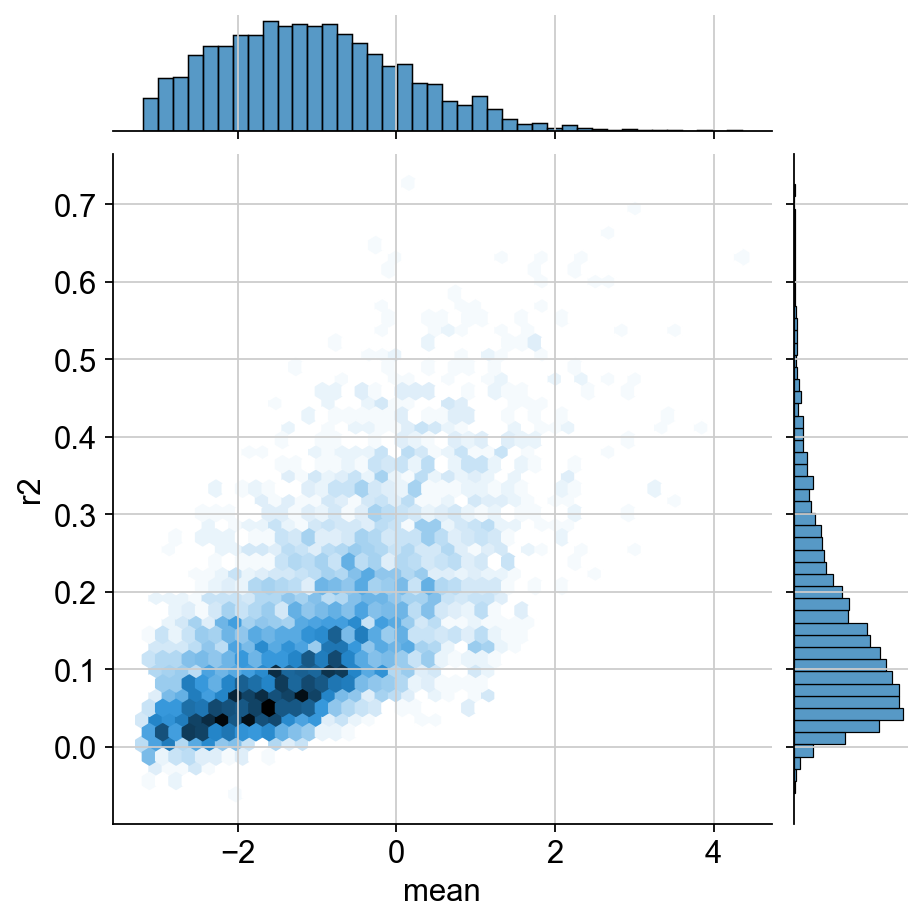

In [32]:
tab = evals["0"]["nonlinear_cont_ratios"]["evals"]["test"]["r2_log_gene"].copy()
#tab["r2"] = np.maximum(tab["r2"].values, 0.)
#tab["explained_variance_score"] = np.maximum(tab["explained_variance_score"].values, 0.)
sb.jointplot(
    data=tab,
    x="mean", y="r2", kind="hex"
)
plt.show()

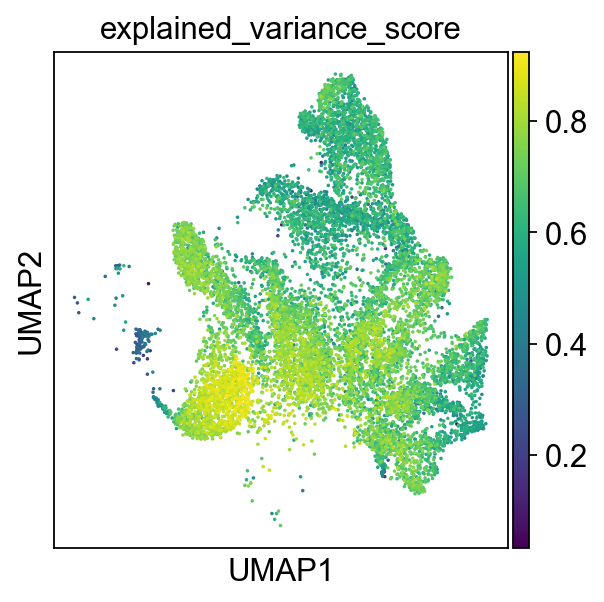

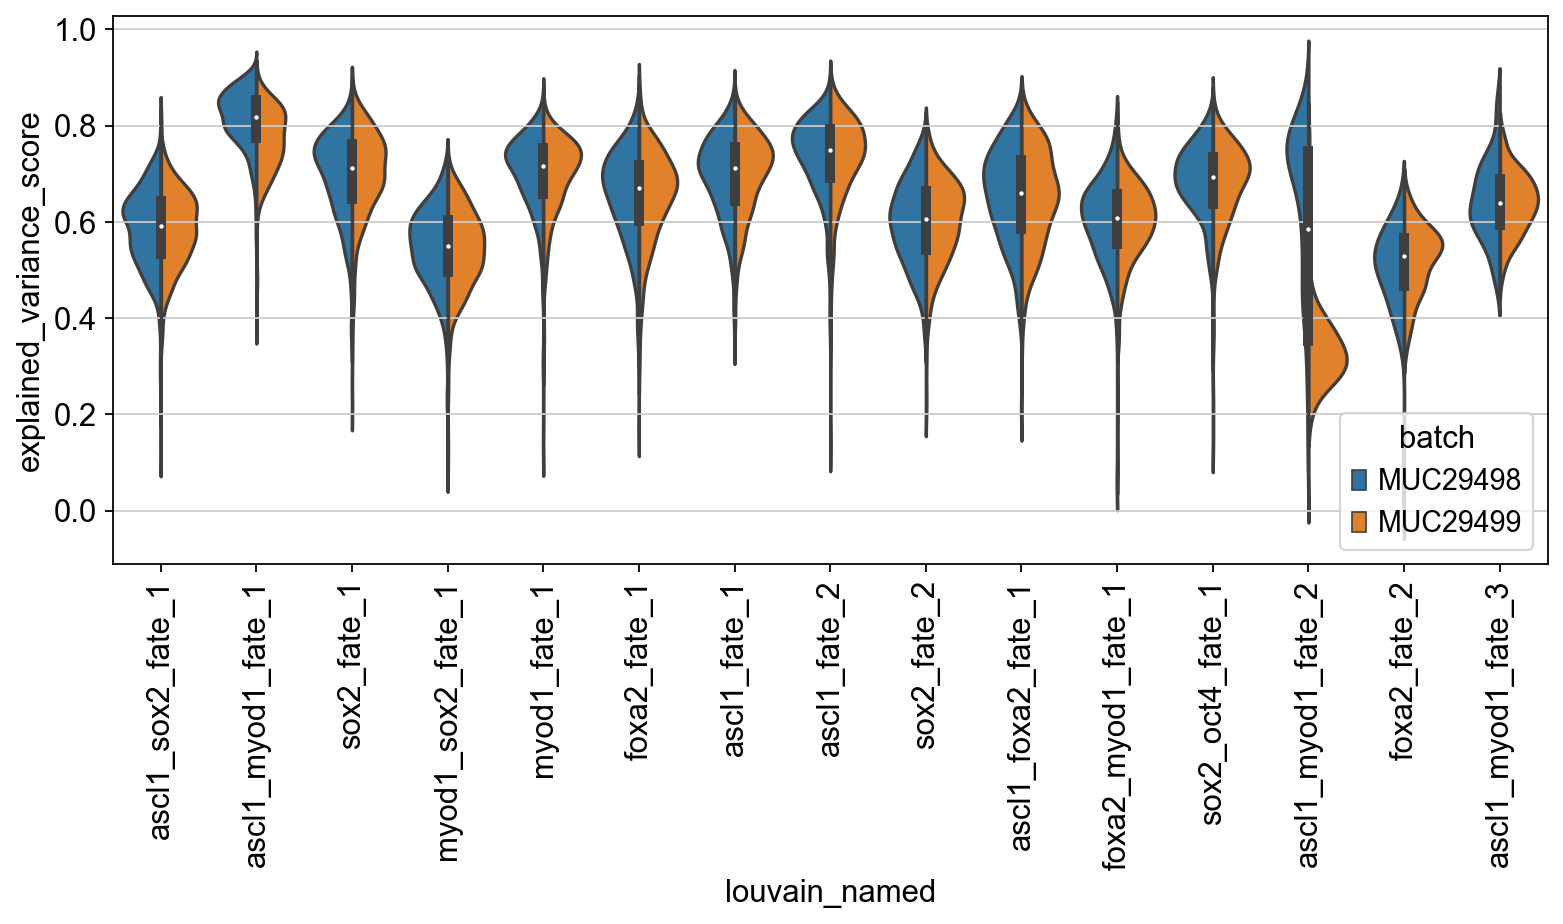

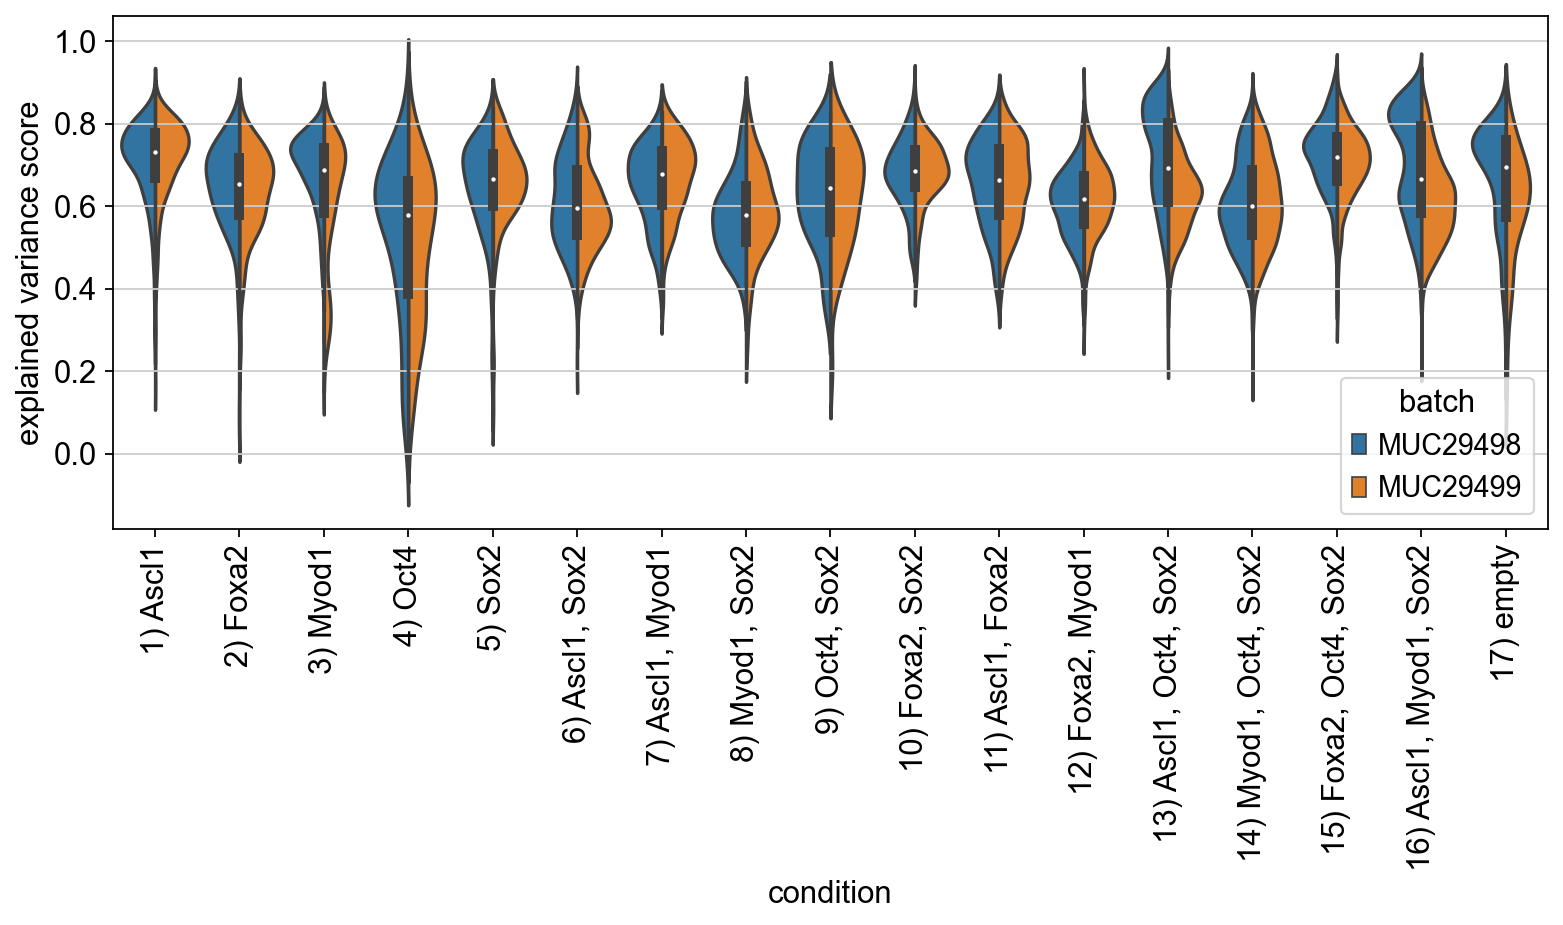

In [33]:
adata_temp = adata_proc_prediction.copy()
for k in ["scale", "r2", "explained_variance_score"]:
    adata_temp.obs[k] = evals["0"]["nonlinear_cont_ratios"]["evals"]["all"]["r2_log_cell"][k].values

sc.pl.umap(adata_temp, color="explained_variance_score", show=False)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax = [ax]
ax[0] = sb.violinplot(data=adata_temp.obs, x="louvain_named", y="explained_variance_score", hue="batch", split=True, ax=ax[0])
ax[0].xaxis.set_tick_params(rotation=90)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax = [ax]
ax[0] = sb.violinplot(data=adata_temp.obs, x="inferred_category_real", y="explained_variance_score", hue="batch", split=True, ax=ax[0])
ax[0].xaxis.set_tick_params(rotation=90)
ax[0].set_ylabel("explained variance score")
ax[0].set_xlabel("condition")
plt.tight_layout()
plt.savefig(dir_out + "EV2e.pdf")
plt.show()
del adata_temp

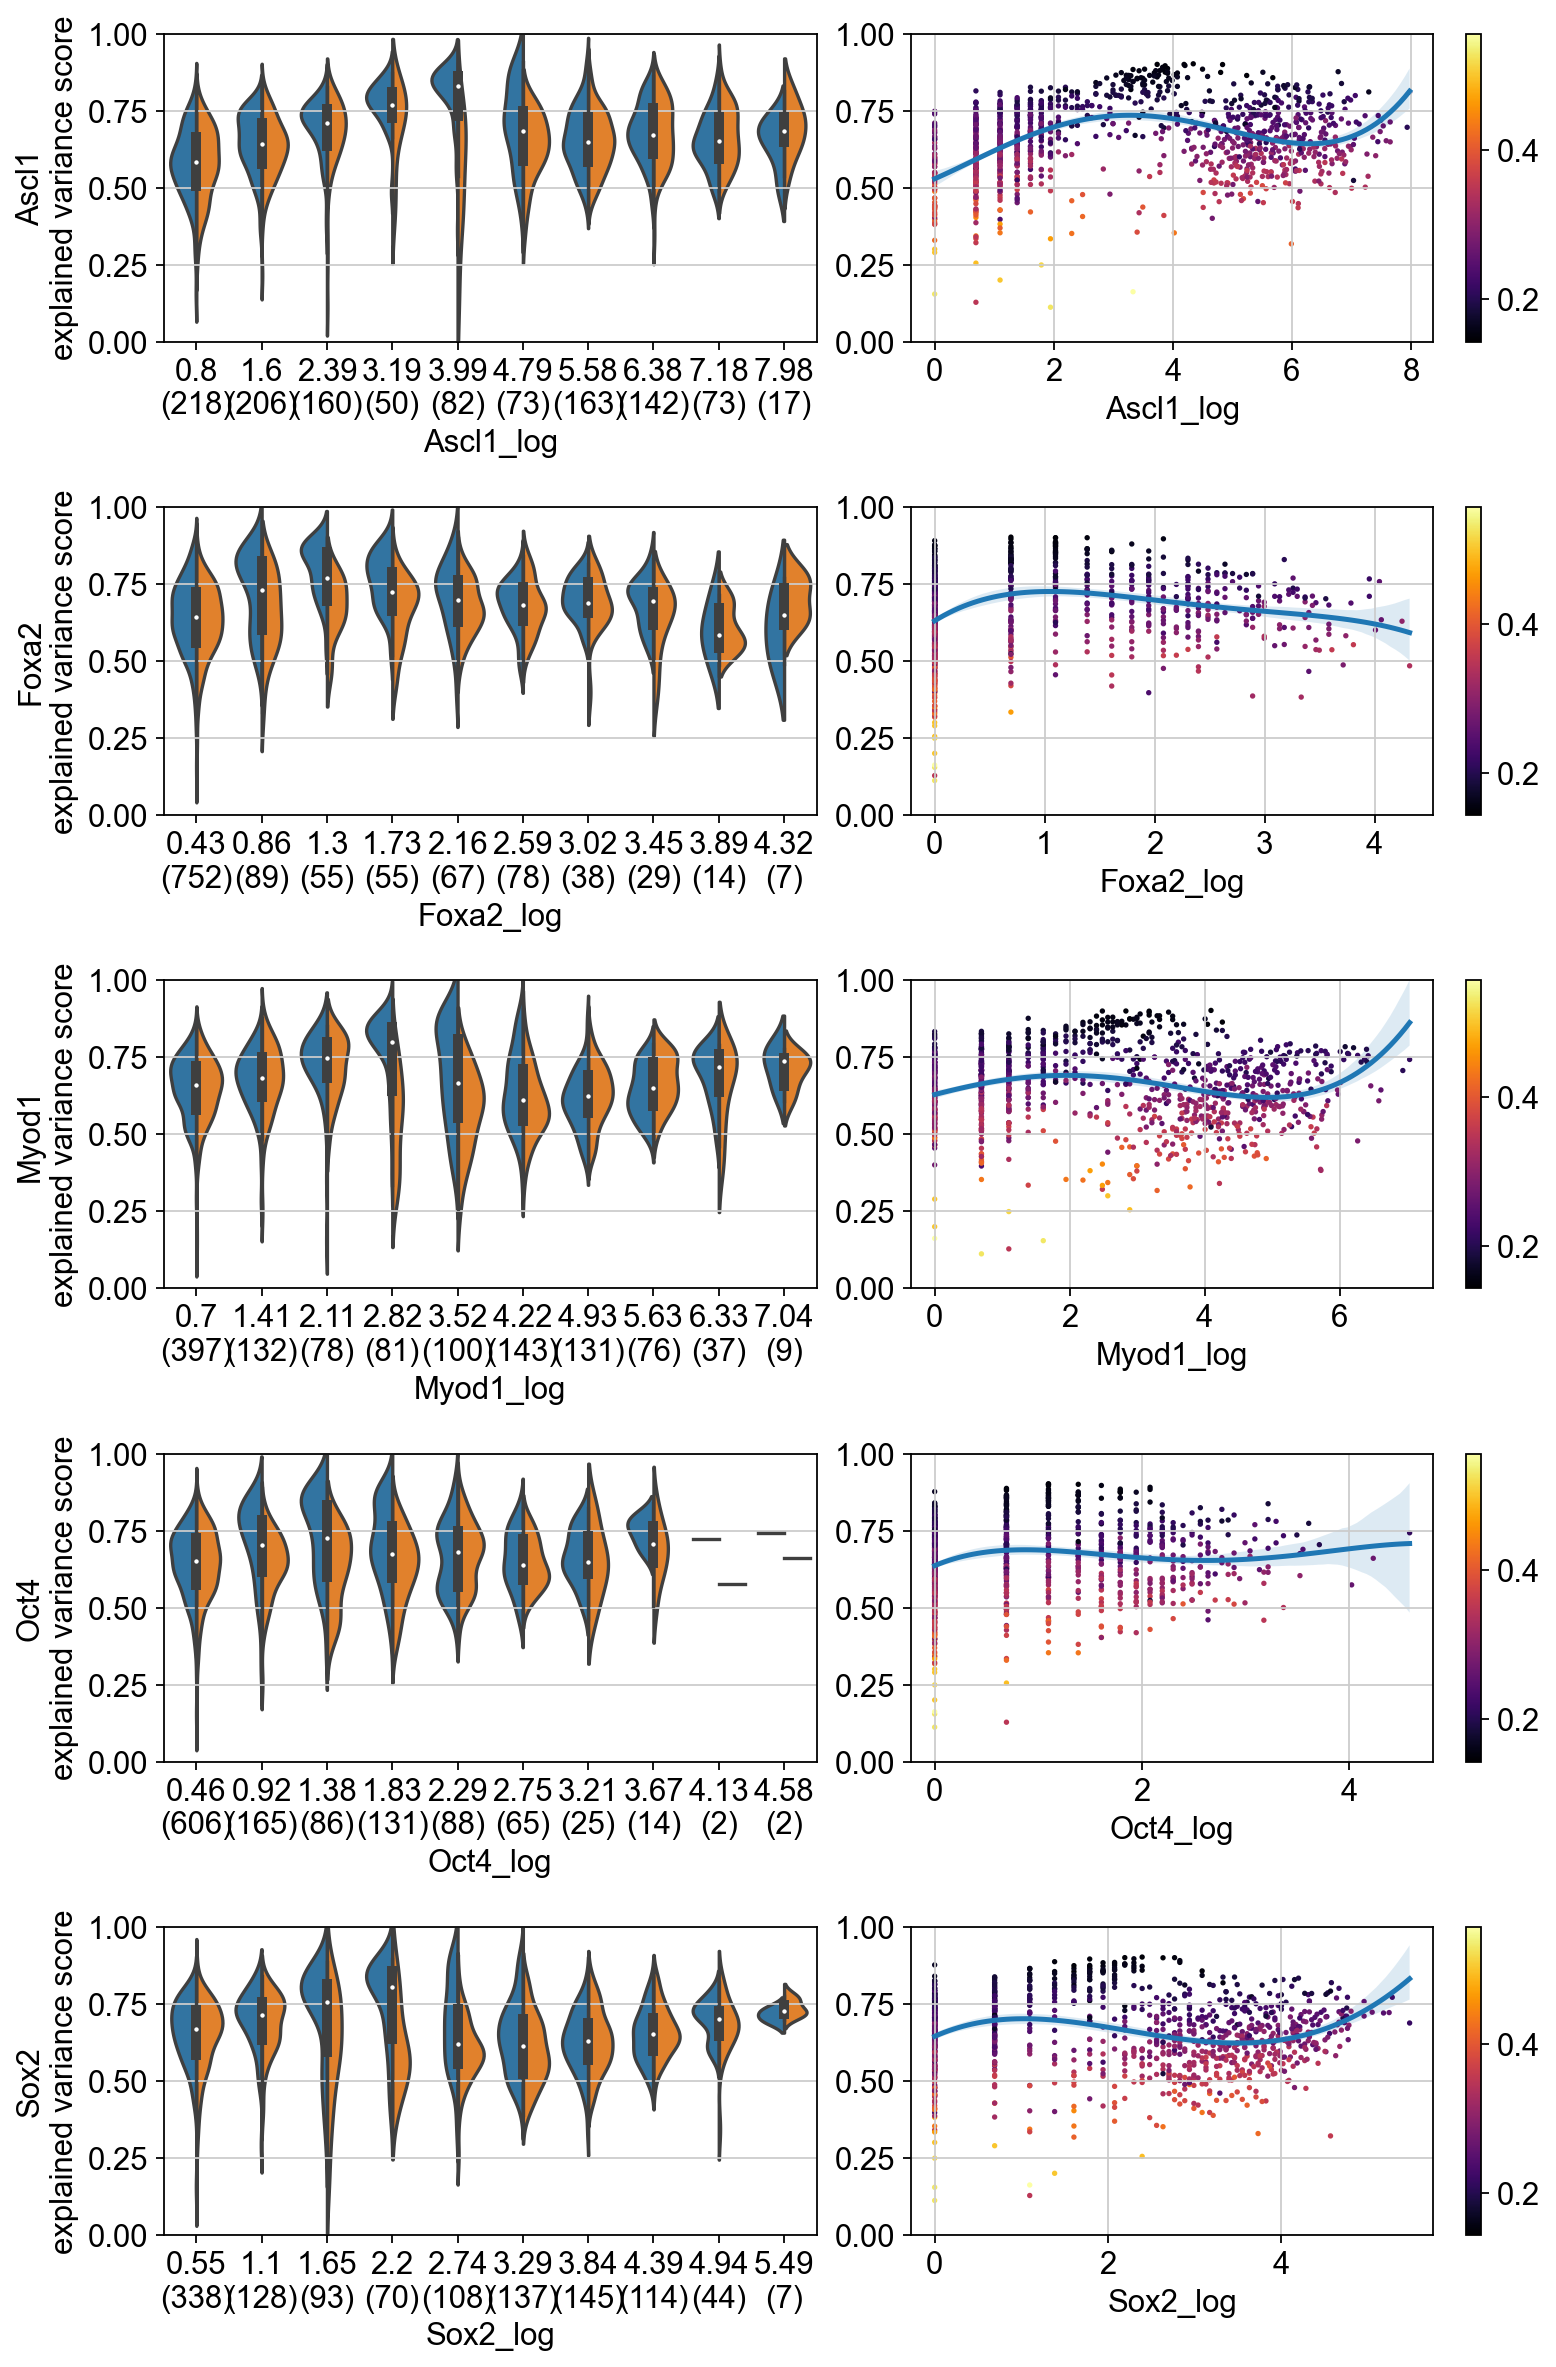

In [34]:
tab = evals["0"]["nonlinear_cont_ratios"]["evals"]["test"]["r2_log_cell"].copy()

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(10, 5*3))
for i, x in enumerate(constructs):
    tab_i = tab.copy()
    k = f"{x}_log"
    tab_i[k] = pd.cut(tab_i[k].values, bins=10, ordered=True, right=True, include_lowest=True)
    
    def f(z):
        return f"{np.round(z.right, 2) }\n({int(np.sum(tab_i[k].values == z))})"
    
    tab_i[k] = pd.Categorical([f(z=y) for y in tab_i[k].values], 
                              categories=[f(z=y)for y in tab_i[k].values.categories])
    ax[i, 0] = sb.violinplot(data=tab_i, x=f"{x}_log", y="explained_variance_score", ax=ax[i, 0], 
                             split=True, hue="batch")  #color="grey")
    ax[i, 0].legend_.remove()
    ax[i, 1] = sb.regplot(
        data=tab, x=f"{x}_log", y="r2", scatter_kws={"s": 0.001},
        order=4, ci=95, ax=ax[i, 1])
    points = ax[i, 1].scatter(
        x=tab[f"{x}_log"].values, y=tab["r2"].values, s=2,
        c=tab["scale"].values, cmap="inferno"
    )
    fig.colorbar(points, ax=ax[i, 1])
    ax[i, 0].set_ylim([0, 1])
    ax[i, 1].set_ylim([0, 1])
    ax[i, 0].set_ylabel(f"{x}\nexplained variance score")
    ax[i, 1].set_ylabel("")
plt.tight_layout()
plt.savefig(dir_out + "EV2fg.pdf")
plt.show()

/Users/davfischer/opt/miniconda3/envs/collideseq/lib/python3.8/site-packages/seaborn/axisgrid.py:2182: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


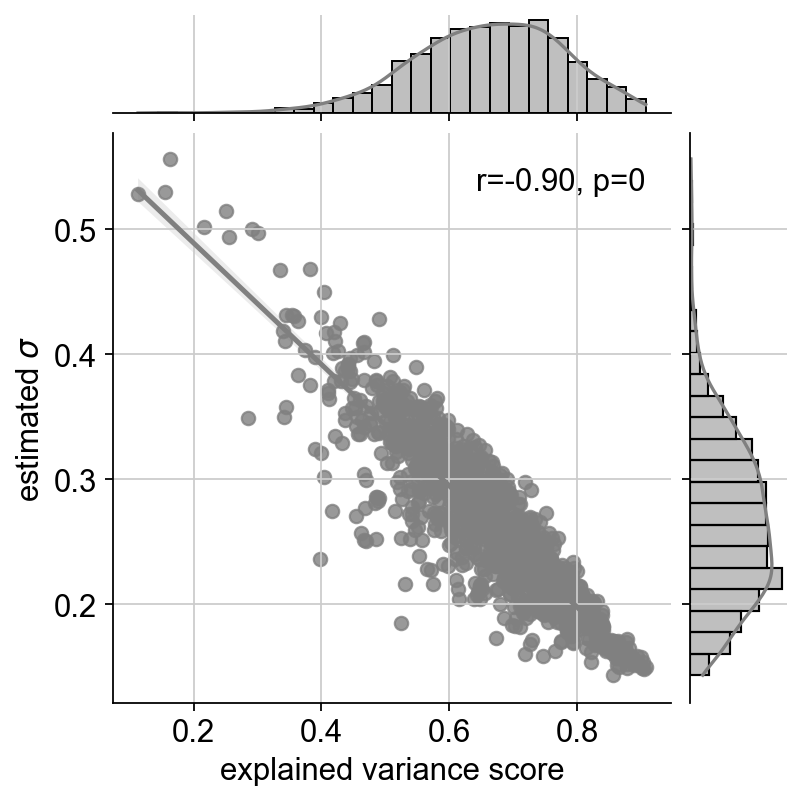

In [35]:
from scipy import stats

r, p = stats.pearsonr(x=tab["explained_variance_score"].values, y=tab["scale"].values)

axs = sb.jointplot(
    x=tab["explained_variance_score"].values, y=tab["scale"].values, 
    kind="reg", color="grey", size=5,
)
axs.ax_joint.set_xlabel("explained variance score")
axs.ax_joint.set_ylabel("estimated $\sigma$")
axs.ax_joint.text(.65, .9, 'r={:.2f}, p={:.2g}'.format(r, p),
                  transform=axs.ax_joint.transAxes)
plt.savefig(dir_out + "EV2d.pdf")
plt.show()

No handles with labels found to put in legend.


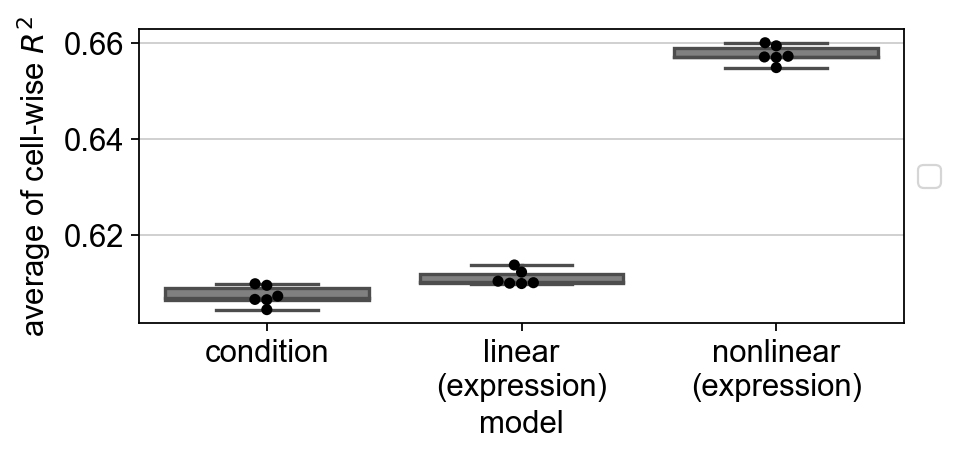

In [55]:
data = results.loc[[x in ["r2_log2"]
                      for x in results["metric"].values], :]
data = data.loc[[x in ["linear_condition", "linear_cont", "nonlinear_cont_ratios"]
                       for x in data["model"].values], :]
data["model"] = pd.Categorical(
    [{"linear_condition": "condition",
      "linear_cont": "linear\n(expression)", 
      "nonlinear_cont_ratios": "nonlinear\n(expression)"}[x] 
     for x in data["model"].values.tolist()], 
    categories=["condition", "linear\n(expression)",
                "nonlinear\n(expression)", ])
data["metric"] = pd.Categorical(
    [{"r2_log2": "R2"}[x] 
     for x in data["metric"].values.tolist()], 
    categories=["R2"])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
sb.boxplot(
    data=data, 
    color="grey",
    x="model", y="value", ax=ax)
sb.swarmplot(
    data=data, 
    color="black",
    x="model", y="value", ax=ax)
ax.set_title("")
ax.xaxis.set_tick_params(rotation=0)
#ax.set_ylim([0, 1])
ax.set_ylabel("average of cell-wise $R^2$")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.95, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(dir_out + "4g.pdf")
plt.show()

In [56]:
data.groupby(["model", "metric"])["value"].mean()

model                    metric
condition                R2        0.607430
linear\n(expression)     R2        0.611114
nonlinear\n(expression)  R2        0.657639
Name: value, dtype: float64

## Predict multi-positive hold-outs

In [37]:
test_conditions = [
    x for x in np.unique(adata_proc_prediction.obs["inferred_category_real"].values)
    if len(x.split(",")) > 1]
train_conditions = [
    x for x in np.unique(adata_proc_prediction.obs["inferred_category_real"].values)
    if len(x.split(",")) <= 1]
evals_mp = {}
estim = fatevision.estimators.Estimator(adata=adata_proc_prediction)
estim.set_y(selection="hvg", n_genes=5000, normalize=True, log=True)
for k, v in {
    "linear_categorical": coef_conditions,
    "linear_cont": coef_factors, 
    "saturating_cont": coef_factors,
    "nonlinear_cont": coef_factors,
}.items():
    formula_batch = "~1+batch+sf"
    formula = "~0+" + "+".join(v)        
    as_numeric = ["sf"]
    if "cont" in k:
        as_numeric += v
    estim.set_x(formula=formula, formula_batch=formula_batch, as_numeric=as_numeric)
    cv = test_conditions[0]
    if cv not in evals_mp.keys():
        evals_mp[cv] = {}
    estim.split_groups(
        grouping="inferred_category_real", 
        test_groups=[cv],
        train_groups=train_conditions
    )
    estim.init_model(k)
    if "linear" in k:
        kwargs_fit = {"optim": "adam", "fit_on_full_batches": False, "batch_size": 64}
    else:
        kwargs_fit = {"optim": "adam", "fit_on_full_batches": False, "batch_size": 64}
    evals_mp[cv][k] = estim.train(epochs=100, lr=1., **kwargs_fit)
    for cv in test_conditions[1:]:
        if cv not in evals_mp.keys():
            evals_mp[cv] = {}
        estim.split_groups(
            grouping="inferred_category_real", 
            test_groups=[cv],
            train_groups=train_conditions
        )
        evals_mp[cv][k] = {"evals": estim.evaluate(partitions=["test"])}

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 12220 genes that are detected in less than 1000 counts
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
omitted groups: ['11) Ascl1, Foxa2', '12) Foxa2, Myod1', '13) Ascl1, Oct4, Sox2', '14) Myod1, Oct4, Sox2', '15) Foxa2, Oct4, Sox2', '16) Ascl1, Myod1, Sox2', '6) Ascl1, Sox2', '7) Ascl1, Myod1', '8) Myod1, Sox2', '9) Oct4, Sox2']
train groups: ['1) Ascl1', '17) empty', '2) Foxa2', '3) Myod1', '4) Oct4', '5) Sox2']
test groups

55/55 [==============================] - 0s 2ms/step - loss: 0.3786 - custom_mse: 0.1452
omitted groups: ['10) Foxa2, Sox2', '11) Ascl1, Foxa2', '12) Foxa2, Myod1', '13) Ascl1, Oct4, Sox2', '15) Foxa2, Oct4, Sox2', '16) Ascl1, Myod1, Sox2', '6) Ascl1, Sox2', '7) Ascl1, Myod1', '8) Myod1, Sox2', '9) Oct4, Sox2']
train groups: ['1) Ascl1', '17) empty', '2) Foxa2', '3) Myod1', '4) Oct4', '5) Sox2']
test groups: ['14) Myod1, Oct4, Sox2']
48/48 [==============================] - 0s 2ms/step - loss: 0.4514 - custom_mse: 0.1593
omitted groups: ['10) Foxa2, Sox2', '11) Ascl1, Foxa2', '12) Foxa2, Myod1', '13) Ascl1, Oct4, Sox2', '14) Myod1, Oct4, Sox2', '16) Ascl1, Myod1, Sox2', '6) Ascl1, Sox2', '7) Ascl1, Myod1', '8) Myod1, Sox2', '9) Oct4, Sox2']
train groups: ['1) Ascl1', '17) empty', '2) Foxa2', '3) Myod1', '4) Oct4', '5) Sox2']
test groups: ['15) Foxa2, Oct4, Sox2']
45/45 [==============================] - 0s 2ms/step - loss: 0.1945 - custom_mse: 0.1261
omitted groups: ['10) Foxa2, Sox2',

Epoch 80/100
49/49 - 0s - loss: 0.0684 - custom_mse: 0.1019
Epoch 81/100
49/49 - 0s - loss: 0.0683 - custom_mse: 0.1020
Epoch 82/100
49/49 - 0s - loss: 0.0683 - custom_mse: 0.1019
Epoch 83/100
49/49 - 0s - loss: 0.0682 - custom_mse: 0.1022
Epoch 84/100
49/49 - 0s - loss: 0.0682 - custom_mse: 0.1017
Epoch 85/100
49/49 - 0s - loss: 0.0681 - custom_mse: 0.1019
Epoch 86/100
49/49 - 0s - loss: 0.0681 - custom_mse: 0.1014
Epoch 87/100
49/49 - 0s - loss: 0.0681 - custom_mse: 0.1017
Epoch 88/100
49/49 - 0s - loss: 0.0681 - custom_mse: 0.1021
Epoch 89/100
49/49 - 0s - loss: 0.0680 - custom_mse: 0.1017
Epoch 90/100
49/49 - 0s - loss: 0.0680 - custom_mse: 0.1015
Epoch 91/100
49/49 - 0s - loss: 0.0680 - custom_mse: 0.1019
Epoch 92/100
49/49 - 0s - loss: 0.0679 - custom_mse: 0.1015
Epoch 93/100
49/49 - 0s - loss: 0.0679 - custom_mse: 0.1016
Epoch 94/100
49/49 - 0s - loss: 0.0679 - custom_mse: 0.1020
Epoch 95/100
49/49 - 0s - loss: 0.0678 - custom_mse: 0.1016
Epoch 96/100
49/49 - 0s - loss: 0.0678 -

Epoch 34/100
49/49 - 0s - loss: 0.1354 - custom_mse: 0.1107
Epoch 35/100
49/49 - 0s - loss: 0.1283 - custom_mse: 0.1106
Epoch 36/100
49/49 - 0s - loss: 0.1220 - custom_mse: 0.1101
Epoch 37/100
49/49 - 0s - loss: 0.1163 - custom_mse: 0.1097
Epoch 38/100
49/49 - 0s - loss: 0.1113 - custom_mse: 0.1092
Epoch 39/100
49/49 - 0s - loss: 0.1068 - custom_mse: 0.1089
Epoch 40/100
49/49 - 0s - loss: 0.1027 - custom_mse: 0.1086
Epoch 41/100
49/49 - 0s - loss: 0.0993 - custom_mse: 0.1085
Epoch 42/100
49/49 - 0s - loss: 0.0962 - custom_mse: 0.1083
Epoch 43/100
49/49 - 0s - loss: 0.0935 - custom_mse: 0.1075
Epoch 44/100
49/49 - 0s - loss: 0.0911 - custom_mse: 0.1074
Epoch 45/100
49/49 - 0s - loss: 0.0891 - custom_mse: 0.1070
Epoch 46/100
49/49 - 0s - loss: 0.0872 - custom_mse: 0.1068
Epoch 47/100
49/49 - 0s - loss: 0.0856 - custom_mse: 0.1068
Epoch 48/100
49/49 - 0s - loss: 0.0843 - custom_mse: 0.1064
Epoch 49/100
49/49 - 0s - loss: 0.0831 - custom_mse: 0.1060
Epoch 50/100
49/49 - 0s - loss: 0.0821 -

19/19 [==============================] - 0s 4ms/step - loss: 0.1959 - custom_mse: 0.1237
omitted groups: ['10) Foxa2, Sox2', '11) Ascl1, Foxa2', '12) Foxa2, Myod1', '14) Myod1, Oct4, Sox2', '15) Foxa2, Oct4, Sox2', '16) Ascl1, Myod1, Sox2', '6) Ascl1, Sox2', '7) Ascl1, Myod1', '8) Myod1, Sox2', '9) Oct4, Sox2']
train groups: ['1) Ascl1', '17) empty', '2) Foxa2', '3) Myod1', '4) Oct4', '5) Sox2']
test groups: ['13) Ascl1, Oct4, Sox2']
55/55 [==============================] - 0s 6ms/step - loss: 0.1695 - custom_mse: 0.1065
omitted groups: ['10) Foxa2, Sox2', '11) Ascl1, Foxa2', '12) Foxa2, Myod1', '13) Ascl1, Oct4, Sox2', '15) Foxa2, Oct4, Sox2', '16) Ascl1, Myod1, Sox2', '6) Ascl1, Sox2', '7) Ascl1, Myod1', '8) Myod1, Sox2', '9) Oct4, Sox2']
train groups: ['1) Ascl1', '17) empty', '2) Foxa2', '3) Myod1', '4) Oct4', '5) Sox2']
test groups: ['14) Myod1, Oct4, Sox2']
48/48 [==============================] - 0s 3ms/step - loss: 0.2925 - custom_mse: 0.1381
omitted groups: ['10) Foxa2, Sox2',

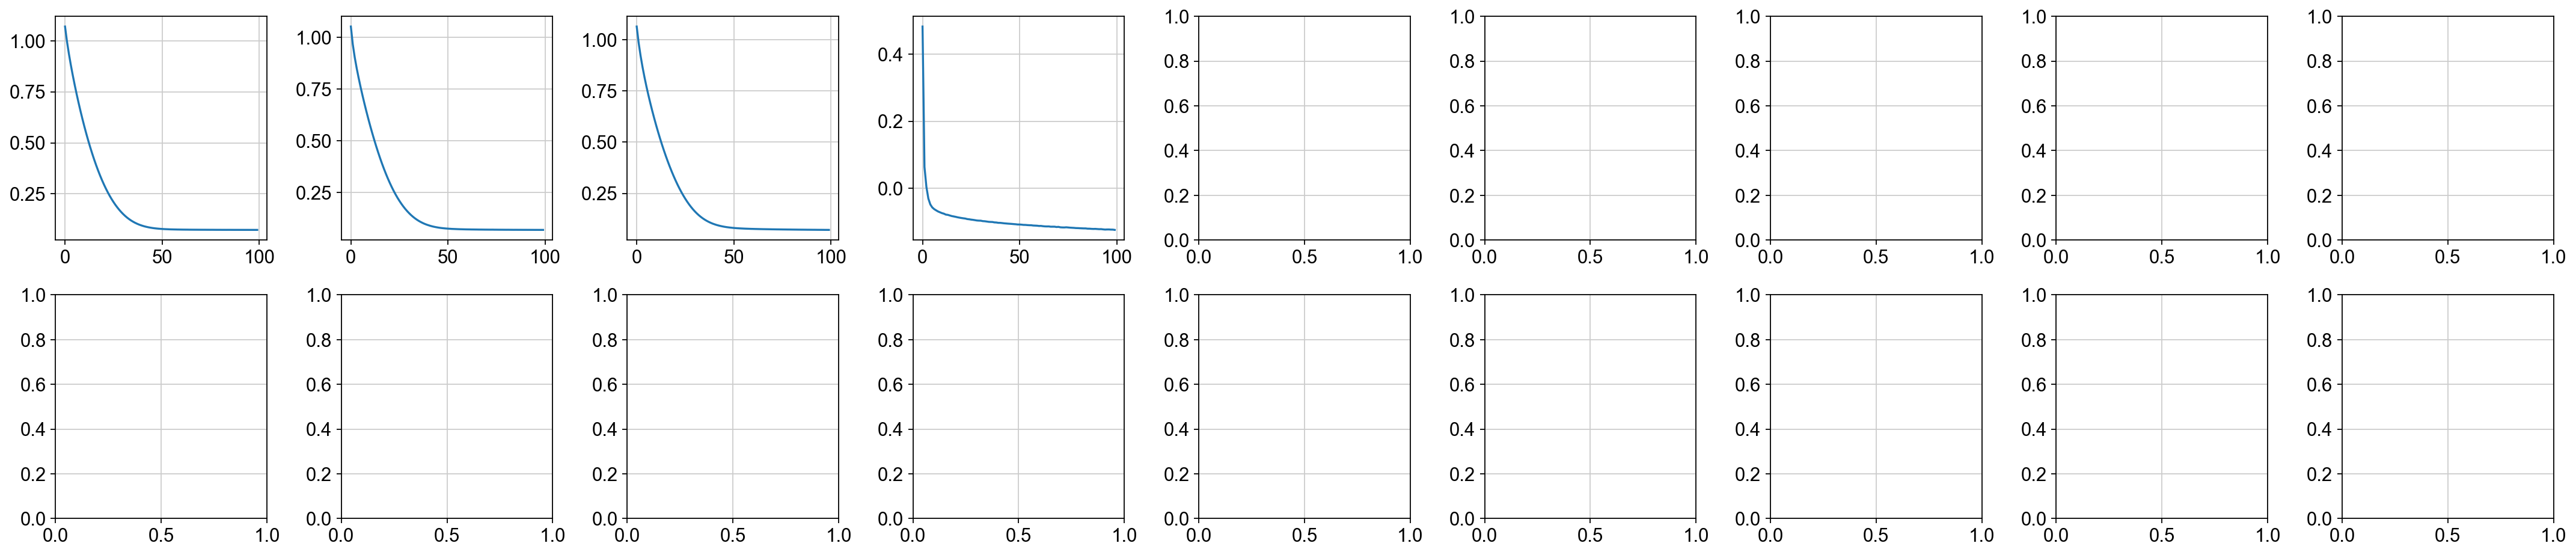

In [38]:
cvs=2
fig, axs = plt.subplots(nrows=cvs, ncols=9, figsize=(9*3, 3*cvs))
for i, (k, v) in  enumerate(evals_mp.items()):
    for j, (kk, vv) in enumerate(v.items()):
        if "history" in vv.keys():
            sb.lineplot(data=vv["history"]["loss"], ax=axs[i, j])
plt.tight_layout()
plt.show()

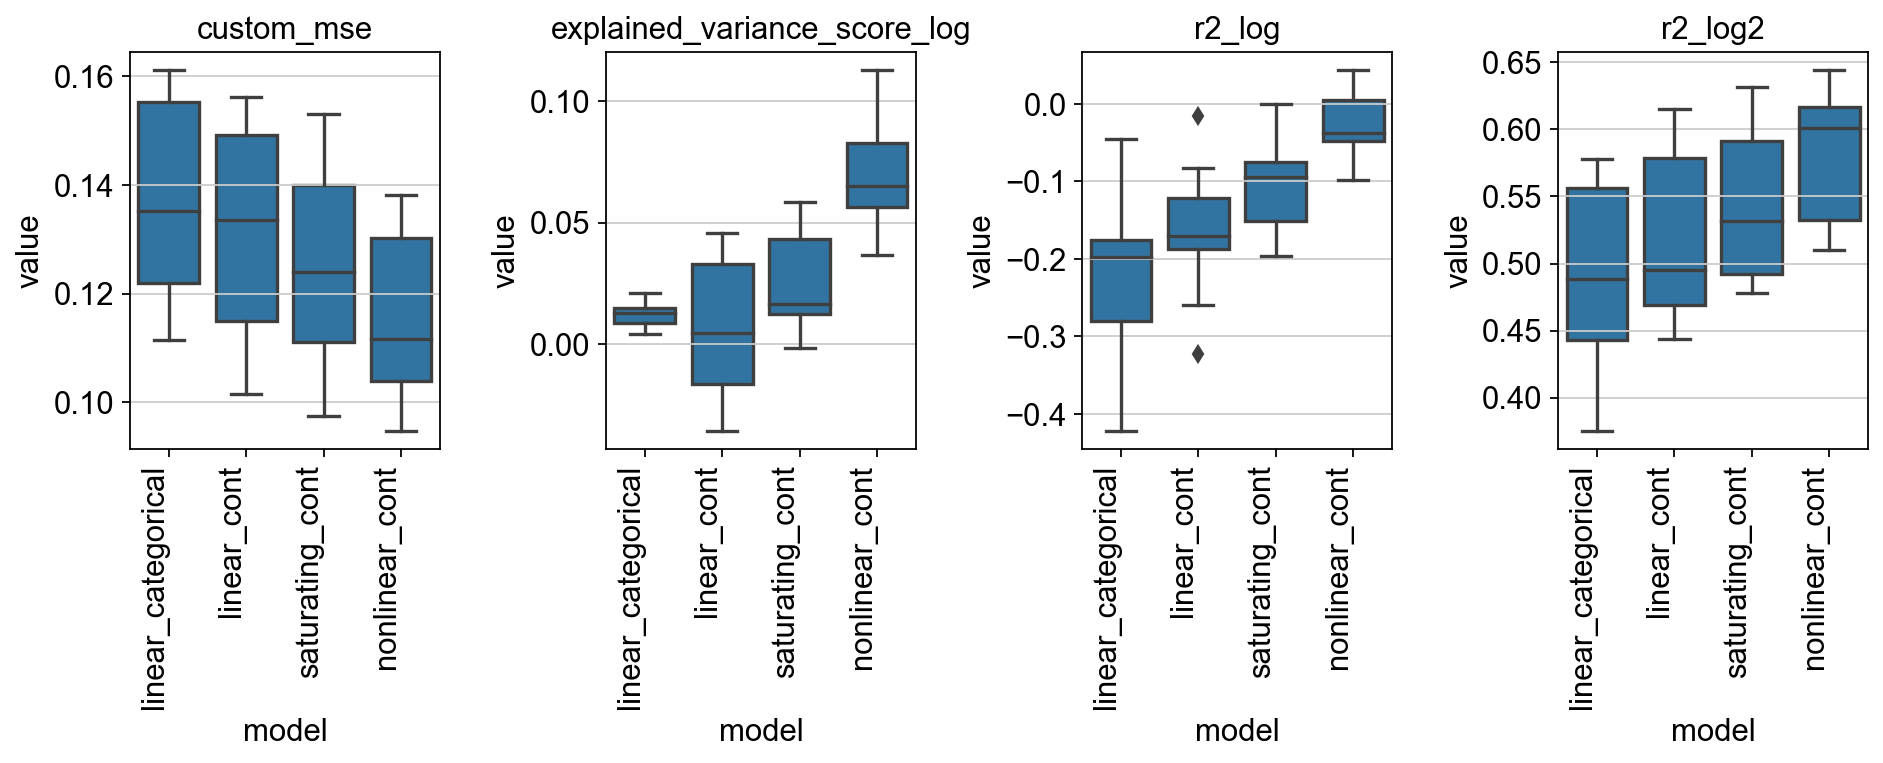

In [39]:
results = \
pd.concat([
    pd.concat([
        pd.concat([
            pd.concat([
                pd.DataFrame(
                    {"cv": k, "value": vvv, "metric": kkk, "partition": p, "model": kk},
                    index=[k+kk+kkk+p]
                )
                for kkk, vvv in vv["evals"][p].items() if ("gene" not in kkk and "cell" not in kkk)], axis=0)
            for p in ["test"]], axis=0)
        for kk, vv in v.items()], axis=0)
    for k, v in evals_mp.items()], axis=0)

ncols = 4
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(ncols*3, 5))
for i, x in enumerate(["custom_mse", "explained_variance_score_log", "r2_log", "r2_log2"]):
    sb.boxplot(data=results.loc[results["metric"].values == x, :], x="model", y="value", 
               hue="partition", ax=ax[i])
    ax[i].set_title(x)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90, ha='right')
    if "_r2" in x:
        ax[i].set_ylim([0, 1])
    ax[i].legend_.remove()
plt.tight_layout()
plt.show()

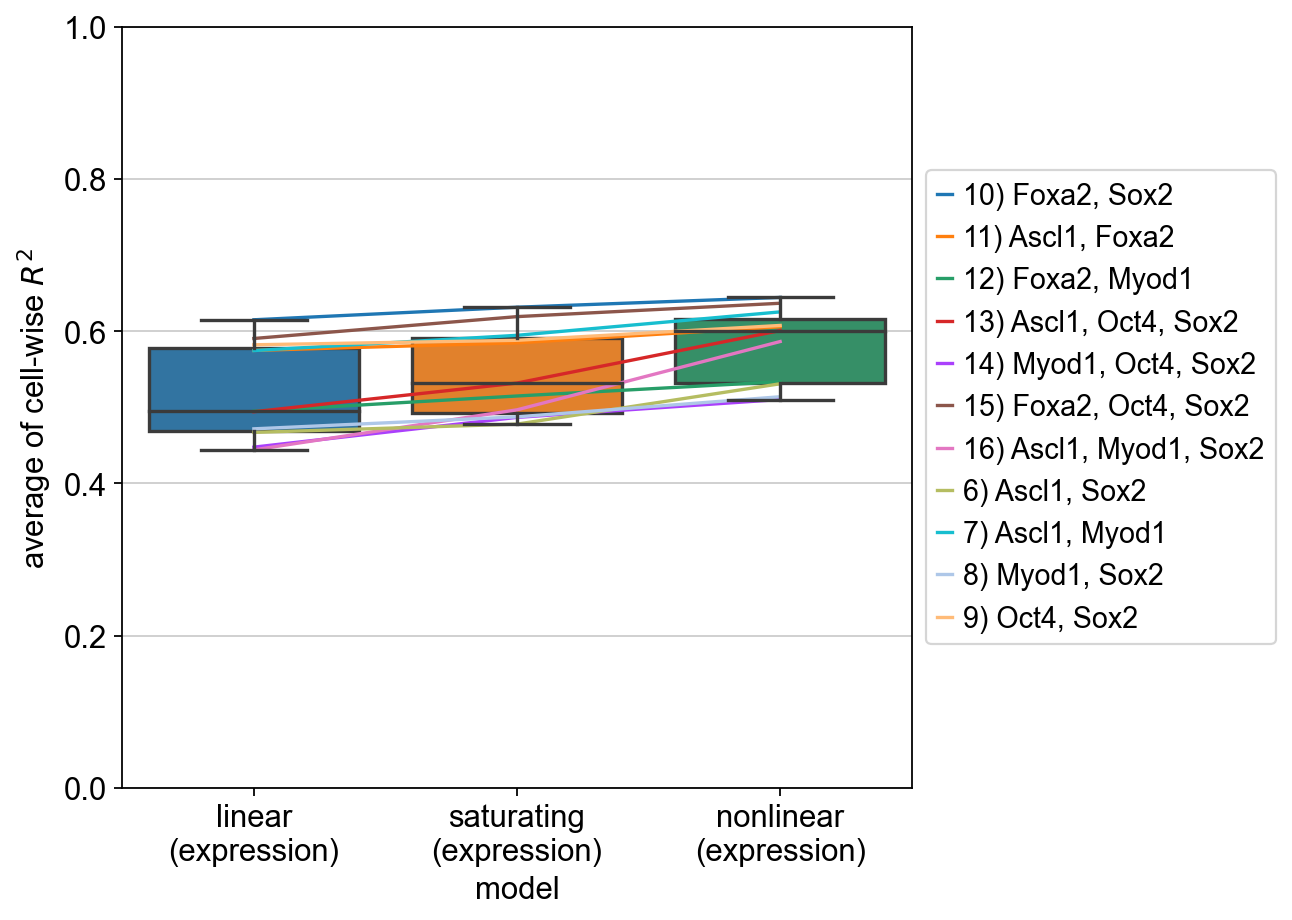

In [40]:
data = results.loc[[x in ["r2_log2"]
                      for x in results["metric"].values], :]
data = data.loc[[x in ["linear_cont", "saturating_cont", "nonlinear_cont"]
                       for x in data["model"].values], :]
data["model"] = pd.Categorical(
    [{"linear_cont": "linear\n(expression)", 
      "saturating_cont": "saturating\n(expression)", 
      "nonlinear_cont": "nonlinear\n(expression)"}[x] 
     for x in data["model"].values.tolist()], 
    categories=["linear\n(expression)", 
                "saturating\n(expression)", 
                "nonlinear\n(expression)"])
data["metric"] = pd.Categorical(
    [{"r2_log2": "R2"}[x] 
     for x in data["metric"].values.tolist()], 
    categories=["R2"])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
sb.lineplot(
    data=data, 
    x="model", y="value", hue="cv", ax=ax)
sb.boxplot(
    data=data, 
    x="model", y="value", ax=ax)
ax.set_title("")
ax.xaxis.set_tick_params(rotation=0)
ax.set_ylim([0, 1])
ax.set_ylabel("average of cell-wise $R^2$")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.95, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

## Predict triple-positive hold-outs

In [41]:
test_conditions = [
    x for x in np.unique(adata_proc_prediction.obs["inferred_category_real"].values)
    if len(x.split(",")) > 2]
train_conditions = [
    x for x in np.unique(adata_proc_prediction.obs["inferred_category_real"].values)
    if len(x.split(",")) <= 2]
evals_tp = {}
estim = fatevision.estimators.Estimator(adata=adata_proc_prediction)
estim.set_y(selection="hvg", n_genes=5000, normalize=True, log=True)
for k, v in {
    "linear_categorical": coef_conditions,
    "linear_categorical_ratios": coef_conditions+coef_conditions_interactions,
    "linear_cont": coef_factors, 
    "linear_cont_ratios": coef_factors+coef_factors_ratios, 
    #"saturating_cont": coef_factors,
    #"saturating_cont_ratios": coef_factors+coef_factors_ratios,
    #"nonlinear_cont": coef_factors,
    "nonlinear_cont_ratios": coef_factors+coef_factors_ratios,
}.items():
    formula_batch = "~1+batch+sf"
    formula = "~0+" + "+".join(v)        
    as_numeric = ["sf"]
    if "cont" in k:
        as_numeric += v
    estim.set_x(formula=formula, formula_batch=formula_batch, as_numeric=as_numeric)
    cv = test_conditions[0]
    if cv not in evals_tp.keys():
        evals_tp[cv] = {}
    estim.split_groups(
        grouping="inferred_category_real", 
        test_groups=[cv],
        train_groups=train_conditions
    )
    estim.init_model(k)
    if "linear" in k:
        kwargs_fit = {"optim": "adam", "fit_on_full_batches": False, "batch_size": 64}
    else:
        kwargs_fit = {"optim": "adam", "fit_on_full_batches": False, "batch_size": 64}
    evals_tp[cv][k] = estim.train(epochs=100, lr=1., **kwargs_fit)
    for cv in test_conditions[1:]:
        if cv not in evals_tp.keys():
            evals_tp[cv] = {}
        estim.split_groups(
            grouping="inferred_category_real", 
            test_groups=[cv],
            train_groups=train_conditions
        )
        evals_tp[cv][k] = {"evals": estim.evaluate(partitions=["test"])}

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 12220 genes that are detected in less than 1000 counts
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
omitted groups: ['14) Myod1, Oct4, Sox2', '15) Foxa2, Oct4, Sox2', '16) Ascl1, Myod1, Sox2']
train groups: ['1) Ascl1', '10) Foxa2, Sox2', '11) Ascl1, Foxa2', '12) Foxa2, Myod1', '17) empty', '2) Foxa2', '3) Myod1', '4) Oct4', '5) Sox2', '6) Ascl1, Sox2', '7) Ascl1, Myod1', '8) Myod1, Sox2', '9) Oct4, Sox2']
test groups: ['13

44/44 [==============================] - 0s 2ms/step - loss: 0.2150 - custom_mse: 0.1213
omitted groups: ['14) Myod1, Oct4, Sox2', '15) Foxa2, Oct4, Sox2', '16) Ascl1, Myod1, Sox2']
train groups: ['1) Ascl1', '10) Foxa2, Sox2', '11) Ascl1, Foxa2', '12) Foxa2, Myod1', '17) empty', '2) Foxa2', '3) Myod1', '4) Oct4', '5) Sox2', '6) Ascl1, Sox2', '7) Ascl1, Myod1', '8) Myod1, Sox2', '9) Oct4, Sox2']
test groups: ['13) Ascl1, Oct4, Sox2']
Epoch 1/100
90/90 - 1s - loss: 1.0353 - custom_mse: 0.3042
Epoch 2/100
90/90 - 0s - loss: 0.9153 - custom_mse: 0.2133
Epoch 3/100
90/90 - 0s - loss: 0.8218 - custom_mse: 0.1743
Epoch 4/100
90/90 - 0s - loss: 0.7401 - custom_mse: 0.1539
Epoch 5/100
90/90 - 0s - loss: 0.6660 - custom_mse: 0.1418
Epoch 6/100
90/90 - 0s - loss: 0.5979 - custom_mse: 0.1340
Epoch 7/100
90/90 - 0s - loss: 0.5353 - custom_mse: 0.1284
Epoch 8/100
90/90 - 0s - loss: 0.4781 - custom_mse: 0.1244
Epoch 9/100
90/90 - 0s - loss: 0.4260 - custom_mse: 0.1213
Epoch 10/100
90/90 - 0s - loss:

90/90 - 1s - loss: 1.0095 - custom_mse: 0.2554
Epoch 2/100
90/90 - 1s - loss: 0.8872 - custom_mse: 0.1627
Epoch 3/100
90/90 - 0s - loss: 0.8020 - custom_mse: 0.1405
Epoch 4/100
90/90 - 0s - loss: 0.7272 - custom_mse: 0.1322
Epoch 5/100
90/90 - 0s - loss: 0.6581 - custom_mse: 0.1279
Epoch 6/100
90/90 - 0s - loss: 0.5937 - custom_mse: 0.1251
Epoch 7/100
90/90 - 1s - loss: 0.5337 - custom_mse: 0.1231
Epoch 8/100
90/90 - 1s - loss: 0.4782 - custom_mse: 0.1215
Epoch 9/100
90/90 - 0s - loss: 0.4272 - custom_mse: 0.1201
Epoch 10/100
90/90 - 0s - loss: 0.3809 - custom_mse: 0.1190
Epoch 11/100
90/90 - 0s - loss: 0.3392 - custom_mse: 0.1180
Epoch 12/100
90/90 - 0s - loss: 0.3020 - custom_mse: 0.1170
Epoch 13/100
90/90 - 0s - loss: 0.2694 - custom_mse: 0.1162
Epoch 14/100
90/90 - 0s - loss: 0.2410 - custom_mse: 0.1155
Epoch 15/100
90/90 - 0s - loss: 0.2166 - custom_mse: 0.1148
Epoch 16/100
90/90 - 0s - loss: 0.1959 - custom_mse: 0.1142
Epoch 17/100
90/90 - 0s - loss: 0.1786 - custom_mse: 0.1137
E

Epoch 6/100
90/90 - 0s - loss: 0.5922 - custom_mse: 0.1232
Epoch 7/100
90/90 - 0s - loss: 0.5321 - custom_mse: 0.1214
Epoch 8/100
90/90 - 0s - loss: 0.4766 - custom_mse: 0.1199
Epoch 9/100
90/90 - 0s - loss: 0.4256 - custom_mse: 0.1186
Epoch 10/100
90/90 - 0s - loss: 0.3792 - custom_mse: 0.1175
Epoch 11/100
90/90 - 0s - loss: 0.3375 - custom_mse: 0.1165
Epoch 12/100
90/90 - 0s - loss: 0.3004 - custom_mse: 0.1156
Epoch 13/100
90/90 - 0s - loss: 0.2677 - custom_mse: 0.1149
Epoch 14/100
90/90 - 0s - loss: 0.2392 - custom_mse: 0.1142
Epoch 15/100
90/90 - 0s - loss: 0.2148 - custom_mse: 0.1136
Epoch 16/100
90/90 - 0s - loss: 0.1941 - custom_mse: 0.1130
Epoch 17/100
90/90 - 0s - loss: 0.1767 - custom_mse: 0.1125
Epoch 18/100
90/90 - 0s - loss: 0.1623 - custom_mse: 0.1120
Epoch 19/100
90/90 - 1s - loss: 0.1507 - custom_mse: 0.1116
Epoch 20/100
90/90 - 0s - loss: 0.1412 - custom_mse: 0.1112
Epoch 21/100
90/90 - 0s - loss: 0.1338 - custom_mse: 0.1109
Epoch 22/100
90/90 - 0s - loss: 0.1280 - cus

90/90 - 1s - loss: -2.8801e-02 - custom_mse: 0.1032
Epoch 11/100
90/90 - 1s - loss: -3.1113e-02 - custom_mse: 0.1029
Epoch 12/100
90/90 - 1s - loss: -3.2569e-02 - custom_mse: 0.1026
Epoch 13/100
90/90 - 1s - loss: -3.4527e-02 - custom_mse: 0.1023
Epoch 14/100
90/90 - 1s - loss: -3.6139e-02 - custom_mse: 0.1021
Epoch 15/100
90/90 - 1s - loss: -3.7461e-02 - custom_mse: 0.1019
Epoch 16/100
90/90 - 1s - loss: -3.8578e-02 - custom_mse: 0.1017
Epoch 17/100
90/90 - 1s - loss: -3.9565e-02 - custom_mse: 0.1015
Epoch 18/100
90/90 - 1s - loss: -4.1111e-02 - custom_mse: 0.1013
Epoch 19/100
90/90 - 1s - loss: -4.1683e-02 - custom_mse: 0.1012
Epoch 20/100
90/90 - 1s - loss: -4.3080e-02 - custom_mse: 0.1011
Epoch 21/100
90/90 - 1s - loss: -4.3727e-02 - custom_mse: 0.1010
Epoch 22/100
90/90 - 1s - loss: -4.4867e-02 - custom_mse: 0.1008
Epoch 23/100
90/90 - 1s - loss: -4.5940e-02 - custom_mse: 0.1006
Epoch 24/100
90/90 - 1s - loss: -4.6144e-02 - custom_mse: 0.1006
Epoch 25/100
90/90 - 1s - loss: -4.741

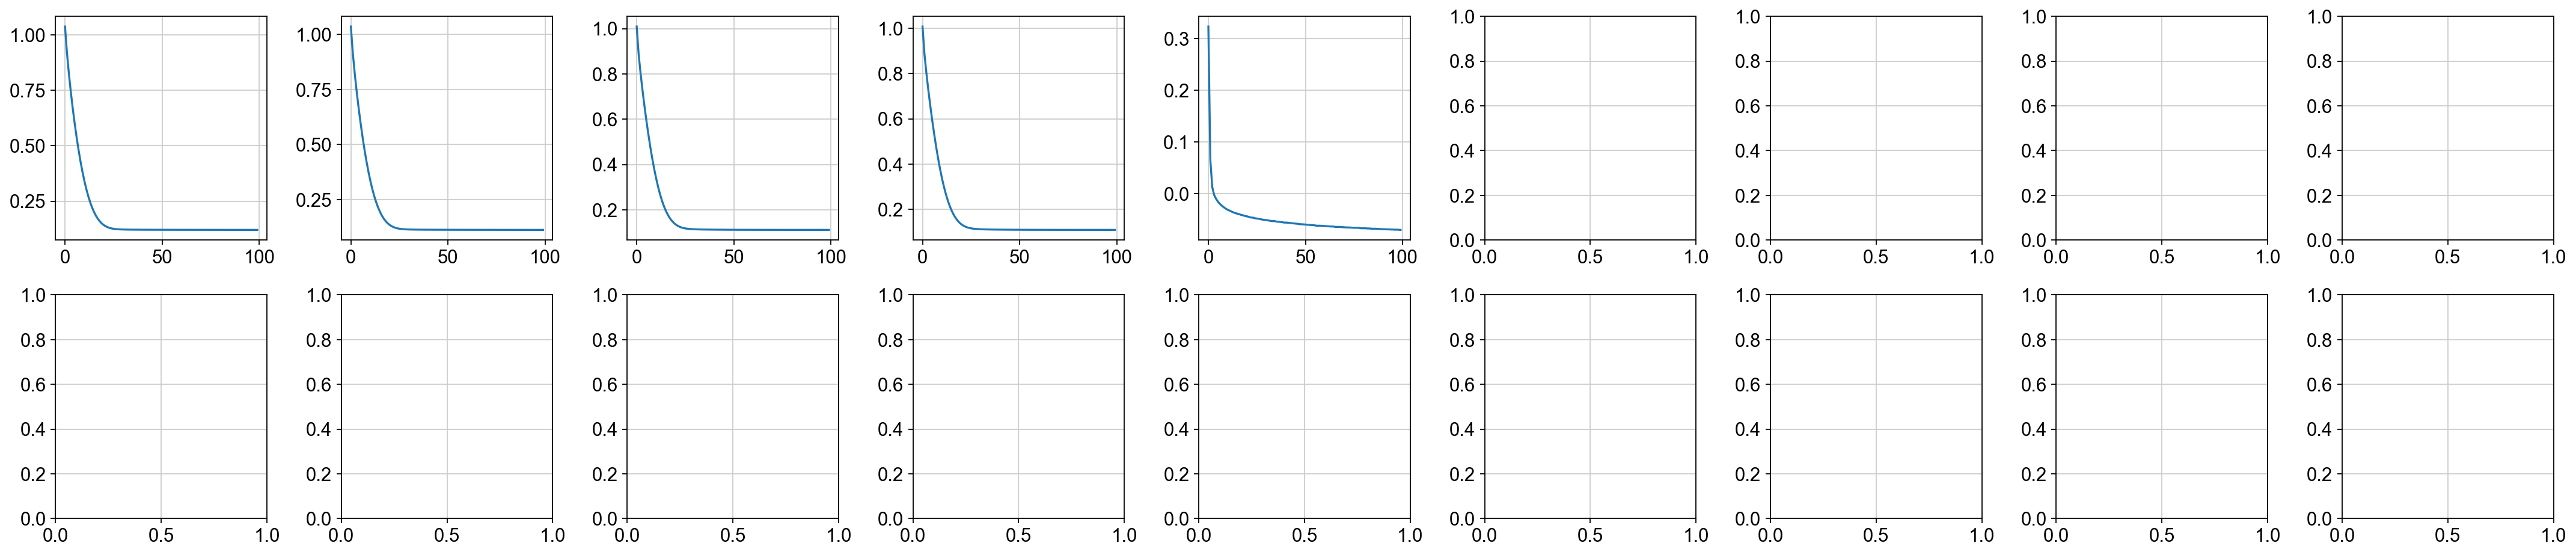

In [42]:
cvs=2
fig, axs = plt.subplots(nrows=cvs, ncols=9, figsize=(9*3, 3*cvs))
for i, (k, v) in  enumerate(evals_tp.items()):
    for j, (kk, vv) in enumerate(v.items()):
        if "history" in vv.keys():
            sb.lineplot(data=vv["history"]["loss"], ax=axs[i, j])
plt.tight_layout()
plt.show()

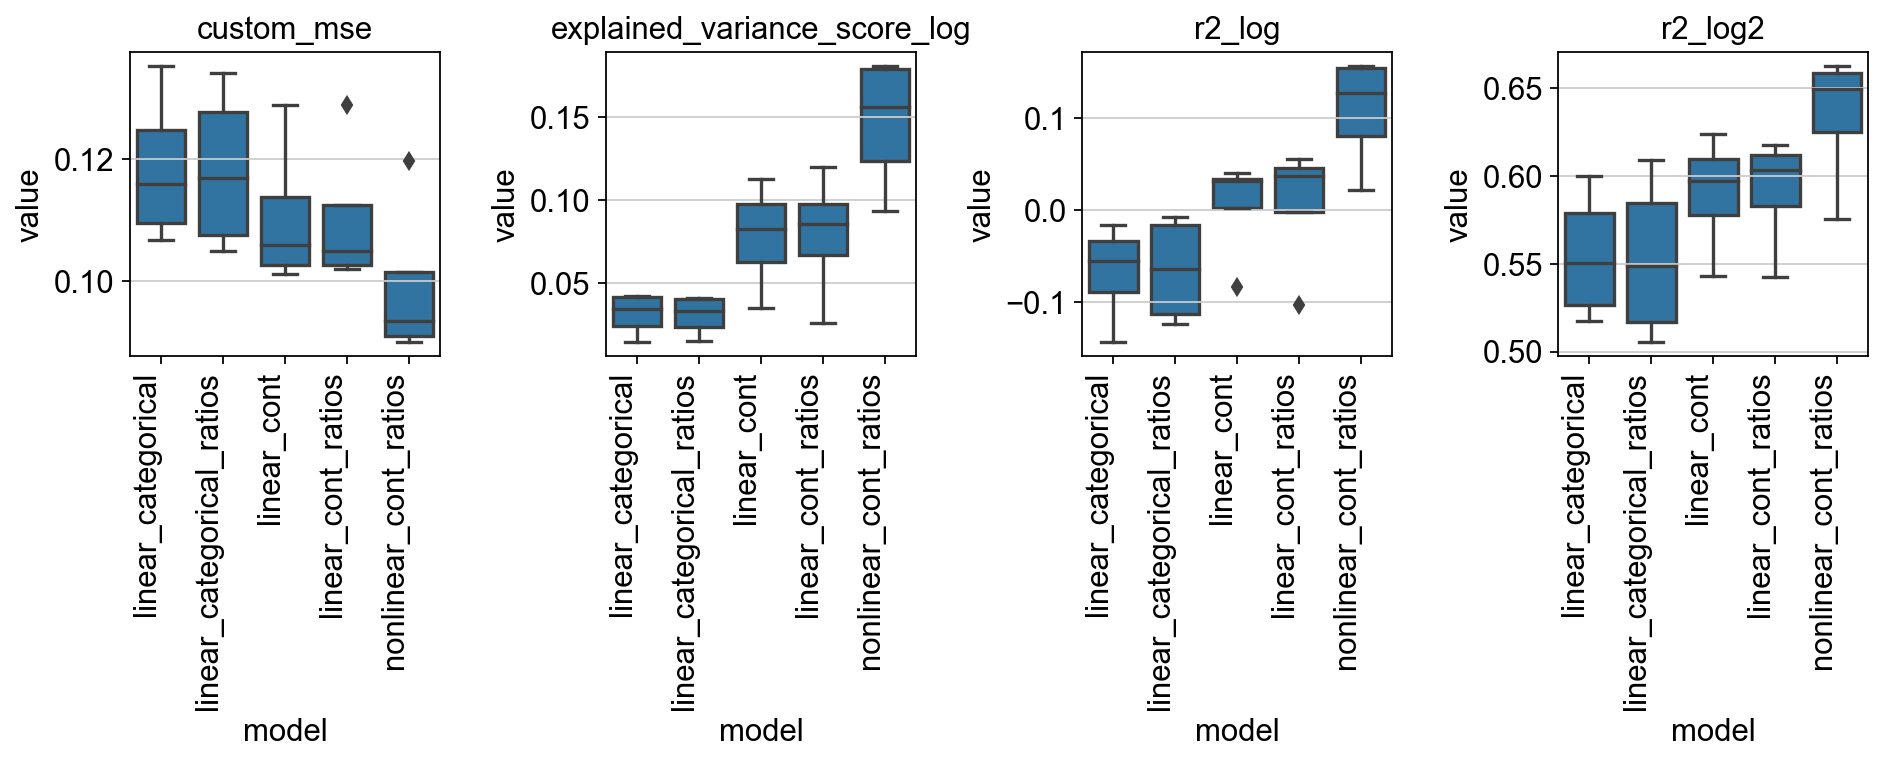

In [49]:
results = \
pd.concat([
    pd.concat([
        pd.concat([
            pd.concat([
                pd.DataFrame(
                    {"cv": k, "value": vvv, "metric": kkk, "partition": p, "model": kk},
                    index=[k+kk+kkk+p]
                )
                for kkk, vvv in vv["evals"][p].items() if ("gene" not in kkk and "cell" not in kkk)], axis=0)
            for p in ["test"]], axis=0)
        for kk, vv in v.items()], axis=0)
    for k, v in evals_tp.items()], axis=0)

ncols = 4
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(ncols*3, 5))
for i, x in enumerate(["custom_mse", "explained_variance_score_log", "r2_log", "r2_log2"]):
    sb.boxplot(data=results.loc[results["metric"].values == x, :], x="model", y="value", 
               hue="partition", ax=ax[i])
    ax[i].set_title(x)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90, ha='right')
    if "_r2" in x:
        ax[i].set_ylim([0, 1])
    ax[i].legend_.remove()
plt.tight_layout()
plt.show()

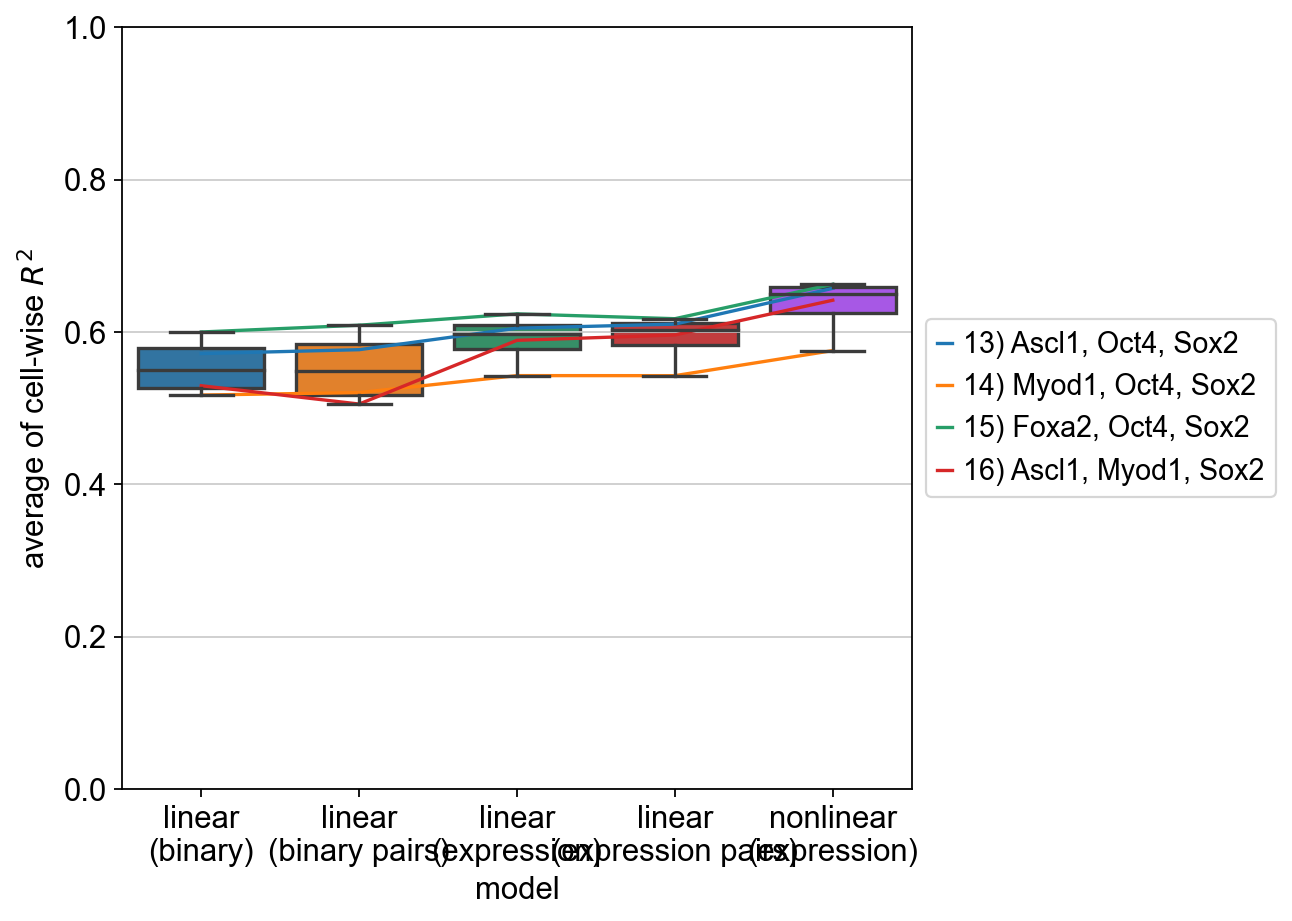

In [50]:
data = results.loc[[x in ["r2_log2"]
                      for x in results["metric"].values], :]
#data = data.loc[[x in ["linear_categorical", "linear_cont", "saturating_cont", "nonlinear_cont"]
#                       for x in data["model"].values], :]
data["model"] = pd.Categorical(
    [{"linear_categorical": "linear\n(binary)",
      "linear_categorical_ratios": "linear\n(binary pairs)",
      "linear_cont": "linear\n(expression)", 
      "linear_cont_ratios": "linear\n(expression pairs)", 
      "nonlinear_cont_ratios": "nonlinear\n(expression)"}[x] 
     for x in data["model"].values.tolist()], 
    categories=["linear\n(binary)",
                "linear\n(binary pairs)", 
                "linear\n(expression)", 
                "linear\n(expression pairs)", 
                "nonlinear\n(expression)"])
data["metric"] = pd.Categorical(
    [{"r2_log2": "R2"}[x] 
     for x in data["metric"].values.tolist()], 
    categories=["R2"])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
sb.lineplot(
    data=data, 
    x="model", y="value", hue="cv", ax=ax)
sb.boxplot(
    data=data, 
    x="model", y="value", ax=ax)
ax.set_title("")
ax.xaxis.set_tick_params(rotation=0)
ax.set_ylim([0, 1])
ax.set_ylabel("average of cell-wise $R^2$")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.95, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

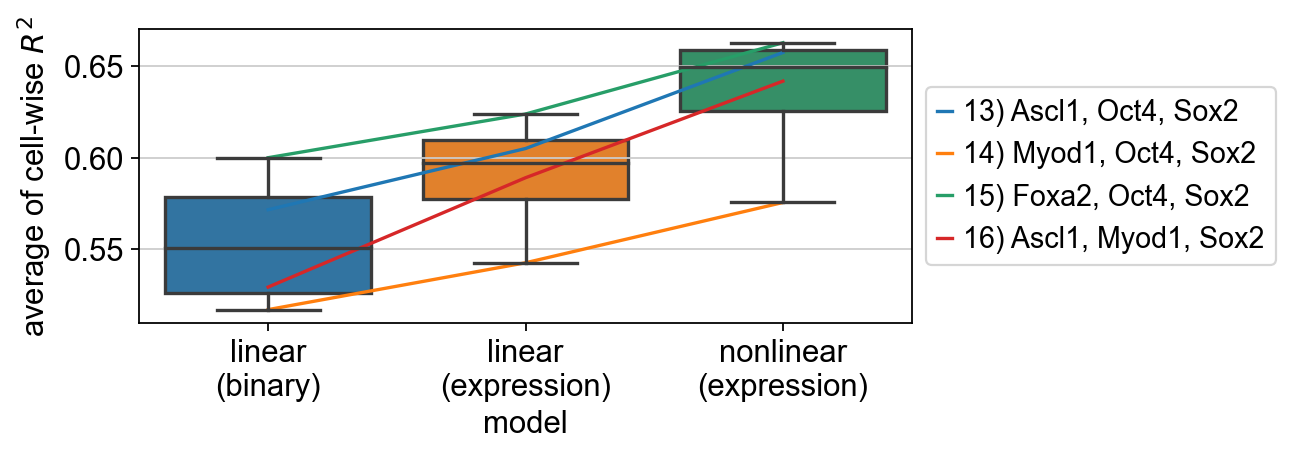

In [51]:
data = results.loc[[x in ["r2_log2"]
                      for x in results["metric"].values], :]
data = data.loc[[x in ["linear_categorical", "linear_cont", "nonlinear_cont_ratios"]
                       for x in data["model"].values], :]
data["model"] = pd.Categorical(
    [{"linear_categorical": "linear\n(binary)",
      "linear_cont": "linear\n(expression)", 
      "nonlinear_cont_ratios": "nonlinear\n(expression)"}[x] 
     for x in data["model"].values.tolist()], 
    categories=["linear\n(binary)",
                "linear\n(expression)", 
                "nonlinear\n(expression)"])
data["metric"] = pd.Categorical(
    [{"r2_log2": "R2"}[x] 
     for x in data["metric"].values.tolist()], 
    categories=["R2"])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 3))
sb.lineplot(
    data=data, 
    x="model", y="value", hue="cv", ax=ax)
sb.boxplot(
    data=data, 
    x="model", y="value", ax=ax)
ax.set_title("")
ax.xaxis.set_tick_params(rotation=0)
#ax.set_ylim([0, 1])
ax.set_ylabel("average of cell-wise $R^2$")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.95, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(dir_out + "4h.pdf")
plt.show()

In [53]:
data.groupby(["model", "metric"])["value"].mean()

model                    metric
linear\n(binary)         R2        0.554611
linear\n(expression)     R2        0.590182
nonlinear\n(expression)  R2        0.634360
Name: value, dtype: float64

## Results for TP only

In [46]:
tp_conditions = [
    x for x in np.unique(adata_proc_prediction.obs["inferred_category_real"].values)
    if len(x.split(",")) > 2]

results_mp = pd.concat([
    pd.concat([
        pd.concat([
            pd.concat([
                pd.DataFrame(
                    {"cv": k, "value": vvv, "metric": kkk, "partition": p, "model": kk},
                    index=[k+kk+kkk+p]
                )
                for kkk, vvv in vv["evals"][p].items() if ("gene" not in kkk and "cell" not in kkk)], axis=0)
            for p in ["test"]], axis=0)
        for kk, vv in v.items()], axis=0)
    for k, v in evals_mp.items() if k in tp_conditions], axis=0)
results_mp["trained_on"] = "[singlets]"
results_tp = pd.concat([
    pd.concat([
        pd.concat([
            pd.concat([
                pd.DataFrame(
                    {"cv": k, "value": vvv, "metric": kkk, "partition": p, "model": kk},
                    index=[k+kk+kkk+p]
                )
                for kkk, vvv in vv["evals"][p].items() if ("gene" not in kkk and "cell" not in kkk)], axis=0)
            for p in ["test"]], axis=0)
        for kk, vv in v.items()], axis=0)
    for k, v in evals_tp.items() if k in tp_conditions], axis=0)
results_tp["trained_on"] = "[singlets, doublets]"
results = pd.concat([results_mp, results_tp], axis=0)

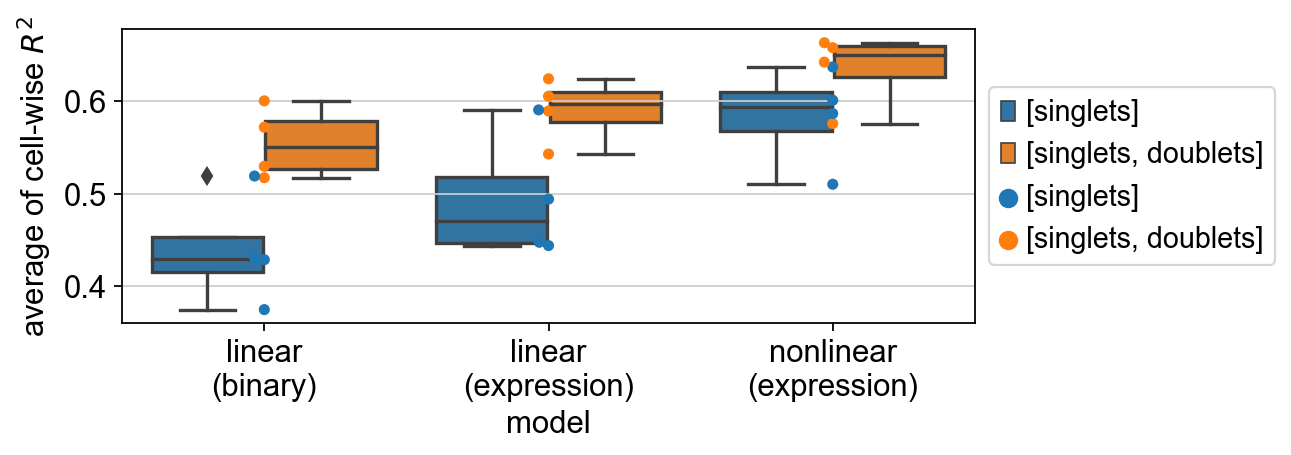

In [47]:
data = results.loc[[x in ["r2_log2"]
                      for x in results["metric"].values], :]
data = data.loc[[x in ["linear_categorical", "linear_cont", "nonlinear_cont", "nonlinear_cont_ratios"]
                       for x in data["model"].values], :]
data["model"] = pd.Categorical(
    [{"linear_categorical": "linear\n(binary)",
      "linear_cont": "linear\n(expression)", 
      "nonlinear_cont": "nonlinear\n(expression)",
      "nonlinear_cont_ratios": "nonlinear\n(expression)"}[x] 
     for x in data["model"].values.tolist()], 
    categories=["linear\n(binary)",
                "linear\n(expression)",
                "nonlinear\n(expression)",])
data["metric"] = pd.Categorical(
    [{"r2_log2": "R2"}[x] 
     for x in data["metric"].values.tolist()], 
    categories=["R2"])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 3))
sb.boxplot(
    data=data, 
    x="model", y="value", hue="trained_on", ax=ax)
sb.swarmplot(
    data=data,
    x="model", y="value", hue="trained_on", ax=ax)
ax.set_title("")
ax.xaxis.set_tick_params(rotation=0)
#ax.set_ylim([0, 1])
ax.set_ylabel("average of cell-wise $R^2$")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.95, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(dir_out + "4i.pdf")
plt.show()